In [110]:
# Standard library imports
import os
import random
import warnings

# Third-party library imports for data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
import umap

# Machine Learning and statistical testing libraries
from scipy.stats import mannwhitneyu, f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import FitFailedWarning
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Survival analysis libraries
import sksurv
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, integrated_brier_score
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv

# Feature selection libraries
from boruta import BorutaPy

# Lifelines for additional survival analysis
from lifelines.statistics import logrank_test, multivariate_logrank_test


In [111]:
split_percentage = 0.3
scaler_type = "minmax" # "robust"
feature_Sel_type = "ElasticNet"
cohort = "RTOG_0521_OS_NucDiv_in_tumor"
l1_ratio = 0.9
max_days = 5
risk_treshold_method = "median"
num_features = 15

In [112]:
rtog_features_df = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\data\nuclear_diversity_features_RTOG_0521\RTOG_0521_nucdiv_features_all_events_time_in_tumor.csv", index_col=0)
#rename biochemical_failure to event
#rename biochemical_failure_years to time
rtog_features_df = rtog_features_df.rename(columns={"survival": "event", "survival_years": "time", "cn_deidentified": "patient_id"})
rtog_features_df = rtog_features_df.drop(columns=["disease_free_survival", "disease_free_survival_years", "biochemical_failure", "biochemical_failure_years", "any_distant_mets", "any_distant_mets_years", "local_failure", "local_failure_years"])

In [113]:
rtog_features_df

,patient_id,0,1,2,3,4,5,6,7,8,...,3257,3258,3259,3260,3261,3262,3263,event,time,RX
0,0521-237186,0.192287,0.004279,0.697494,0.097045,0.182623,0.077568,0.112977,0.292100,0.376318,...,0.328007,0.050884,0.036782,0.049587,-0.551706,7.328611,0.127979,0,12.569863,2
1,0521-972417,0.183406,0.003318,0.679519,0.031302,0.167300,0.066667,0.111111,0.260870,0.377565,...,0.322236,0.048161,0.032509,0.046532,-0.636756,3.412928,0.114572,0,12.673973,2
2,0521-641497,0.209265,0.006417,0.596625,-0.611042,0.190372,0.080987,0.120370,0.329351,0.411542,...,0.304244,0.053114,0.038732,0.051167,-0.646268,3.137620,0.124269,0,12.783562,1
3,0521-650593,0.244049,0.008786,0.245951,-1.051578,0.244071,0.111111,0.111111,0.372867,0.440574,...,0.350560,0.051224,0.039100,0.049415,-0.578752,5.992154,0.126240,1,5.682192,1
4,0521-931689,0.164540,0.002974,0.986191,1.055549,0.153846,0.052632,0.111111,0.243740,0.390097,...,0.369070,0.042407,0.028096,0.040494,-0.574789,4.385850,0.111782,0,12.468493,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0521-785941,0.181409,0.004535,0.742296,0.015865,0.166667,0.040000,0.111111,0.285492,0.402062,...,0.394648,0.049378,0.035676,0.049026,-0.555272,7.190424,0.127402,0,9.619178,1
346,0521-227777,0.203703,0.005766,0.701701,-0.246077,0.186207,0.060606,0.111111,0.321429,0.432990,...,0.394648,0.051949,0.036738,0.049265,-0.646035,30.053092,0.122095,0,9.731507,2
347,0521-225186,0.200383,0.005076,0.837913,0.072707,0.181818,0.086957,0.125000,0.310682,0.445893,...,0.394648,0.054551,0.037376,0.052127,-0.650664,11.621856,0.128576,1,4.794521,1
348,0521-601511,0.227509,0.007270,0.468871,-0.684061,0.214286,0.055556,0.125000,0.352457,0.450161,...,0.365537,0.052126,0.038119,0.050999,-0.600324,21.875089,0.126132,1,7.690411,2


In [114]:
imputer = SimpleImputer(strategy='median')
rtog_features = rtog_features_df.drop(['patient_id', 'RX', 'time', 'event'], axis=1)
rtog_features.replace([np.inf, -np.inf], np.nan, inplace=True)
num_df = rtog_features.values
names = rtog_features.columns.values
print(num_df.shape)
print(names.shape)
rtog_features = pd.DataFrame(imputer.fit_transform(num_df), columns=names)

rtog_features['patient_id'] = rtog_features_df['patient_id']
rtog_features['RX'] = rtog_features_df['RX']
rtog_features['time'] = rtog_features_df['time']
rtog_features['event'] = rtog_features_df['event']
rtog_features

(350, 3264)
(3264,)


,0,1,2,3,4,5,6,7,8,9,...,3258,3259,3260,3261,3262,3263,patient_id,RX,time,event
0,0.192287,0.004279,0.697494,0.097045,0.182623,0.077568,0.112977,0.292100,0.376318,0.090770,...,0.050884,0.036782,0.049587,-0.551706,7.328611,0.127979,0521-237186,2,12.569863,0
1,0.183406,0.003318,0.679519,0.031302,0.167300,0.066667,0.111111,0.260870,0.377565,0.073365,...,0.048161,0.032509,0.046532,-0.636756,3.412928,0.114572,0521-972417,2,12.673973,0
2,0.209265,0.006417,0.596625,-0.611042,0.190372,0.080987,0.120370,0.329351,0.411542,0.125942,...,0.053114,0.038732,0.051167,-0.646268,3.137620,0.124269,0521-641497,1,12.783562,0
3,0.244049,0.008786,0.245951,-1.051578,0.244071,0.111111,0.111111,0.372867,0.440574,0.154875,...,0.051224,0.039100,0.049415,-0.578752,5.992154,0.126240,0521-650593,1,5.682192,1
4,0.164540,0.002974,0.986191,1.055549,0.153846,0.052632,0.111111,0.243740,0.390097,0.065476,...,0.042407,0.028096,0.040494,-0.574789,4.385850,0.111782,0521-931689,1,12.468493,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.181409,0.004535,0.742296,0.015865,0.166667,0.040000,0.111111,0.285492,0.402062,0.099719,...,0.049378,0.035676,0.049026,-0.555272,7.190424,0.127402,0521-785941,1,9.619178,0
346,0.203703,0.005766,0.701701,-0.246077,0.186207,0.060606,0.111111,0.321429,0.432990,0.107635,...,0.051949,0.036738,0.049265,-0.646035,30.053092,0.122095,0521-227777,2,9.731507,0
347,0.200383,0.005076,0.837913,0.072707,0.181818,0.086957,0.125000,0.310682,0.445893,0.100386,...,0.054551,0.037376,0.052127,-0.650664,11.621856,0.128576,0521-225186,1,4.794521,1
348,0.227509,0.007270,0.468871,-0.684061,0.214286,0.055556,0.125000,0.352457,0.450161,0.136223,...,0.052126,0.038119,0.050999,-0.600324,21.875089,0.126132,0521-601511,2,7.690411,1


In [115]:
rtog_features['event'].value_counts()

event
0    239
1    111
Name: count, dtype: int64

In [116]:
rtog_features['event'].value_counts()

event
0    239
1    111
Name: count, dtype: int64

#### Group event 2 as BCR

In [117]:
# drop patients with event 2
# rtog_features = rtog_features[rtog_features['event'] != 2]

In [118]:
# rtog_features.loc[rtog_features['event'] == 2, 'event'] = 1
# rtog_features['event'].value_counts()

### Do analysis on leg of RT + ADT only

In [119]:
rtog_leg_1 = rtog_features.loc[rtog_features['RX'] == 1]

In [120]:
rtog_leg_1['event'].value_counts()

event
0    111
1     58
Name: count, dtype: int64

In [121]:
rtog_leg_1

,0,1,2,3,4,5,6,7,8,9,...,3258,3259,3260,3261,3262,3263,patient_id,RX,time,event
2,0.209265,0.006417,0.596625,-0.611042,0.190372,0.080987,0.120370,0.329351,0.411542,0.125942,...,0.053114,0.038732,0.051167,-0.646268,3.137620,0.124269,0521-641497,1,12.783562,0
3,0.244049,0.008786,0.245951,-1.051578,0.244071,0.111111,0.111111,0.372867,0.440574,0.154875,...,0.051224,0.039100,0.049415,-0.578752,5.992154,0.126240,0521-650593,1,5.682192,1
4,0.164540,0.002974,0.986191,1.055549,0.153846,0.052632,0.111111,0.243740,0.390097,0.065476,...,0.042407,0.028096,0.040494,-0.574789,4.385850,0.111782,0521-931689,1,12.468493,0
7,0.163093,0.002895,1.105747,1.433436,0.149605,0.056875,0.111111,0.238881,0.392534,0.068198,...,0.046402,0.033238,0.043535,-0.665588,10.212654,0.110762,0521-493806,1,6.895890,1
11,0.165320,0.003066,0.775155,0.651301,0.156090,0.034504,0.109195,0.242306,0.409860,0.071684,...,0.048593,0.032995,0.046490,-0.638099,47.066817,0.115967,0521-948904,1,4.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.212890,0.006016,0.520543,-0.483395,0.194040,0.062500,0.118056,0.326582,0.440320,0.115069,...,0.049851,0.036805,0.048415,-0.586116,11.915838,0.121313,0521-066912,1,8.621918,0
344,0.217863,0.006363,0.492486,-0.528534,0.204189,0.071202,0.121986,0.334706,0.421305,0.119878,...,0.053895,0.038295,0.052989,-0.584980,4.753255,0.133132,0521-854996,1,8.641096,0
345,0.181409,0.004535,0.742296,0.015865,0.166667,0.040000,0.111111,0.285492,0.402062,0.099719,...,0.049378,0.035676,0.049026,-0.555272,7.190424,0.127402,0521-785941,1,9.619178,0
347,0.200383,0.005076,0.837913,0.072707,0.181818,0.086957,0.125000,0.310682,0.445893,0.100386,...,0.054551,0.037376,0.052127,-0.650664,11.621856,0.128576,0521-225186,1,4.794521,1


In [122]:
def remove_correlated_features(df, threshold=0.95):
    # Create correlation matrix
    corr_matrix = pd.DataFrame(np.corrcoef(df.values, rowvar=False), columns=df.columns).abs() 

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    # len(to_drop)

    # Drop features 
    corr_removed_df = df.drop(to_drop, axis=1)
    
    return corr_removed_df

def boruta_selected_features(feature_df, y):
    # define Boruta feature selection method
    # ipdb.set_trace()
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    feat_selector = BorutaPy(rf, n_estimators='auto', perc=95, alpha=0.05, two_step=False,verbose=0, random_state=42)

    feat_selector.fit(feature_df.values, y)

    # check selected features
    boruta_selected_features = feature_df.columns[feat_selector.support_  | feat_selector.support_weak_].to_list()
    boruta_selected_features_df = feature_df[boruta_selected_features]
    
    return boruta_selected_features_df

def get_discriminative_features(view_features):

    view_features_trim1 = view_features.drop(['patient_id', 'event', 'time'], axis=1) #'view', , 'img_id'
    y = view_features['event']
    if scaler_type == "minmax":
        scaler = MinMaxScaler() #StandardScaler() #RobustScaler() #
    else:
        scaler = RobustScaler(unit_variance=True)
    view_features_scaled = pd.DataFrame(scaler.fit_transform(view_features_trim1.values), columns=view_features_trim1.columns)

    view_features_trim2 = remove_correlated_features(view_features_scaled, threshold=0.85)


    # drop columns with zero variance using sklearn's VarianceThreshold
    sel = VarianceThreshold(threshold=0.01)
    sel.fit(view_features_trim2)
    view_features_trimmed = view_features_trim2[view_features_trim2.columns[sel.get_support(indices=True)]]
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    feat_selector = BorutaPy(rf, n_estimators='auto', perc=98, alpha=0.05, two_step=False,verbose=0, random_state=42)

    feat_selector.fit(view_features_trimmed.values, y)


    # check selected features
    boruta_selected_features = view_features_trimmed.columns[feat_selector.support_].to_list() # | feat_selector.support_weak_

    disc_features = view_features_trimmed[boruta_selected_features]
    disc_features = pd.DataFrame(scaler.fit_transform(disc_features.values), columns=disc_features.columns)

    return disc_features#, sig_pvals

def plot_raincloudplots(df, stable_features, events_df, save_path):
    rc_plot_df = df.copy()
    rc_plot_df['event'] = events_df
    for feature in stable_features:
        fig = plt.figure(figsize=(5,4))
        # Perform wilcoxon test to check if the feature is significantly different between the two groups
        
        stat, pvalue = f_oneway(rc_plot_df[events_df==1][feature].values, rc_plot_df[events_df==0][feature].values)
        
        pt.RainCloud(x='event', y=feature, data=rc_plot_df)
        plt.title('p_val: '+str(pvalue))
        plt.show()
        fig.savefig(save_path+'_'+feature+'.png', dpi=300, bbox_inches='tight')
        


## Bootstrap Survival Analysis

In [123]:
def get_hr_and_pval(threshold, val_risk_scores, y_val_survlabel):

    # Calculate Kaplan-Meier estimator for different risk groups
    risk_groups = threshold #np.mean(val_risk_scores)#np.percentile(test_risk_scores, 50)
    risk_group_labels = np.array([1 if x > risk_groups else 0 for x in val_risk_scores])#np.digitize(test_risk_scores, risk_groups)
    survival_probs = []
    survival_times = []

    for group_label in np.unique(risk_group_labels):
        group_indices = np.where(risk_group_labels == group_label)
        group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
        survival_probs.append(group_survival_prob)
        survival_times.append(group_time)


    tstat, pval, stats0, stats1 = compare_survival(y_val_survlabel, risk_group_labels, return_stats=True)

    return tstat, pval


# divide the centerview data on training and test set

training_data, holdout_data = train_test_split(rtog_leg_1, test_size=split_percentage, random_state=42, stratify=rtog_leg_1['event'])

N_runs = 50
# Set the seed
random.seed(0)

# Generate 50 random numbers
random_numbers = [random.randint(0, 1000) for _ in range(N_runs)]

bootstrap_metrics = pd.DataFrame()

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", RuntimeWarning)


print("Running {} iterations".format(N_runs))

for i in range(N_runs):

    random_seed = random_numbers[i] #np.random.randint(1, 1000)

    # divide the training data on training and validation set
    train_data, val_data = train_test_split(training_data, test_size=split_percentage, random_state=random_seed, stratify=training_data['event'])

    X_train = train_data.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
    y_train = train_data[['patient_id','event', 'time']].reset_index(drop=True)

    X_val = val_data.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
    y_val = val_data[['patient_id','event', 'time']].reset_index(drop=True)


    #scaler = RobustScaler(unit_variance=True)#MinMaxScaler()
    if scaler_type == "minmax":
        scaler = MinMaxScaler() #StandardScaler() #RobustScaler() #
    else:
        scaler = RobustScaler(unit_variance=True)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

    varTh = VarianceThreshold(threshold=0.05)
    varTh.fit(X_train)
    X_train = X_train[X_train.columns[varTh.get_support(indices=True)]]
    X_val = X_val[X_val.columns[varTh.get_support(indices=True)]]

    X_train_decorrelated = remove_correlated_features(X_train, 0.7) #this was 0.7!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X_train_trimmed = X_train_decorrelated.copy()
    # apply boruta feature selection on the training set
    #X_train_trimmed = boruta_selected_features(X_train_decorrelated, y_train['event'].values)
    
    X_val_trimmed = X_val[X_train_trimmed.columns]

    print(f"Training features input to ElasticNet model (l1={l1_ratio}) = {X_train_trimmed.shape}")

    y_train_survlabel = Surv.from_dataframe('event', 'time', y_train)
    y_val_survlabel = Surv.from_dataframe('event', 'time', y_val)

    try:
        coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, alpha_min_ratio=0.01, max_iter=20, fit_baseline_model=True))
        warnings.simplefilter("ignore", UserWarning)
        warnings.simplefilter("ignore", FitFailedWarning)
        coxnet_pipe.fit(X_train_trimmed, y_train_survlabel)

        estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
        gcv = GridSearchCV(
        make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, fit_baseline_model=True)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=1,
        ).fit(X_train_trimmed, y_train_survlabel)

        cv_results = pd.DataFrame(gcv.cv_results_)

        alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
        mean = cv_results.mean_test_score
        std = cv_results.std_test_score


        best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
        best_coefs = pd.DataFrame(best_model.coef_, index=X_train_trimmed.columns, columns=["coefficient"])

        non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
        non_zero_coefs = best_coefs.query("coefficient != 0")
        coef_order = non_zero_coefs.abs().sort_values("coefficient").index
        print("Number of non-zero features: {}".format(non_zero))

        coxnet_pred = gcv.best_estimator_
        C_test = coxnet_pred.score(X_val_trimmed, y_val_survlabel)
        print('C-index on test set: {:.3f}'.format(C_test))

        val_risk_scores = coxnet_pred.predict(X_val_trimmed)
        events, times = y_val['event'].values.astype(bool), y_val['time'].values

        coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

        hr_median, pval_median = get_hr_and_pval(np.median(val_risk_scores), val_risk_scores, y_val_survlabel)
        hr_mean, pval_mean = get_hr_and_pval(np.mean(val_risk_scores), val_risk_scores, y_val_survlabel)


        temp_dict = {'Seed': [random_seed], 'Test_Cindex': [C_test], 'Test_pval_mean': [pval_mean], 'Hazard_ratio_mean': [hr_mean], 'Test_pval_median': [pval_median], 'Hazard_ratio_median': [hr_median], 'Nonzero_features_count': [non_zero]}
        temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
        temp_df['Nonzero_features']= [coef_order.values.tolist()]
        temp_df['Nonzero_features_coefs']= [non_zero_coefs['coefficient'].values.tolist()]


        bootstrap_metrics = pd.concat([bootstrap_metrics, temp_df], axis=0, ignore_index=True)

        if (i+1)%5 == 0:
            print("Iteration {} completed".format(i+1))
    except Exception as e:
        print("Iteration {} failed".format(i+1))
        print("Retrying iteration {}...".format(i+1))
        print(e)
        i=i-1
        continue
    

Running 50 iterations
Training features input to ElasticNet model (l1=0.9) = (82, 28)


Number of non-zero features: 0
C-index on test set: 0.500
Iteration 1 failed
Retrying iteration 1...
At least two groups must be specified, but only one was provided.
Training features input to ElasticNet model (l1=0.9) = (82, 22)
Number of non-zero features: 22
C-index on test set: 0.300
Training features input to ElasticNet model (l1=0.9) = (82, 17)
Number of non-zero features: 1
C-index on test set: 0.464
Training features input to ElasticNet model (l1=0.9) = (82, 26)
Number of non-zero features: 4
C-index on test set: 0.332
Training features input to ElasticNet model (l1=0.9) = (82, 28)
Number of non-zero features: 20
C-index on test set: 0.589
Iteration 5 completed
Training features input to ElasticNet model (l1=0.9) = (82, 21)
Number of non-zero features: 3
C-index on test set: 0.541
Training features input to ElasticNet model (l1=0.9) = (82, 29)
Number of non-zero features: 5
C-index on test set: 0.498
Training features input to ElasticNet model (l1=0.9) = (82, 23)
Number of non

In [124]:
#bootstrap_metrics.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/bootstrap_metrics_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.csv', index=False)
bootstrap_metrics

,Seed,Test_Cindex,Test_pval_mean,Hazard_ratio_mean,Test_pval_median,Hazard_ratio_median,Nonzero_features_count,Nonzero_features,Nonzero_features_coefs
0,394,0.300330,0.053545,3.726842,0.018614,5.537418,22,"[1669, 2896, 2133, 1452, 2080, 2044, 1173, 18,...","[1.1839202014431305, -3.3360213327080257, 2.91..."
1,776,0.463950,0.405560,0.691778,0.573256,0.317266,1,[60],[-0.1589660072435152]
2,911,0.332130,0.528060,0.398124,0.444312,0.585121,4,"[1992, 60, 3000, 1452]","[-0.41588073571069284, 0.6045219183466802, 0.3..."
3,430,0.588957,0.465240,0.533258,0.229837,1.441867,20,"[31, 852, 1248, 2038, 1040, 1246, 228, 1720, 2...","[-0.028993331417113234, -2.5763956379356405, -..."
4,41,0.540984,0.545801,0.364894,0.635162,0.225125,3,"[3182, 468, 1402]","[-0.2971762242720165, 0.7051639837296481, -0.2..."
5,265,0.498452,0.534979,0.384924,0.726440,0.122405,5,"[1045, 2131, 60, 2425, 2911]","[-0.14019515637637697, 0.08439022286445748, -0..."
6,988,0.467085,0.779689,0.078245,0.541355,0.373034,1,[1992],[0.7078618381752283]
7,523,0.415873,0.348370,0.879387,0.459341,0.547500,21,"[785, 806, 360, 1040, 293, 35, 2846, 1586, 213...","[0.7255503206935454, 3.2556208915171365, 0.661..."
8,497,0.405145,0.502796,0.449029,0.189174,1.724042,15,"[3237, 406, 293, 60, 796, 549, 1236, 2896, 445...","[-0.19547836124259685, 0.10338810625295053, -1..."
9,414,0.481763,0.748529,0.102772,0.656049,0.198358,1,[1246],[-0.03135255315790913]


In [125]:
feature_frequency_dict = {}
feature_coefficient_strength_dict = {}
for feature_list in bootstrap_metrics['Nonzero_features']:
    list_idx = bootstrap_metrics['Nonzero_features'].values.tolist().index(feature_list)
    for feature in feature_list:
        idx = feature_list.index(feature)
        feat_coef = np.abs(bootstrap_metrics['Nonzero_features_coefs'][list_idx][idx])
        
        if feature in feature_frequency_dict:
            feature_frequency_dict[feature] += 1
        else:
            feature_frequency_dict[feature] = 1
        
        if feature in feature_coefficient_strength_dict:
            feature_coefficient_strength_dict[feature] += feat_coef
        else:
            feature_coefficient_strength_dict[feature] = feat_coef

print(feature_frequency_dict)
print(feature_coefficient_strength_dict)

feature_frequency = pd.DataFrame(feature_frequency_dict.items(), columns=['feature', 'count'])
feature_coefs = pd.DataFrame(feature_coefficient_strength_dict.items(), columns=['feature', 'coefficient'])

# merge the two dataframes
feature_frequency = feature_frequency.merge(feature_coefs, on='feature', how='left')

feature_frequency = feature_frequency.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

# get feature score using the formula: feature_score = feature_count * feature_coefficient_strength/50 and save it in a new column

feature_frequency['feature_score'] = feature_frequency['count'] * feature_frequency['coefficient']/N_runs

feature_frequency = feature_frequency.sort_values(by='feature_score', ascending=False).reset_index(drop=True)

#feature_frequency.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/feature_frequency{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.csv', index=False)
feature_frequency

{'1669': 2, '2896': 18, '2133': 6, '1452': 14, '2080': 4, '2044': 5, '1173': 3, '18': 12, '3182': 4, '833': 17, '1992': 21, '1248': 13, '2846': 6, '2211': 1, '1279': 7, '870': 16, '2095': 15, '468': 4, '293': 12, '925': 4, '806': 6, '60': 25, '3000': 1, '31': 2, '852': 8, '2038': 3, '1040': 9, '1246': 10, '228': 6, '1720': 11, '582': 1, '360': 12, '2761': 6, '494': 1, '3018': 5, '1402': 5, '1045': 3, '2131': 9, '2425': 1, '2911': 1, '785': 5, '35': 3, '1586': 3, '2182': 2, '2046': 10, '1281': 1, '1280': 1, '56': 2, '3237': 1, '406': 5, '796': 1, '549': 1, '1236': 1, '445': 1, '2944': 1, '2995': 1, '1991': 2, '2965': 2, '25': 3, '7': 1, '357': 1, '3055': 1, '139': 1, '10': 3, '58': 2, '2350': 1, '521': 1, '2870': 2, '22': 1, '37': 1, '1313': 1, '1860': 3, '1536': 2, '1398': 3, '19': 1, '15': 3, '3220': 1, '1247': 3, '1181': 4, '2882': 1, '1043': 1, '923': 3, '3046': 3, '838': 5, '2205': 2, '1998': 2, '2062': 3, '581': 1, '87': 3, '2421': 2, '393': 1, '262': 1, '2184': 1, '2059': 1, '296

,feature,count,coefficient,feature_score
0,60,25,27.657924,13.828962
1,2896,18,35.776897,12.879683
2,1992,21,26.262310,11.030170
3,870,16,30.335540,9.707373
4,833,17,28.166300,9.576542
...,...,...,...,...
132,2425,1,0.167746,0.003355
133,444,1,0.167338,0.003347
134,22,1,0.133122,0.002662
135,2194,1,0.081353,0.001627


In [126]:

train_df = training_data[feature_frequency['feature'][:num_features].values]
holdout_df = holdout_data[feature_frequency['feature'][:num_features].values]
# train_df = training_data[feature_frequency['feature'][:5].values]
# holdout_df = holdout_data[feature_frequency['feature'][:5].values]

X_training = train_df.reset_index(drop=True)
y_training = training_data[['patient_id','event', 'time']].reset_index(drop=True)

X_holdout = holdout_df.reset_index(drop=True)
y_holdout = holdout_data[['patient_id','event', 'time']].reset_index(drop=True)
# X_training = pd.concat([X_training, X_holdout], axis=0)
# y_training = pd.concat([y_training, y_holdout], axis=0)

#scaler = RobustScaler(unit_variance=True)#MinMaxScaler()#
if scaler_type == "minmax":
    second_scaler = MinMaxScaler() #StandardScaler() #RobustScaler() #
else:
    second_scaler = RobustScaler(unit_variance=True)
X_training = pd.DataFrame(second_scaler.fit_transform(X_training), columns=X_training.columns)
X_holdout = pd.DataFrame(second_scaler.transform(X_holdout), columns=X_holdout.columns)

varTh = VarianceThreshold(threshold=0.01)
varTh.fit(X_training)
X_training = X_training[X_training.columns[varTh.get_support(indices=True)]]
X_holdout = X_holdout[X_holdout.columns[varTh.get_support(indices=True)]]

X_training_trimmed = remove_correlated_features(X_training, 0.8)
X_holdout_trimmed = X_holdout[X_training_trimmed.columns]
# concat the training and holdout data

print("Training data: {}".format(X_training_trimmed.shape))
print("Testing data: {}".format(X_holdout_trimmed.shape))

Training data: (118, 15)
Testing data: (51, 15)


In [127]:
X_training

,60,2896,1992,870,833,1452,2095,1248,360,18,1246,1720,2131,293,2046
0,0.654594,0.765146,0.054190,0.112462,0.440969,0.855054,0.675353,0.830526,0.344398,0.135145,0.138063,0.072734,0.683272,0.679923,0.086055
1,0.515411,0.482647,0.269977,0.217600,0.167701,0.280337,0.592582,0.827162,0.252575,0.698603,0.553987,0.301202,0.626836,0.377412,0.125734
2,0.424381,0.677211,0.218766,0.219257,0.448322,0.318265,0.399061,0.750671,0.441995,0.555541,0.170476,0.437051,0.320631,0.504141,0.273285
3,0.782508,0.723514,0.202848,0.151271,0.495361,0.152834,0.715790,0.917707,0.163298,0.230726,0.794669,0.188812,0.378050,0.223621,0.070456
4,0.227246,0.148916,0.352274,0.598273,0.654214,0.855054,0.075386,0.854866,0.318459,0.763728,0.138063,0.604949,0.136733,0.000000,0.408916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.260132,0.148916,0.460753,0.356662,0.448183,0.371584,0.268518,0.854866,0.418273,0.243954,0.138063,0.441006,0.171860,0.307120,0.086055
114,0.790822,0.778941,0.340135,0.239935,1.000000,0.403782,0.480620,0.418672,0.286599,0.354317,0.138063,0.371507,0.330933,0.855395,0.680119
115,0.673961,1.000000,0.289468,0.112771,0.556143,0.183880,1.000000,0.759254,0.170041,0.269586,0.063918,0.626999,1.000000,0.778349,0.068286
116,0.329281,0.148916,0.231609,0.464225,0.522368,0.735930,0.147720,0.940037,0.346679,0.448730,0.286353,0.521403,0.136733,0.332381,0.251479


In [128]:
X_holdout_trimmed

,60,2896,1992,870,833,1452,2095,1248,360,18,1246,1720,2131,293,2046
0,0.687599,0.665834,0.027636,0.209434,0.563710,0.855054,0.490893,0.535570,0.338969,0.203732,0.067821,0.596517,0.164273,0.877486,0.261501
1,0.452581,0.521576,0.220528,0.325188,0.735364,0.855054,0.451746,0.637693,0.284243,0.513270,0.061914,0.706692,0.354306,0.522313,0.447925
2,0.227246,0.147664,0.183193,0.373260,0.552584,0.291377,0.075386,1.000000,0.623184,0.269164,0.286353,0.429770,0.136733,0.000000,0.491099
3,0.305221,0.324192,0.276823,0.282035,0.493630,0.291377,0.475178,0.883893,0.448833,0.333707,0.167721,1.553874,0.164273,0.393744,0.137367
4,0.194836,0.148916,0.798069,0.340614,0.478432,0.421802,0.268518,0.883893,0.566207,0.337445,0.286353,0.175578,0.136733,0.365619,0.122278
5,0.768411,0.192871,0.824257,0.186428,0.605848,0.291377,0.268518,0.995417,0.722289,0.066235,0.228685,0.517324,0.040344,0.932065,0.581109
6,0.323169,0.597347,0.188969,0.259575,0.596953,0.425125,0.268518,0.635067,0.381969,0.306695,0.138063,0.435191,0.164273,0.522313,0.200298
7,0.045741,0.466366,0.034795,0.305273,0.087921,0.776791,0.227563,1.116107,0.027648,0.416742,0.632364,0.011134,0.668915,0.000000,0.086055
8,0.317957,0.135519,0.129880,0.336139,0.196301,0.757225,0.155116,1.000000,0.162267,1.516795,0.286353,0.199812,0.174231,-0.121873,0.086055
9,0.180548,0.148916,0.072611,1.490515,0.253727,0.776791,0.075386,0.572007,0.343538,0.592421,0.286353,0.066441,0.136733,0.470082,0.218577


In [129]:
X_training_trimmed

,60,2896,1992,870,833,1452,2095,1248,360,18,1246,1720,2131,293,2046
0,0.654594,0.765146,0.054190,0.112462,0.440969,0.855054,0.675353,0.830526,0.344398,0.135145,0.138063,0.072734,0.683272,0.679923,0.086055
1,0.515411,0.482647,0.269977,0.217600,0.167701,0.280337,0.592582,0.827162,0.252575,0.698603,0.553987,0.301202,0.626836,0.377412,0.125734
2,0.424381,0.677211,0.218766,0.219257,0.448322,0.318265,0.399061,0.750671,0.441995,0.555541,0.170476,0.437051,0.320631,0.504141,0.273285
3,0.782508,0.723514,0.202848,0.151271,0.495361,0.152834,0.715790,0.917707,0.163298,0.230726,0.794669,0.188812,0.378050,0.223621,0.070456
4,0.227246,0.148916,0.352274,0.598273,0.654214,0.855054,0.075386,0.854866,0.318459,0.763728,0.138063,0.604949,0.136733,0.000000,0.408916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.260132,0.148916,0.460753,0.356662,0.448183,0.371584,0.268518,0.854866,0.418273,0.243954,0.138063,0.441006,0.171860,0.307120,0.086055
114,0.790822,0.778941,0.340135,0.239935,1.000000,0.403782,0.480620,0.418672,0.286599,0.354317,0.138063,0.371507,0.330933,0.855395,0.680119
115,0.673961,1.000000,0.289468,0.112771,0.556143,0.183880,1.000000,0.759254,0.170041,0.269586,0.063918,0.626999,1.000000,0.778349,0.068286
116,0.329281,0.148916,0.231609,0.464225,0.522368,0.735930,0.147720,0.940037,0.346679,0.448730,0.286353,0.521403,0.136733,0.332381,0.251479


In [130]:
y_training

,patient_id,event,time
0,0521-364778,0,10.443836
1,0521-968370,0,12.610959
2,0521-811383,0,4.104102
3,0521-329572,0,11.621918
4,0521-989175,0,10.780844
...,...,...,...
113,0521-304868,0,12.578082
114,0521-498518,1,2.745939
115,0521-701125,1,6.243364
116,0521-042918,0,10.649001


In [131]:
y_training_survlabel = Surv.from_dataframe('event', 'time', y_training)
y_holdout_survlabel = Surv.from_dataframe('event', 'time', y_holdout)

In [132]:
len(y_training_survlabel)

118

In [133]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_training_trimmed, y_training_survlabel)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(X_training_trimmed.columns)

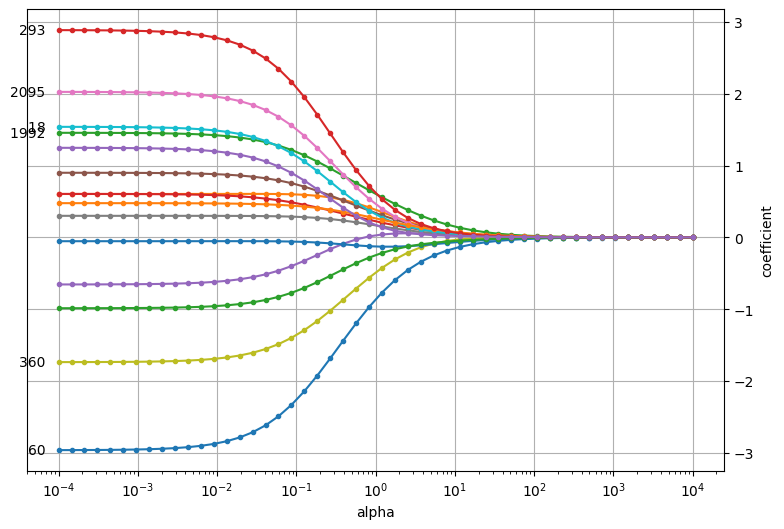

In [134]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

plot_coefficients(coefficients, n_highlight=6)

In [135]:
coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, alpha_min_ratio=0.01, max_iter=50, fit_baseline_model=True))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_training_trimmed, y_training_survlabel)

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, fit_baseline_model=True)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(X_training_trimmed, y_training_survlabel)

cv_results = pd.DataFrame(gcv.cv_results_)

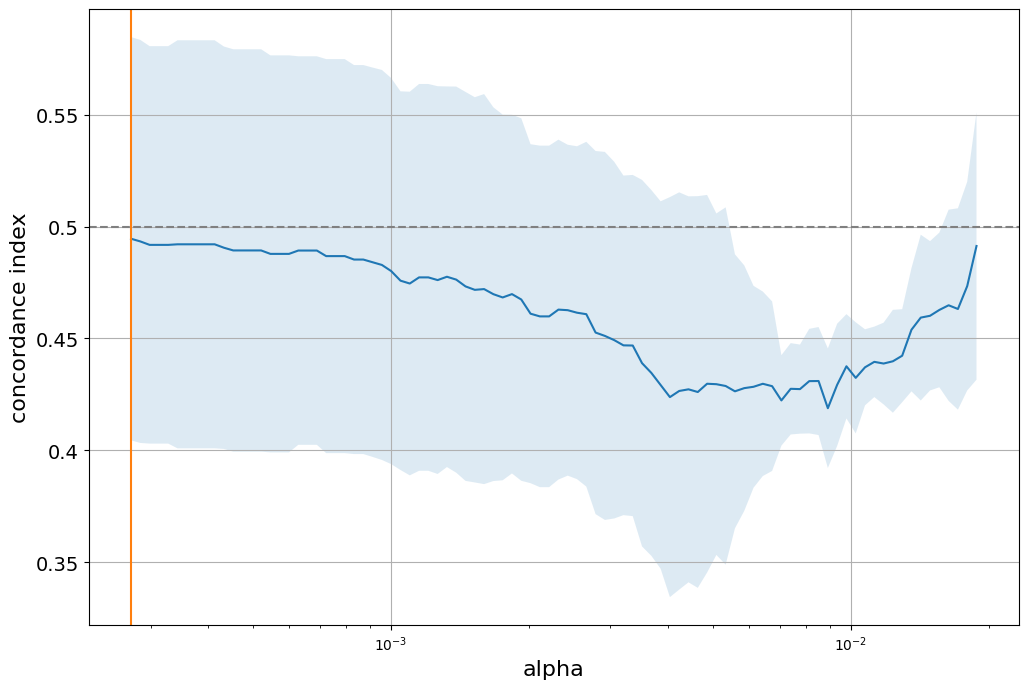

In [136]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index", fontsize=16)
ax.set_xlabel("alpha", fontsize=16)
yticks = [np.round(x,2) for x in ax.get_yticks()]
ax.set_yticklabels(yticks, fontsize=14)
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)
#fig.savefig(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/C_index_vs_alpha_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png')

In [137]:
X_training_trimmed

,60,2896,1992,870,833,1452,2095,1248,360,18,1246,1720,2131,293,2046
0,0.654594,0.765146,0.054190,0.112462,0.440969,0.855054,0.675353,0.830526,0.344398,0.135145,0.138063,0.072734,0.683272,0.679923,0.086055
1,0.515411,0.482647,0.269977,0.217600,0.167701,0.280337,0.592582,0.827162,0.252575,0.698603,0.553987,0.301202,0.626836,0.377412,0.125734
2,0.424381,0.677211,0.218766,0.219257,0.448322,0.318265,0.399061,0.750671,0.441995,0.555541,0.170476,0.437051,0.320631,0.504141,0.273285
3,0.782508,0.723514,0.202848,0.151271,0.495361,0.152834,0.715790,0.917707,0.163298,0.230726,0.794669,0.188812,0.378050,0.223621,0.070456
4,0.227246,0.148916,0.352274,0.598273,0.654214,0.855054,0.075386,0.854866,0.318459,0.763728,0.138063,0.604949,0.136733,0.000000,0.408916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.260132,0.148916,0.460753,0.356662,0.448183,0.371584,0.268518,0.854866,0.418273,0.243954,0.138063,0.441006,0.171860,0.307120,0.086055
114,0.790822,0.778941,0.340135,0.239935,1.000000,0.403782,0.480620,0.418672,0.286599,0.354317,0.138063,0.371507,0.330933,0.855395,0.680119
115,0.673961,1.000000,0.289468,0.112771,0.556143,0.183880,1.000000,0.759254,0.170041,0.269586,0.063918,0.626999,1.000000,0.778349,0.068286
116,0.329281,0.148916,0.231609,0.464225,0.522368,0.735930,0.147720,0.940037,0.346679,0.448730,0.286353,0.521403,0.136733,0.332381,0.251479


Number of non-zero coefficients: 15


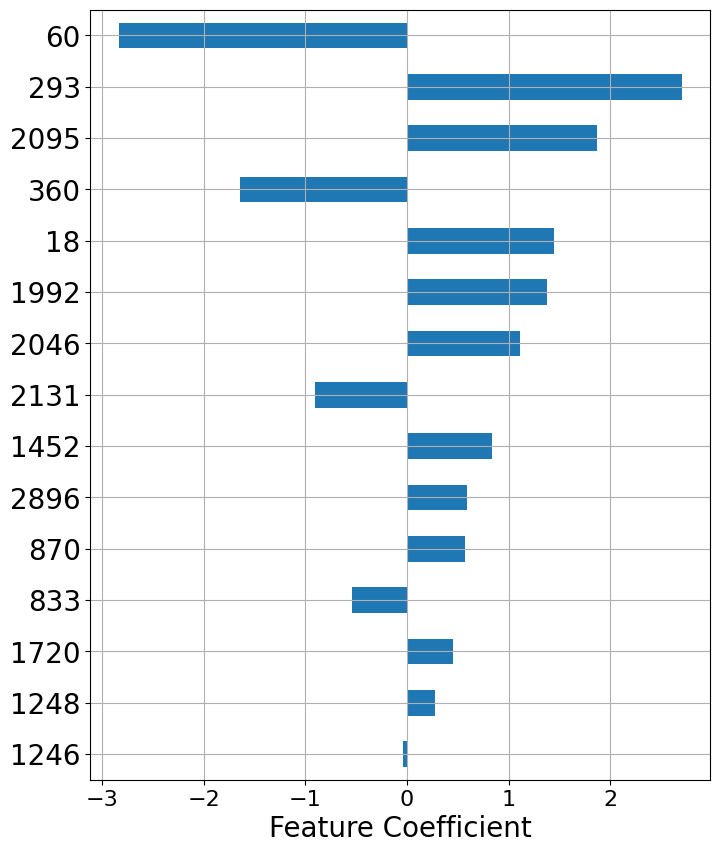

In [138]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_training_trimmed.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

fig1, ax = plt.subplots(figsize=(8,10))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("Feature Coefficient", fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=20)
ax.grid(True)
#fig1.savefig(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/TopFeatures_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png', bbox_inches="tight")

In [139]:
non_zero_coefs.index

Index(['60', '2896', '1992', '870', '833', '1452', '2095', '1248', '360', '18',
       '1246', '1720', '2131', '293', '2046'],
      dtype='object')

In [140]:
X_training_trimmed

,60,2896,1992,870,833,1452,2095,1248,360,18,1246,1720,2131,293,2046
0,0.654594,0.765146,0.054190,0.112462,0.440969,0.855054,0.675353,0.830526,0.344398,0.135145,0.138063,0.072734,0.683272,0.679923,0.086055
1,0.515411,0.482647,0.269977,0.217600,0.167701,0.280337,0.592582,0.827162,0.252575,0.698603,0.553987,0.301202,0.626836,0.377412,0.125734
2,0.424381,0.677211,0.218766,0.219257,0.448322,0.318265,0.399061,0.750671,0.441995,0.555541,0.170476,0.437051,0.320631,0.504141,0.273285
3,0.782508,0.723514,0.202848,0.151271,0.495361,0.152834,0.715790,0.917707,0.163298,0.230726,0.794669,0.188812,0.378050,0.223621,0.070456
4,0.227246,0.148916,0.352274,0.598273,0.654214,0.855054,0.075386,0.854866,0.318459,0.763728,0.138063,0.604949,0.136733,0.000000,0.408916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.260132,0.148916,0.460753,0.356662,0.448183,0.371584,0.268518,0.854866,0.418273,0.243954,0.138063,0.441006,0.171860,0.307120,0.086055
114,0.790822,0.778941,0.340135,0.239935,1.000000,0.403782,0.480620,0.418672,0.286599,0.354317,0.138063,0.371507,0.330933,0.855395,0.680119
115,0.673961,1.000000,0.289468,0.112771,0.556143,0.183880,1.000000,0.759254,0.170041,0.269586,0.063918,0.626999,1.000000,0.778349,0.068286
116,0.329281,0.148916,0.231609,0.464225,0.522368,0.735930,0.147720,0.940037,0.346679,0.448730,0.286353,0.521403,0.136733,0.332381,0.251479


In [141]:
X_holdout_trimmed

,60,2896,1992,870,833,1452,2095,1248,360,18,1246,1720,2131,293,2046
0,0.687599,0.665834,0.027636,0.209434,0.563710,0.855054,0.490893,0.535570,0.338969,0.203732,0.067821,0.596517,0.164273,0.877486,0.261501
1,0.452581,0.521576,0.220528,0.325188,0.735364,0.855054,0.451746,0.637693,0.284243,0.513270,0.061914,0.706692,0.354306,0.522313,0.447925
2,0.227246,0.147664,0.183193,0.373260,0.552584,0.291377,0.075386,1.000000,0.623184,0.269164,0.286353,0.429770,0.136733,0.000000,0.491099
3,0.305221,0.324192,0.276823,0.282035,0.493630,0.291377,0.475178,0.883893,0.448833,0.333707,0.167721,1.553874,0.164273,0.393744,0.137367
4,0.194836,0.148916,0.798069,0.340614,0.478432,0.421802,0.268518,0.883893,0.566207,0.337445,0.286353,0.175578,0.136733,0.365619,0.122278
5,0.768411,0.192871,0.824257,0.186428,0.605848,0.291377,0.268518,0.995417,0.722289,0.066235,0.228685,0.517324,0.040344,0.932065,0.581109
6,0.323169,0.597347,0.188969,0.259575,0.596953,0.425125,0.268518,0.635067,0.381969,0.306695,0.138063,0.435191,0.164273,0.522313,0.200298
7,0.045741,0.466366,0.034795,0.305273,0.087921,0.776791,0.227563,1.116107,0.027648,0.416742,0.632364,0.011134,0.668915,0.000000,0.086055
8,0.317957,0.135519,0.129880,0.336139,0.196301,0.757225,0.155116,1.000000,0.162267,1.516795,0.286353,0.199812,0.174231,-0.121873,0.086055
9,0.180548,0.148916,0.072611,1.490515,0.253727,0.776791,0.075386,0.572007,0.343538,0.592421,0.286353,0.066441,0.136733,0.470082,0.218577


In [142]:
non_zero_coefs.to_dict()['coefficient']

{'60': -2.835253886148167,
 '2896': 0.5865863105585603,
 '1992': 1.378412632342755,
 '870': 0.5689498682977064,
 '833': -0.5419574946997888,
 '1452': 0.8325653735524313,
 '2095': 1.866076769986499,
 '1248': 0.2724540025998305,
 '360': -1.6431490091871161,
 '18': 1.4469748383220706,
 '1246': -0.03908541597755394,
 '1720': 0.45456064248325356,
 '2131': -0.9019060273405166,
 '293': 2.7074910072774014,
 '2046': 1.1122244959733196}

In [143]:
coef_order

Index(['1246', '1248', '1720', '833', '870', '2896', '1452', '2131', '2046',
       '1992', '18', '360', '2095', '293', '60'],
      dtype='object')

In [144]:

print("Metrics for model")
coxnet_pred = gcv.best_estimator_

training_prediction = coxnet_pred.predict(X_training_trimmed)
holdout_prediction = coxnet_pred.predict(X_holdout_trimmed)

training_survival = coxnet_pred.predict_survival_function(X_training_trimmed)
times_training = np.arange(int(np.min(y_training_survlabel['time'])), int(np.max(y_training_survlabel["time"])))
try:
    survival_prediction_training = np.asarray([[fn(t) for t in times_training] for fn in training_survival])
except:
    print("Error in calculating survival prediction for training set")

holdout_survival = coxnet_pred.predict_survival_function(X_holdout_trimmed)
times_holdout = np.arange(int(np.min(y_holdout_survlabel['time'])), int(np.max(y_holdout_survlabel["time"])))
try:
    survival_prediction_holdout = np.asarray([[fn(t) for t in times_holdout] for fn in holdout_survival])
except:
    print("Error in calculating survival prediction for holdout set")

c_index_training = concordance_index_censored(y_training_survlabel["event"], y_training_survlabel["time"], training_prediction)
c_index_holdout = concordance_index_censored(y_holdout_survlabel["event"], y_holdout_survlabel["time"], holdout_prediction)
print('C-index on Training set: {:.3f}'.format(c_index_training[0]))
print('C-index on Holdout set: {:.3f}'.format(c_index_holdout[0]))

# calculate the IPCW C-index for the training and holdout set
c_ipcw_training = concordance_index_ipcw(y_training_survlabel, y_training_survlabel, training_prediction)
c_ipcw_holdout = concordance_index_ipcw(y_training_survlabel, y_holdout_survlabel, holdout_prediction)
print('IPCW C-index on Training set: {:.3f}'.format(c_ipcw_training[0]))
print('IPCW C-index on Holdout set: {:.3f}'.format(c_ipcw_holdout[0]))

try:
    ibs_training = integrated_brier_score(y_training_survlabel, y_training_survlabel, survival_prediction_training, times_training)
    ibs_holdout = integrated_brier_score(y_training_survlabel, y_holdout_survlabel, survival_prediction_holdout, times_holdout)
    print('IBS on training set: {:.3f}'.format(ibs_training))
    print('IBS on Holdout set: {:.3f}'.format(ibs_holdout))
except:
    print("Error in calculating IBS")

# create a dataframe to store the model type and c-index
model_metrics = pd.DataFrame()
model_metrics['cohort'] = ["Disparity"]
model_metrics['c_index_train'] = [c_index_training[0]]
model_metrics['c_index_holdout'] = [c_index_holdout[0]]
model_metrics['c_index_ipcw_train'] = [c_ipcw_training[0]]
model_metrics['c_index_ipcw_holdout'] = [c_ipcw_holdout[0]]
try:
    model_metrics['integrated_brier_score_train'] = [ibs_training]
    model_metrics['integrated_brier_score_holdout'] = [ibs_holdout]
except:
    model_metrics['integrated_brier_score_train'] = [0]
    model_metrics['integrated_brier_score_holdout'] = [0]



Metrics for model
C-index on Training set: 0.641
C-index on Holdout set: 0.636
IPCW C-index on Training set: 0.649
IPCW C-index on Holdout set: 0.622
Error in calculating IBS


In [145]:
training_risk_scores = coxnet_pred.predict(X_training_trimmed)
events, times = y_training['event'].values.astype(bool),   y_training['time'].values

coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]


# # Calculate Kaplan-Meier estimator for different risk groups
# if risk_treshold_method == "mean":
#     risk_threshold = np.mean(training_risk_scores)
# elif risk_treshold_method == "median":
#     risk_threshold = np.median(training_risk_scores)

# train_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
# train_survival_probs = []
# train_survival_times = []

# for group_label in np.unique(train_risk_group_labels):
#     group_indices = np.where(train_risk_group_labels == group_label)
#     group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
#     train_survival_probs.append(group_survival_prob)
#     train_survival_times.append(group_time)


In [146]:
min(training_risk_scores), max(training_risk_scores)

(-1.7262510368869624, 1.6683051174323698)

In [147]:
mean = np.mean(training_risk_scores)
std = np.std(training_risk_scores)

# Calculate the range
lower_bound = mean - std
upper_bound = mean + std

In [148]:
len(training_risk_scores)

118

In [149]:
threshold_values = np.linspace(lower_bound, upper_bound, num=int((upper_bound - (lower_bound)) / 0.001) + 1)
p_values = []
thresholds = []

for threshold in threshold_values:
    # Assuming 'train_risk_group_labels' needs to be defined based on the current threshold
    train_risk_group_labels = np.array([1 if x > threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
    #p_values.append(multivariate_logrank_test(times, train_risk_group_labels, events).p_value)
    thresholds.append(threshold)
    p_values.append(logrank_test(times[train_risk_group_labels==0], times[train_risk_group_labels==1], events[train_risk_group_labels==0], events[train_risk_group_labels==1]).p_value)



In [150]:
# from lifelines import KaplanMeierFitter, CoxPHFitter

# # Convert times and events to structured array expected by sksurv
# data_structured = np.array([(event, time) for event, time in zip(events, times)], 
#                            dtype=[('event', bool), ('time', float)])

# data_structured = pd.DataFrame(data_structured, columns=['event', 'time'])
# data_structured['risk_score'] = training_risk_scores

# threshold_diffs = []

# def kaplan_meier_estimator(events, times):
#     kmf = KaplanMeierFitter()
#     kmf.fit(durations=times, event_observed=events)
#     return kmf.survival_function_.index.values, kmf.survival_function_['KM_estimate'].values

# # First pass: Calculate differences in median survival times for all thresholds
# for threshold in threshold_values:
#     high_risk_data = data_structured[data_structured['risk_score'] > threshold]
#     low_risk_data = data_structured[data_structured['risk_score'] <= threshold]

#     time_high, survival_prob_high = kaplan_meier_estimator(high_risk_data['event'], high_risk_data['time'])
#     time_low, survival_prob_low = kaplan_meier_estimator(low_risk_data['event'], low_risk_data['time'])

#     median_high_risk = np.median(time_high[survival_prob_high >= 0.5])
#     median_low_risk = np.median(time_low[survival_prob_low >= 0.5])

#     diff = np.abs(median_high_risk - median_low_risk)
#     threshold_diffs.append((threshold, diff))

# # Sort the thresholds by their differences and take the top 5
# top_5_thresholds = sorted(threshold_diffs, key=lambda x: x[1], reverse=True)[:5]

# # Second pass: For the top 5 thresholds, calculate HR and select the one with the largest HR
# max_hr = 0
# optimal_threshold = None

# for threshold, _ in top_5_thresholds:
#     data_structured['risk_group'] = np.where(data_structured['risk_score'] > threshold, 1, 0)  # Use 1 for high risk, 0 for low risk
#     cph = CoxPHFitter()
#     cph.fit(data_structured[['time', 'event', 'risk_group']], 'time', 'event')
#     hr = cph.hazard_ratios_['risk_group']  # Adjust based on actual results and variable names

#     if hr > max_hr:
#         max_hr = hr
#         optimal_threshold = threshold

# # Output the optimal threshold
# print("Optimal Threshold:", optimal_threshold)
# print("Largest Hazard Ratio:", max_hr)

In [151]:
risk_threshold = np.median(training_risk_scores)
# risk_threshold = np.percentile(training_risk_scores, 25)
#risk_threshold = optimal_threshold

In [152]:
risk_threshold

0.06374719940422713

In [153]:
risk_threshold

0.06374719940422713

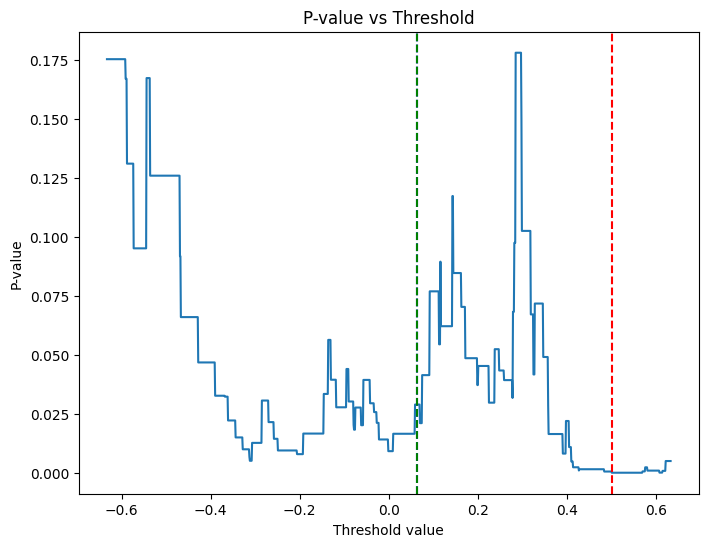

In [154]:
# plot p values vs thresholds
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, p_values)
ax.set_xlabel("Threshold value")
ax.set_ylabel("P-value")
ax.set_title("P-value vs Threshold")
#plot a red line in the minimum p-value
min_pval_idx = np.argmin(p_values)
ax.axvline(risk_threshold, color='blue', linestyle='--')
ax.axvline(thresholds[min_pval_idx], color='r', linestyle='--')
ax.axvline(np.median(training_risk_scores), color='g', linestyle='--')

In [155]:
train_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
train_survival_probs = []
train_survival_times = []

for group_label in np.unique(train_risk_group_labels):
    group_indices = np.where(train_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    train_survival_probs.append(group_survival_prob)
    train_survival_times.append(group_time)


In [156]:

holdout_risk_scores = coxnet_pred.predict(X_holdout_trimmed)
events, times = y_holdout['event'].values.astype(bool),   y_holdout['time'].values

coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]


# Calculate Kaplan-Meier estimator for different risk groups

holdout_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in holdout_risk_scores])#np.digitize(test_risk_scores, risk_groups)
holdout_survival_probs = []
holdout_survival_times = []

for group_label in np.unique(holdout_risk_group_labels):
    group_indices = np.where(holdout_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)



In [157]:

results = logrank_test(times[holdout_risk_group_labels==0], times[holdout_risk_group_labels==1], events[holdout_risk_group_labels==0], events[holdout_risk_group_labels==1])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.64 0.03      5.00

In [158]:

results = multivariate_logrank_test(times, holdout_risk_group_labels, events)
results.p_value

0.03117438152685539

In [159]:
y_holdout['risk_score'] = holdout_risk_scores
y_holdout['risk_group'] = holdout_risk_group_labels
y_holdout['patient_id'] = y_holdout['patient_id']
y_holdout = y_holdout.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout

,patient_id,event,time,risk_score,risk_group
0,0521-011235,0,10.736986,-1.141965,0
1,0521-029609,0,11.534247,-0.110413,0
2,0521-031663,0,9.978082,-0.248779,0
3,0521-032790,1,2.810959,0.246811,1
4,0521-061104,0,11.600000,-1.070910,0
5,0521-061895,0,4.449315,0.749790,1
6,0521-120451,0,11.597260,-0.087718,0
7,0521-120891,0,12.071233,-0.473601,0
8,0521-123562,0,10.625810,1.051016,1
9,0521-140656,0,9.487671,0.737719,1


In [160]:
y_training['risk_score'] = training_risk_scores
y_training['risk_group'] = train_risk_group_labels
y_training['patient_id'] = y_training['patient_id']
y_training = y_training.sort_values(by=['patient_id']).reset_index(drop=True)
y_training

,patient_id,event,time,risk_score,risk_group
0,0521-002001,0,7.111790,0.162134,1
1,0521-035384,0,9.703099,0.346228,1
2,0521-039456,1,1.936986,-0.285831,0
3,0521-042494,0,12.550685,-0.079599,0
4,0521-042918,0,10.649001,-0.022283,0
...,...,...,...,...,...
113,0521-968370,0,12.610959,0.116289,1
114,0521-972302,0,6.679145,0.277764,1
115,0521-983798,0,10.441680,0.144192,1
116,0521-989175,0,10.780844,0.200268,1


In [161]:
# y_holdout.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/holdout_survival_risk_scores_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}_top_1.csv', index=False)
# y_training.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/training_survival_risk_scores_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}_top_1.csv', index=False)

In [162]:
from lifelines import CoxPHFitter

LL_train = y_training.drop(['patient_id', 'risk_score'], axis=1)
LL_holdout = y_holdout.drop(['patient_id', 'risk_score'], axis=1)
cph_train = CoxPHFitter()
cph_train.fit(LL_train, duration_col='time', event_col='event', show_progress=False)

cph_holdout = CoxPHFitter()
cph_holdout.fit(LL_holdout, duration_col='time', event_col='event', show_progress=False)


training_results = cph_train.summary
training_p = multivariate_logrank_test(y_training['time'], y_training['risk_group'], y_training['event']).p_value# training_results['p'].values[0]
training_hr = training_results['exp(coef)'].values[0]
training_ci_lower = training_results['exp(coef) lower 95%'].values[0]
training_ci_upper = training_results['exp(coef) upper 95%'].values[0]
training_log_likelihood = cph_train.log_likelihood_
model_metrics['training_p_value'] = [training_p]
model_metrics['training_hazard_ratio'] = [training_hr]
model_metrics['training_hr_ci_lower'] = [training_ci_lower]
model_metrics['training_hr_ci_upper'] = [training_ci_upper]
model_metrics['training_log_likelihood'] = [training_log_likelihood]
model_metrics['training_parameters'] = [cph_train.params_.shape[0]]

training_data_stats = (training_p, training_hr, training_ci_lower, training_ci_upper)


holdout_results = cph_holdout.summary
holdout_p = multivariate_logrank_test(y_holdout['time'], y_holdout['risk_group'], y_holdout['event']).p_value # holdout_results['p'].values[0]
holdout_hr = holdout_results['exp(coef)'].values[0]
holdout_ci_lower = holdout_results['exp(coef) lower 95%'].values[0]
holdout_ci_upper = holdout_results['exp(coef) upper 95%'].values[0]
holdout_log_likelihood = cph_holdout.log_likelihood_
model_metrics['holdout_p_value'] = [holdout_p]
model_metrics['holdout_hazard_ratio'] = [holdout_hr]
model_metrics['holdout_hr_ci_lower'] = [holdout_ci_lower]
model_metrics['holdout_hr_ci_upper'] = [holdout_ci_upper]
model_metrics['holdout_log_likelihood'] = [holdout_log_likelihood]
model_metrics['holdout_parameters'] = [cph_holdout.params_.shape[0]]

holdout_data_stats = (holdout_p, holdout_hr, holdout_ci_lower, holdout_ci_upper)




In [163]:
holdout_data_stats

(0.031174381526855192,
 2.882833041074201,
 1.0566223293577715,
 7.865370730675824)

In [164]:
cph_holdout.score(LL_holdout, scoring_method='log_likelihood')

-1.193774908012531

In [165]:
cph_train.print_summary()

<lifelines.CoxPHFitter: fitted with 118 total observations, 78 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 118
number of events observed = 40
   partial log-likelihood = -175.22
         time fit was run = 2024-05-07 21:25:05 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
risk_group  0.70      2.01      0.33            0.06            1.34                1.06                3.82

            cmp to    z    p  -log2(p)
covariate                             
risk_group    0.00 2.14 0.03      4.95
---
Concordance = 0.59
Partial AIC = 352.44
log-likelihood ratio test = 4.76 on 1 df
-log2(p) of ll-ratio test = 5.10

In [166]:
cph_holdout.print_summary()

<lifelines.CoxPHFitter: fitted with 51 total observations, 33 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 51
number of events observed = 18
   partial log-likelihood = -60.88
         time fit was run = 2024-05-07 21:25:05 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
risk_group  1.06      2.88      0.51            0.06            2.06                1.06                7.87

            cmp to    z    p  -log2(p)
covariate                             
risk_group    0.00 2.07 0.04      4.69
---
Concordance = 0.64
Partial AIC = 123.77
log-likelihood ratio test = 4.61 on 1 df
-log2(p) of ll-ratio test = 4.98

In [167]:
LL_holdout

,event,time,risk_group
0,0,10.736986,0
1,0,11.534247,0
2,0,9.978082,0
3,1,2.810959,1
4,0,11.600000,0
5,0,4.449315,1
6,0,11.597260,0
7,0,12.071233,0
8,0,10.625810,1
9,0,9.487671,1


In [168]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import seaborn as sns

def plot_km_curve_lifelines(data_df, data_stats, figure_save_path, title_str):
    
    # Create a colormap
    cmap = plt.cm.get_cmap('Reds')
    # Choose a shade of red
    hr_shade = cmap(0.75)

    cmap = plt.cm.get_cmap('Blues')
    # Choose a shade of red
    lr_shade = cmap(0.75)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    data_high_risk = data_df[data_df['risk_group']==1]
    data_low_risk = data_df[data_df['risk_group']==0]

    kmf_hr = KaplanMeierFitter()
    kmf_hr.fit(data_high_risk['time'], event_observed=data_high_risk['event'], label='High Risk')
    kmf_hr.plot_survival_function(ax=ax, color='#f8766d', lw=2, show_censors=True)

    kmf_lr = KaplanMeierFitter()
    kmf_lr.fit(data_low_risk['time'], event_observed=data_low_risk['event'], label='Low Risk')
    kmf_lr.plot_survival_function(ax=ax, color='#03bfc4', lw=2, show_censors=True, )
    
    
    print("Low risk median survival time: ",kmf_lr.median_survival_time_)
    print("High risk median survival time: ",kmf_hr.median_survival_time_)
    max_median_survival_time = max(kmf_hr.median_survival_time_ , kmf_lr.median_survival_time_)
    if max_median_survival_time == np.inf:
        plt.axhline(y=0.5, color='black', linestyle='--', lw=1)
    else:
        plt.plot([0, max_median_survival_time], [0.5, 0.5], color='black', linestyle='--', lw=1)
    # Vertical lines up to y=0.5, using plot for precise control
    plt.plot([kmf_hr.median_survival_time_, kmf_hr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    plt.plot([kmf_lr.median_survival_time_, kmf_lr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    ax.set_title(title_str, fontsize=26)

    yticks = [np.round(x,1) for x in ax.get_yticks()]
    ax.set_yticklabels(yticks, fontsize=20)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)


    ax.set_xlabel('Time (Years)', fontsize=28)
    ax.set_ylabel('Overall Survival Probability', fontsize=28)
    data_p, data_hr, data_ci_lower, data_ci_upper = data_stats
    format_p = lambda p: f"{p:.1e}" if p < 0.001 else f"{p:.4f}"

# Updated string formatting
    data_stats_text = f'p: {format_p(data_p)}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    #data_stats_text = f'p: {data_p:.1e if data_p < 0.001 else data_p:.4f}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    ax.text(0.03, 0.1, data_stats_text, transform=ax.transAxes, fontsize=24, verticalalignment='bottom')

    # Add the risk table at the bottom of the KM plot on ax[1] (the bottom subplot)
    sns.despine()
    add_at_risk_counts(kmf_hr, kmf_lr, ax=ax, fontsize=20)
    ax.legend(fontsize=24)
    plt.tight_layout()
    
    #fig.savefig(figure_save_path, bbox_inches='tight')
    plt.show()





C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\2546873751.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\2546873751.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  10.83835616


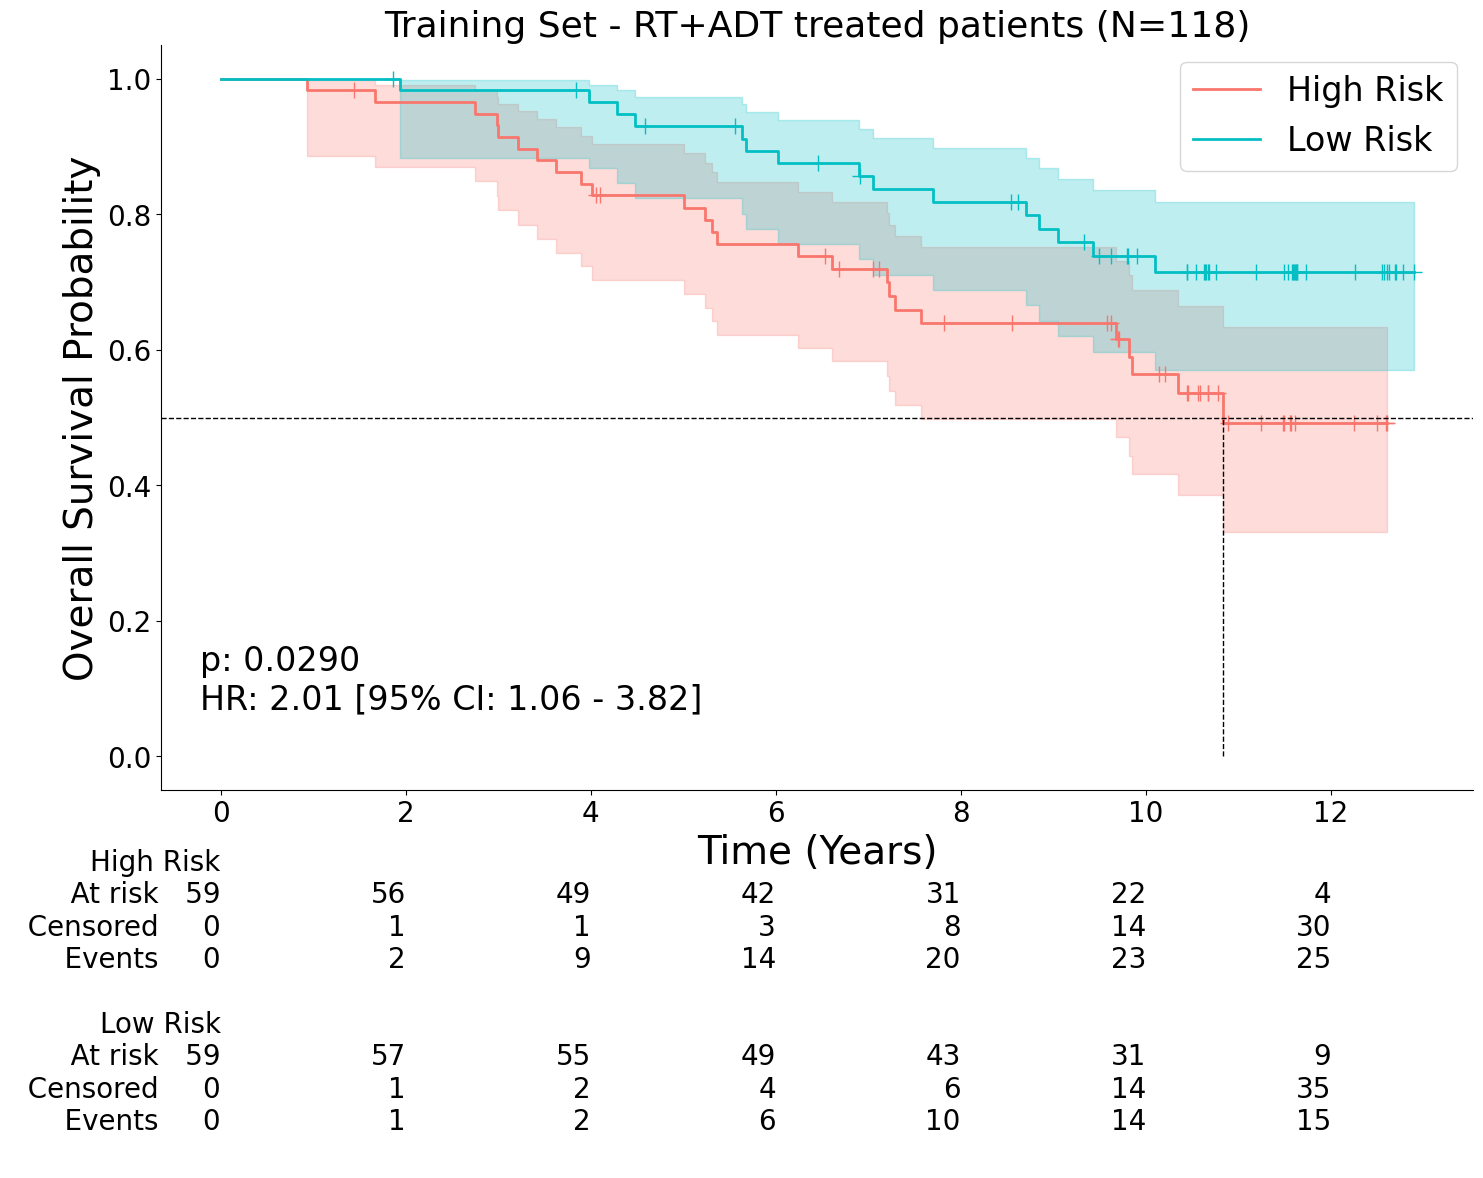

In [169]:
train_title_str = 'Training Set - RT+ADT treated patients (N={:d})'.format(len(y_training))
train_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_training_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_training, training_data_stats, train_figure_save_path, train_title_str)

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\2546873751.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\2546873751.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  10.22661127


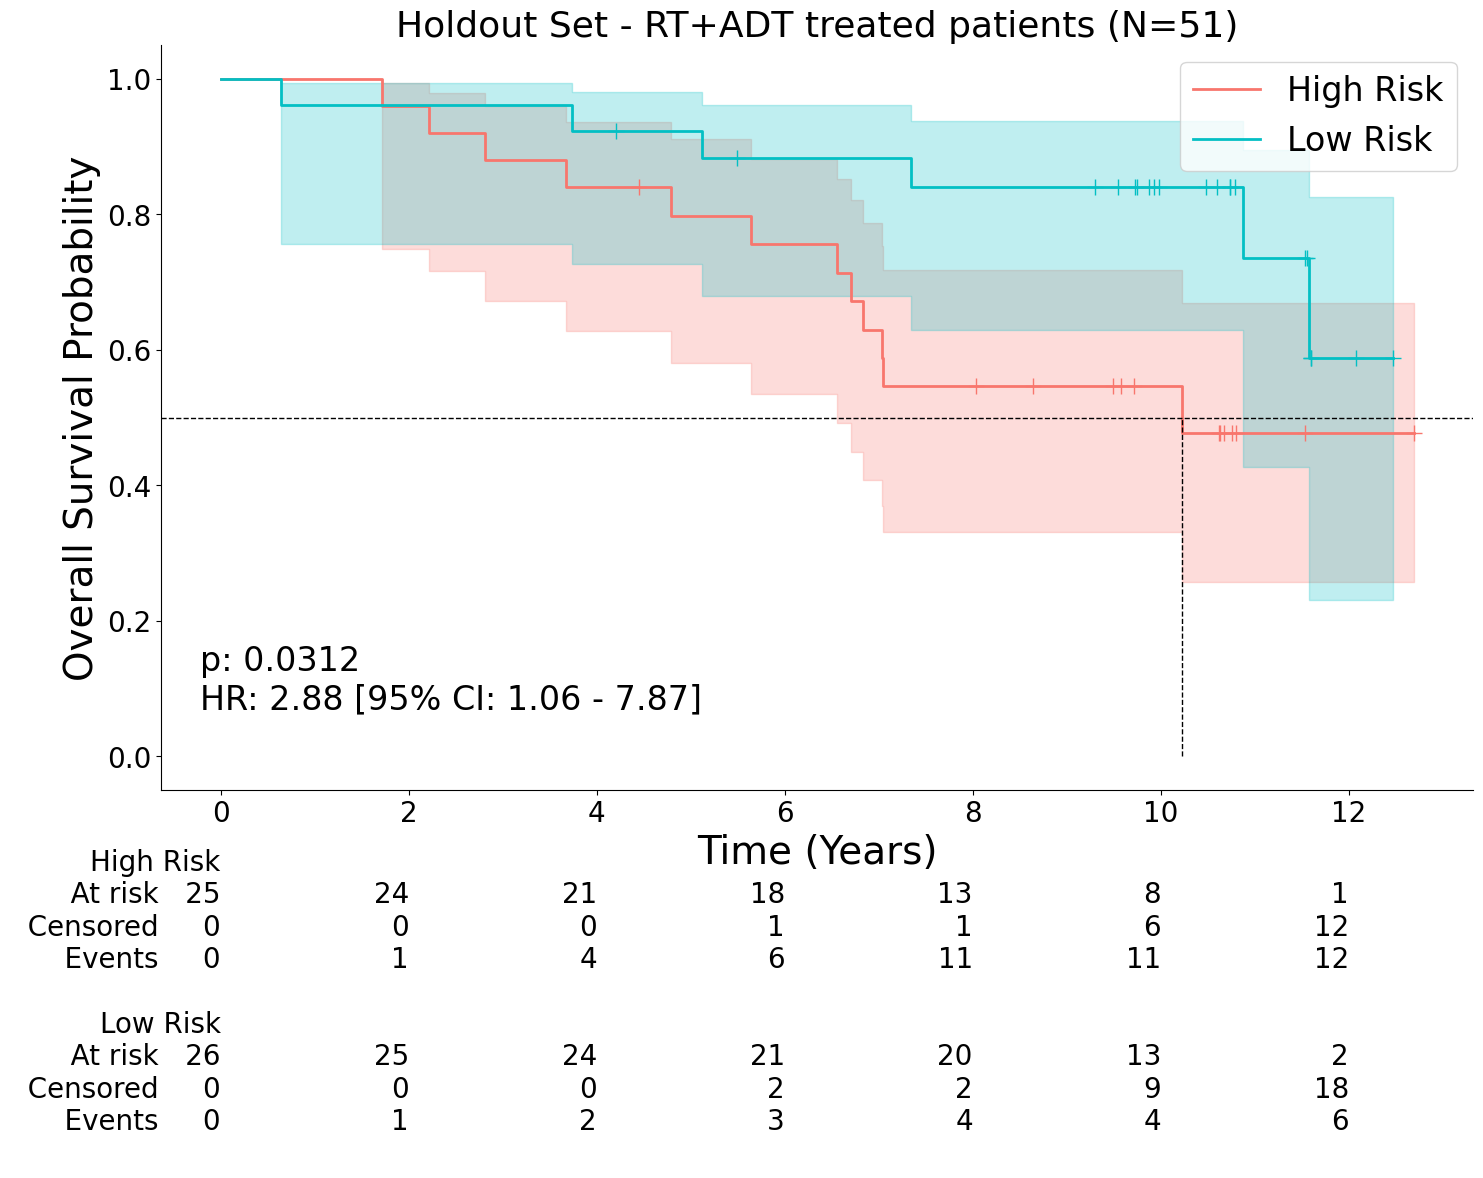

In [170]:
# plot the KM curve for the holdout data

holdout_title_str = 'Holdout Set - RT+ADT treated patients (N={:d})'.format(len(y_holdout))
holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_holdout, holdout_data_stats, holdout_figure_save_path, holdout_title_str)

### Checking selected feature distributions

60


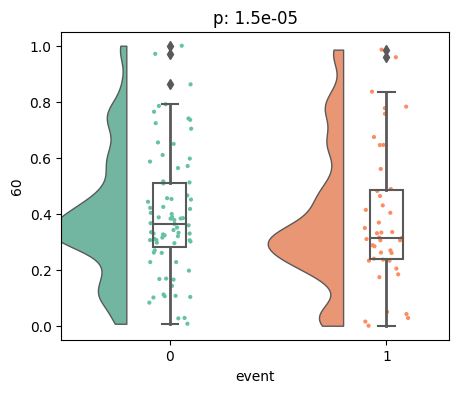

2896


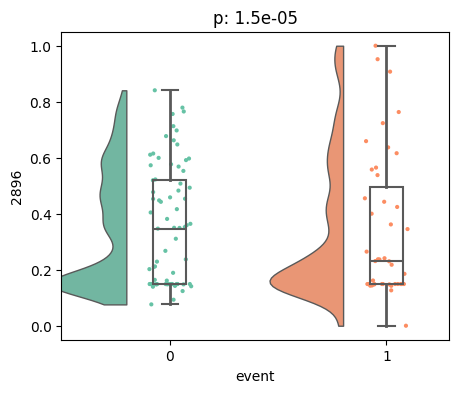

1992


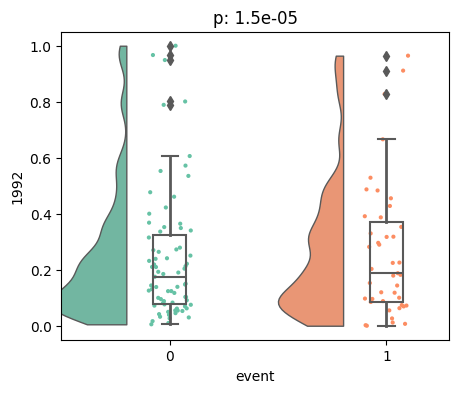

870


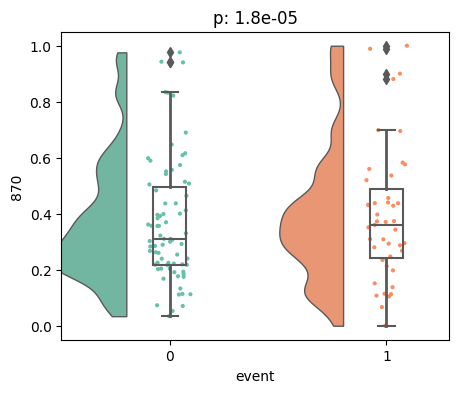

833


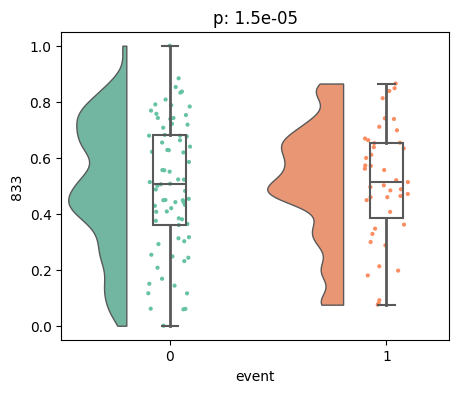

1452


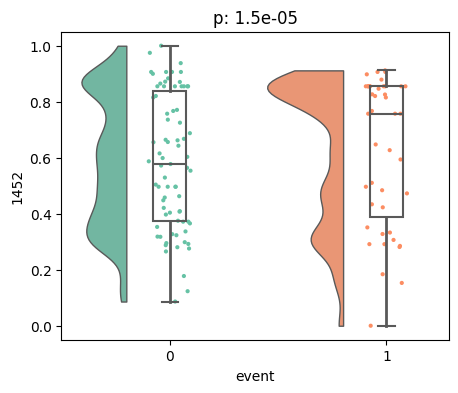

2095


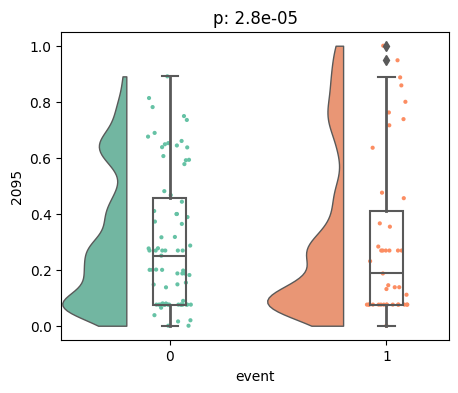

1248


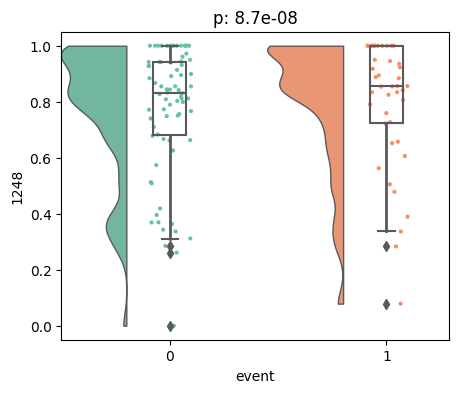

360


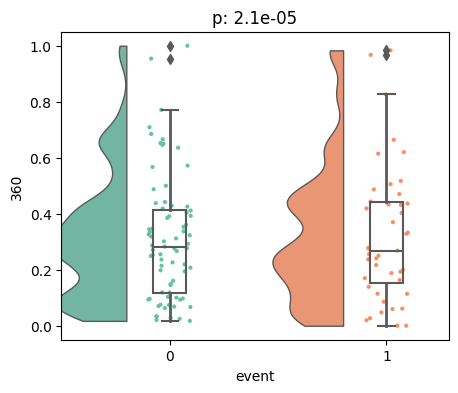

18


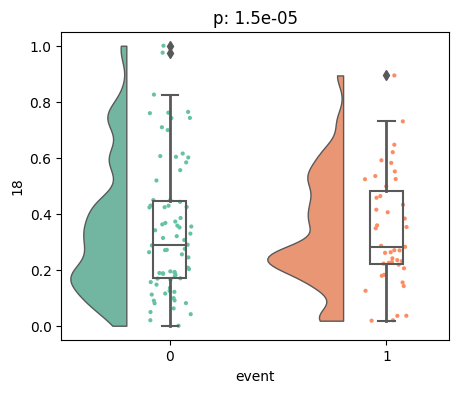

1246


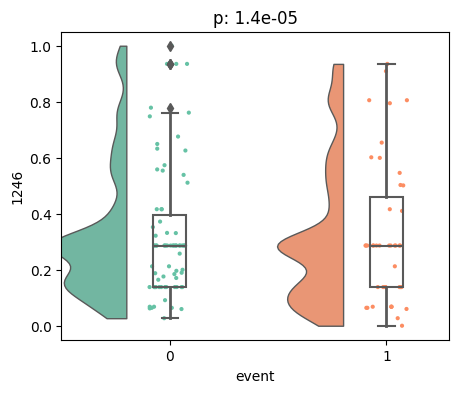

1720


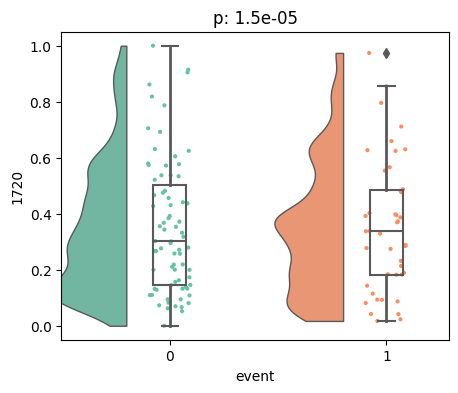

2131


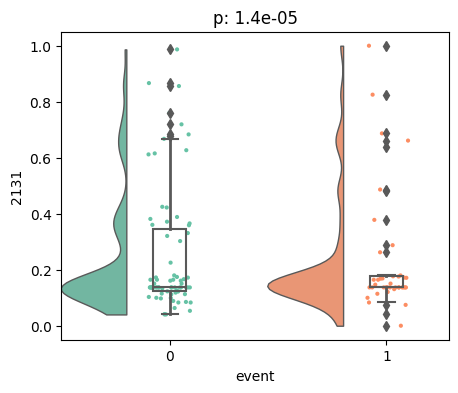

293


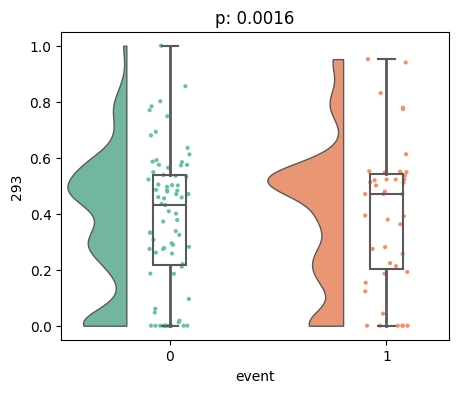

2046


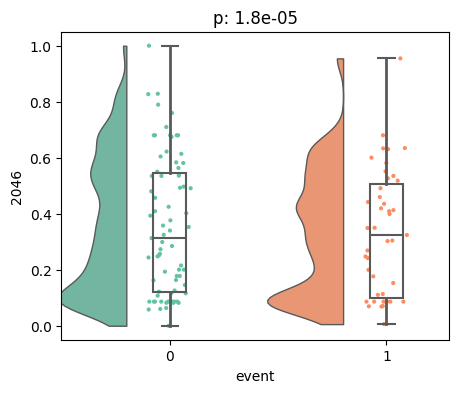

In [171]:
for i, feature in enumerate(X_training_trimmed):
    pvalue = mannwhitneyu(X_training_trimmed[feature], y_training['event']).pvalue
    print(feature)
    plt.figure(figsize=(5,4))
    pt.RainCloud(x=rtog_features['event'], y=X_training_trimmed[feature])
    plt.title(f'p: {pvalue:.2}')
    plt.show()

## Test on treatment group

In [172]:
rtog_leg_2 = rtog_features.loc[rtog_features['RX'] == 2]

In [173]:
rtog_leg_2['event'].value_counts()

event
0    128
1     53
Name: count, dtype: int64

In [174]:
rtog_leg_2

,0,1,2,3,4,5,6,7,8,9,...,3258,3259,3260,3261,3262,3263,patient_id,RX,time,event
0,0.192287,0.004279,0.697494,0.097045,0.182623,0.077568,0.112977,0.292100,0.376318,0.090770,...,0.050884,0.036782,0.049587,-0.551706,7.328611,0.127979,0521-237186,2,12.569863,0
1,0.183406,0.003318,0.679519,0.031302,0.167300,0.066667,0.111111,0.260870,0.377565,0.073365,...,0.048161,0.032509,0.046532,-0.636756,3.412928,0.114572,0521-972417,2,12.673973,0
5,0.166123,0.002241,0.675042,0.051881,0.157623,0.088132,0.121857,0.236927,0.295931,0.054705,...,0.045991,0.036427,0.043230,-0.514181,2.940450,0.121349,0521-225072,2,6.144105,1
6,0.232115,0.006289,0.145831,-1.271689,0.229219,0.137566,0.155556,0.313801,0.351656,0.127791,...,0.053171,0.042026,0.052209,-0.639128,1.554782,0.119481,0521-356209,2,12.649315,0
8,0.183075,0.004214,0.549383,-0.523328,0.166667,0.027778,0.111111,0.282418,0.350649,0.103571,...,0.056785,0.044338,0.056181,-0.544996,3.924220,0.138695,0521-898902,2,12.876712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,0.223753,0.006569,0.387581,-0.759015,0.214286,0.040000,0.125000,0.342629,0.449561,0.123355,...,0.050083,0.036007,0.049386,-0.566640,43.099618,0.126204,0521-099200,2,9.506849,0
338,0.237655,0.007081,0.417134,-0.693582,0.228571,0.093023,0.142857,0.373272,0.449653,0.126375,...,0.061354,0.042594,0.059121,-0.696436,11.042241,0.136921,0521-798508,2,9.632877,0
342,0.238806,0.009119,-0.704716,-1.115307,0.291892,0.066667,0.088736,0.328857,0.340000,0.172596,...,0.039639,0.026028,0.039225,-0.503291,0.219502,0.110429,0521-506251,2,9.317808,0
346,0.203703,0.005766,0.701701,-0.246077,0.186207,0.060606,0.111111,0.321429,0.432990,0.107635,...,0.051949,0.036738,0.049265,-0.646035,30.053092,0.122095,0521-227777,2,9.731507,0


In [175]:
X_holdout_decipher = rtog_leg_2.drop(['patient_id', 'event', 'time'], axis=1).reset_index(drop=True)
y_holdout_decipher = rtog_leg_2[['patient_id','event', 'time']].reset_index(drop=True)
X_holdout_decipher = pd.DataFrame(scaler.transform(X_holdout_decipher), columns=X_holdout_decipher.columns)
X_holdout_decipher_trimmed = X_holdout_decipher[X_training_trimmed.columns]

In [176]:
y_holdout_decipher_survlabel = Surv.from_dataframe('event', 'time', y_holdout_decipher)

In [177]:
X_holdout_decipher_trimmed

,60,2896,1992,870,833,1452,2095,1248,360,18,1246,1720,2131,293,2046
0,0.537418,0.355104,0.298472,0.237243,0.579663,0.404054,0.260878,0.863376,0.372737,0.572174,0.466593,0.296837,0.216371,0.196235,0.232555
1,0.095738,0.154965,0.255237,0.356238,0.795078,0.505607,0.079519,0.883893,0.479673,0.274127,0.517027,0.142785,0.138553,0.283736,0.366427
2,0.668713,0.813394,0.086468,0.404519,0.377838,0.940551,0.332199,0.677563,0.110035,0.613428,0.537666,0.108260,0.895799,0.053859,0.353692
3,0.555440,0.511497,0.231882,0.366582,0.230792,0.294611,0.215333,0.903948,0.178655,0.033748,0.434912,0.150813,0.170065,0.667639,0.250603
4,0.329281,0.593978,0.252365,0.347112,0.485520,0.215867,0.366564,1.000000,0.286055,0.479306,0.416107,0.497634,0.276354,0.114704,0.086055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.511731,0.557659,0.187400,0.281488,1.079031,0.305042,0.283240,0.694825,0.495032,0.208189,0.067821,0.350626,0.138553,0.574544,0.666289
177,0.488786,0.639230,0.104035,0.259018,0.640346,0.687659,0.203666,0.726806,0.221805,0.178069,0.067821,0.158983,0.138553,0.692752,0.491099
178,0.987602,0.130060,-0.008853,0.151831,0.510049,0.803351,0.797474,0.882858,0.026947,0.519406,0.416107,0.038032,0.405602,0.869580,0.086055
179,0.300571,0.223626,0.277387,0.569337,1.002329,0.855054,0.079519,0.541921,0.690034,0.404779,0.286353,0.378619,0.101075,0.490742,0.680119


In [178]:
holdout_decipher_risk_scores = coxnet_pred.predict(X_holdout_decipher_trimmed)

In [179]:
decipher_events, decipher_times = y_holdout_decipher['event'].values.astype(bool), y_holdout_decipher['time'].values
coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

holdout_decipher_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in holdout_decipher_risk_scores])
holdout_decipher_survival_probs = []
holdout_decipher_survival_times = []

for group_label in np.unique(holdout_decipher_risk_group_labels):
    group_indices = np.where(holdout_decipher_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(decipher_events[group_indices], decipher_times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)


In [180]:
results = logrank_test(decipher_times[holdout_decipher_risk_group_labels==0], decipher_times[holdout_decipher_risk_group_labels==1], decipher_events[holdout_decipher_risk_group_labels==0], decipher_events[holdout_decipher_risk_group_labels==1])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.04 0.85      0.23

In [181]:
decipher_results = multivariate_logrank_test(decipher_times, holdout_decipher_risk_group_labels, decipher_events)
decipher_results.p_value

0.8502283832483293

In [182]:
y_holdout_decipher['risk_score'] = holdout_decipher_risk_scores
y_holdout_decipher['risk_group'] = holdout_decipher_risk_group_labels
y_holdout_decipher['patient_id'] = y_holdout_decipher['patient_id']
y_holdout_decipher = y_holdout_decipher.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout_decipher

,patient_id,event,time,risk_score,risk_group
0,0521-024492,0,9.430781,0.605664,1
1,0521-031363,0,10.636477,0.000148,0
2,0521-034934,0,9.490411,0.049188,0
3,0521-039475,0,5.018340,0.060756,0
4,0521-044097,0,9.536986,-0.280513,0
...,...,...,...,...,...
176,0521-972417,0,12.673973,-0.525367,0
177,0521-979111,0,4.619178,-0.613657,0
178,0521-979162,0,12.649315,-0.783629,0
179,0521-998850,0,10.612606,-0.902397,0


In [183]:
#y_holdout_decipher.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/leg2_holdout_survival_risk_scores_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_top_1.csv', index=False)

In [184]:
print("Metrics for RTOG treatment leg cohort")
coxnet_pred = gcv.best_estimator_

decipher_holdout_prediction = coxnet_pred.predict(X_holdout_decipher_trimmed)

decipher_holdout_survival = coxnet_pred.predict_survival_function(X_holdout_decipher_trimmed)
times_holdout_decipher = np.arange(int(np.min(y_holdout_decipher_survlabel['time'])), int(np.max(y_holdout_decipher_survlabel["time"])))
survival_prediction_holdout_decipher = np.asarray([[fn(t) for t in times_holdout_decipher] for fn in decipher_holdout_survival])

c_index_holdout = concordance_index_censored(y_holdout_decipher_survlabel["event"], y_holdout_decipher_survlabel["time"], decipher_holdout_prediction)
print('C-index on Holdout set: {:.3f}'.format(c_index_holdout[0]))

c_ipcw_holdout = concordance_index_ipcw(y_training_survlabel, y_holdout_decipher_survlabel, decipher_holdout_prediction)
print('IPCW C-index on Holdout set: {:.3f}'.format(c_ipcw_holdout[0]))

# ibs_holdout = integrated_brier_score(y_training_survlabel, y_holdout_decipher_survlabel, survival_prediction_holdout_decipher, times_holdout_decipher)
# print('IBS on Holdout set: {:.3f}'.format(ibs_holdout))

# create a dataframe to store the model type and c-index
model_metrics_decipher = pd.DataFrame()
model_metrics_decipher['cohort'] = ["Decipher"]
model_metrics_decipher['c_index_holdout'] = [c_index_holdout[0]]
model_metrics_decipher['c_index_ipcw_holdout'] = [c_ipcw_holdout[0]]
model_metrics_decipher['integrated_brier_score_holdout'] = [0]

Metrics for RTOG treatment leg cohort
C-index on Holdout set: 0.531
IPCW C-index on Holdout set: 0.569


In [185]:

LL_holdout_decipher = y_holdout_decipher.drop(['patient_id', 'risk_score'], axis=1)
cph_holdout_decipher = CoxPHFitter()
cph_holdout_decipher.fit(LL_holdout_decipher, duration_col='time', event_col='event', show_progress=False)

decipher_holdout_results = cph_holdout_decipher.summary
decipher_holdout_p = multivariate_logrank_test(y_holdout_decipher['time'], y_holdout_decipher['risk_group'], y_holdout_decipher['event']).p_value # holdout_results['p'].values[0]
decipher_holdout_hr = decipher_holdout_results['exp(coef)'].values[0]
decipher_holdout_ci_lower = decipher_holdout_results['exp(coef) lower 95%'].values[0]
decipher_holdout_ci_upper = decipher_holdout_results['exp(coef) upper 95%'].values[0]
decipher_holdout_log_likelihood = cph_holdout_decipher.log_likelihood_
model_metrics_decipher['holdout_p_value'] = [decipher_holdout_p]
model_metrics_decipher['holdout_hazard_ratio'] = [decipher_holdout_hr]
model_metrics_decipher['holdout_hr_ci_lower'] = [decipher_holdout_ci_lower]
model_metrics_decipher['holdout_hr_ci_upper'] = [decipher_holdout_ci_upper]
model_metrics_decipher['holdout_log_likelihood'] = [decipher_holdout_log_likelihood]
model_metrics_decipher['holdout_parameters'] = [cph_holdout_decipher.params_.shape[0]]

decipher_holdout_data_stats = (decipher_holdout_p, decipher_holdout_hr, decipher_holdout_ci_lower, decipher_holdout_ci_upper)

In [186]:
cph_holdout_decipher.score(LL_holdout, scoring_method='log_likelihood')

-1.234408659965755

In [187]:
cph_holdout_decipher.print_summary()

<lifelines.CoxPHFitter: fitted with 181 total observations, 128 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 181
number of events observed = 53
   partial log-likelihood = -249.79
         time fit was run = 2024-05-07 21:25:08 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
risk_group  0.05      1.06      0.29           -0.51            0.62                0.60                1.86

            cmp to    z    p  -log2(p)
covariate                             
risk_group    0.00 0.19 0.85      0.23
---
Concordance = 0.50
Partial AIC = 501.59
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.23

In [188]:
LL_holdout_decipher

,event,time,risk_group
0,0,9.430781,1
1,0,10.636477,0
2,0,9.490411,0
3,0,5.018340,0
4,0,9.536986,0
...,...,...,...
176,0,12.673973,0
177,0,4.619178,0
178,0,12.649315,0
179,0,10.612606,0


C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\2546873751.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\2546873751.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  12.12876712


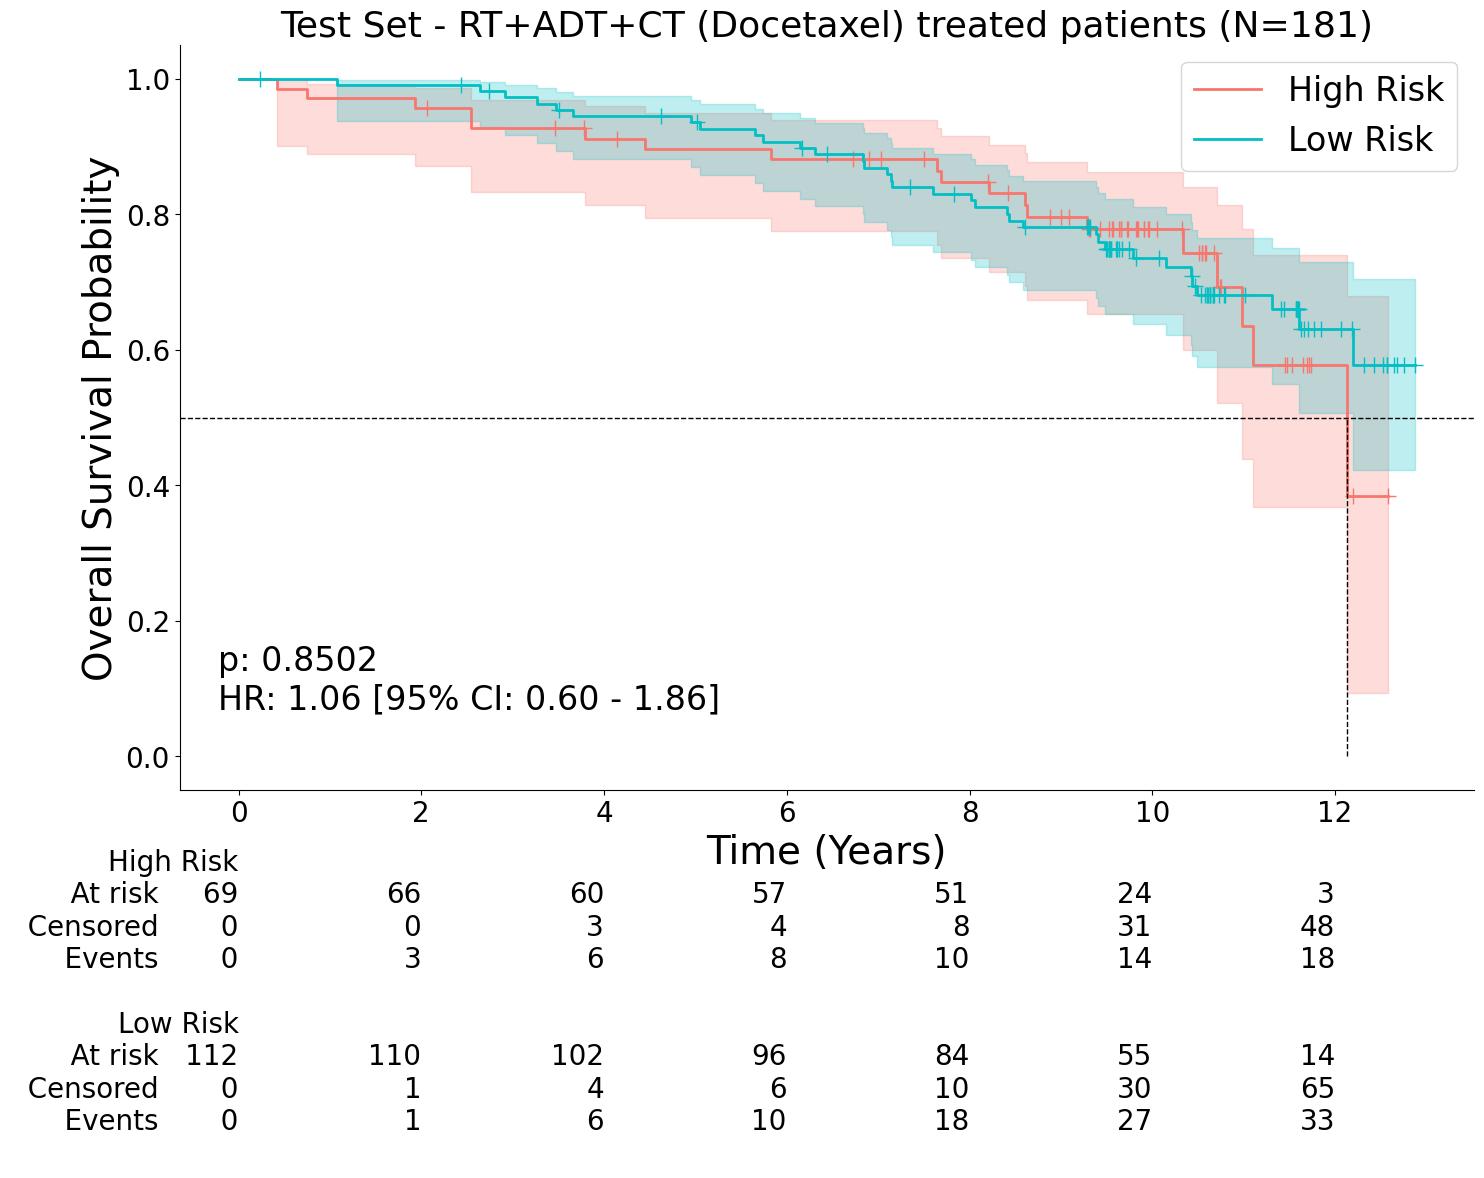

In [189]:
decipher_holdout_title_str = 'Test Set - RT+ADT+CT (Docetaxel) treated patients (N={:d})'.format(len(y_holdout_decipher))
decipher_holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_Decipher_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}.png'
plot_km_curve_lifelines(y_holdout_decipher, decipher_holdout_data_stats, decipher_holdout_figure_save_path, decipher_holdout_title_str)

60


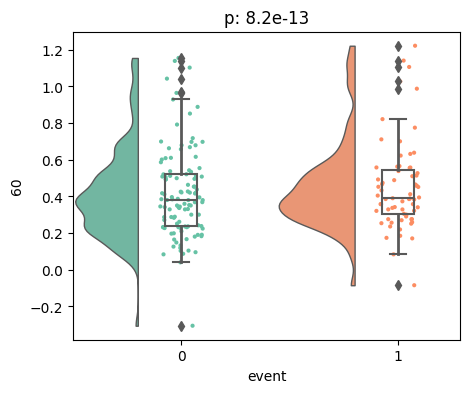

2896


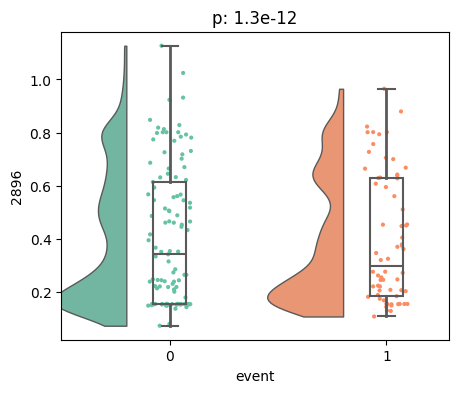

1992


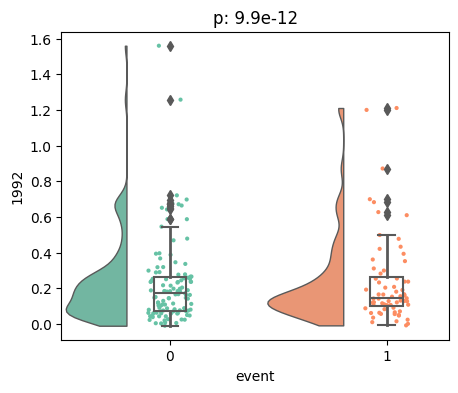

870


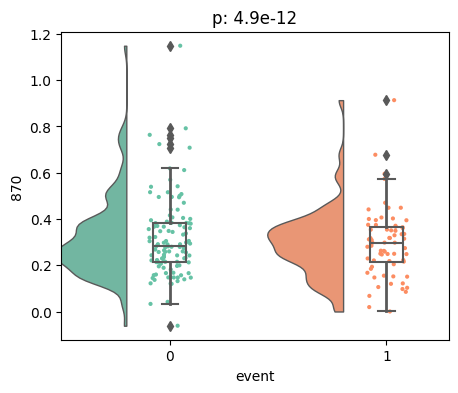

833


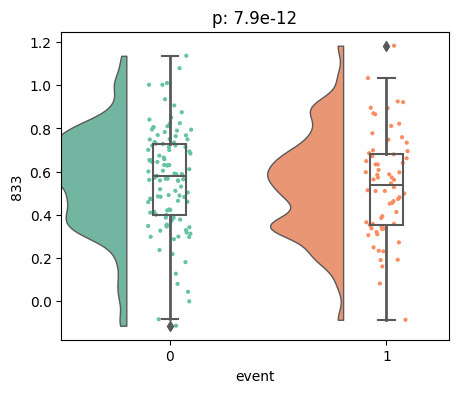

1452


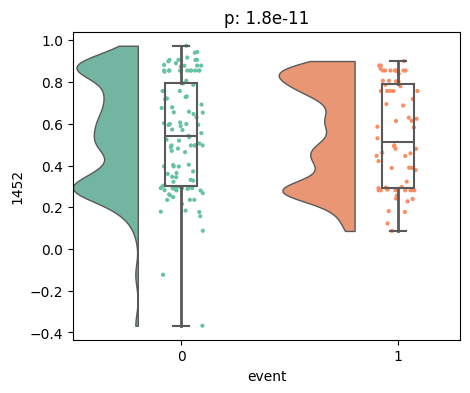

2095


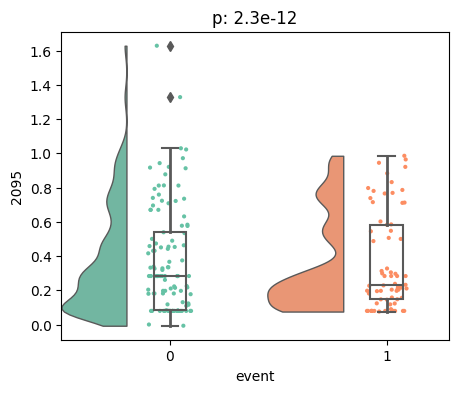

1248


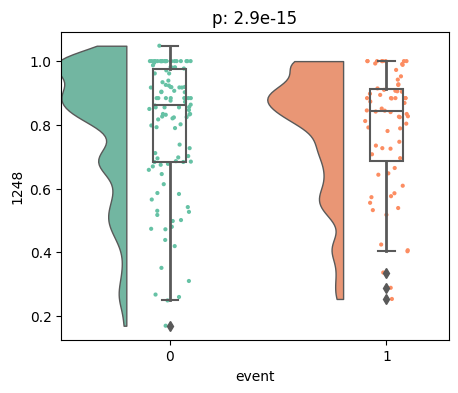

360


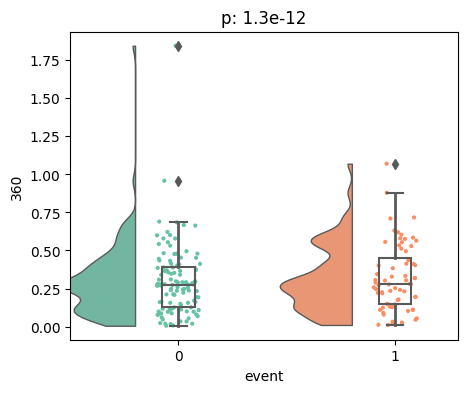

18


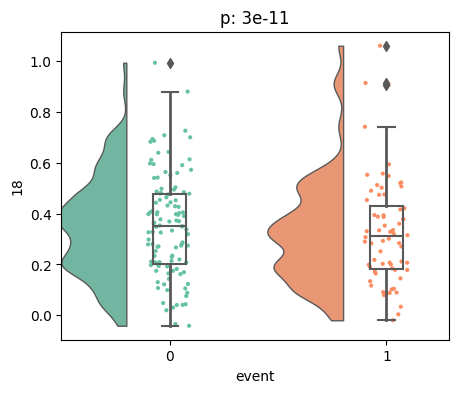

1246


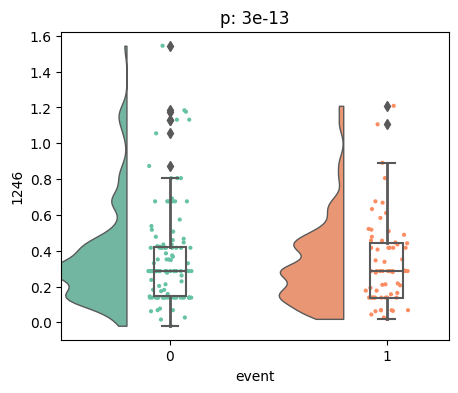

1720


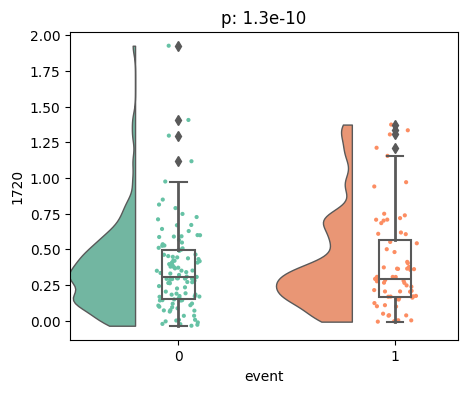

2131


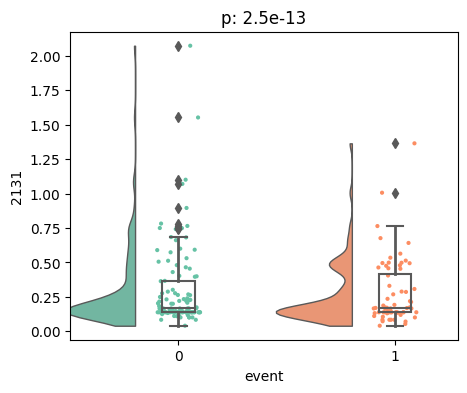

293


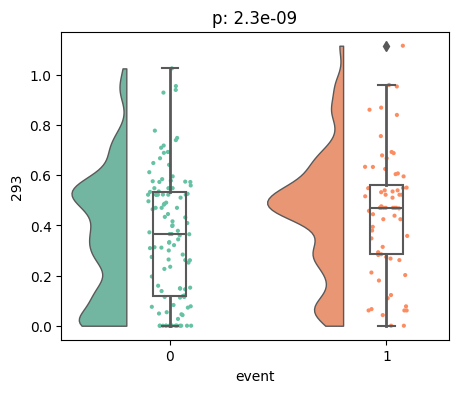

2046


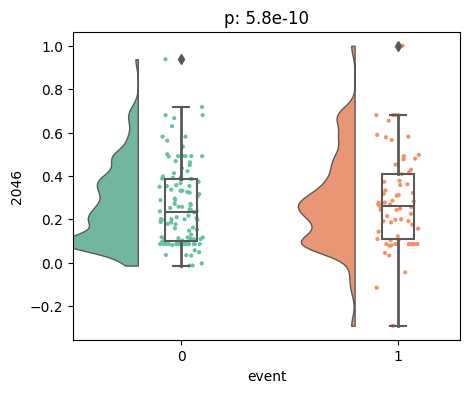

In [190]:
# decipher_features = decipher_features_df.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
# decipher_features = pd.DataFrame(scaler.transform(decipher_features), columns=decipher_features.columns)
# decipher_features = pd.concat([decipher_features_df[['patient_id','event', 'time']], decipher_features], axis=1)

for i, feature in enumerate(X_holdout_decipher_trimmed):
    pvalue = mannwhitneyu(X_holdout_decipher_trimmed[feature], y_holdout_decipher['event']).pvalue
    print(feature)
    plt.figure(figsize=(5,4))
    pt.RainCloud(x=rtog_features['event'], y=X_holdout_decipher_trimmed[feature])
    plt.title(f'p: {pvalue:.2}')
    plt.show()

## UMAP visualization of features

In [191]:
disparity_features = rtog_leg_1.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
decipher_features = rtog_leg_2.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)

In [192]:
disparity_events = rtog_leg_1['event'].values
decipher_events = rtog_leg_2['event'].values

In [193]:
import umap

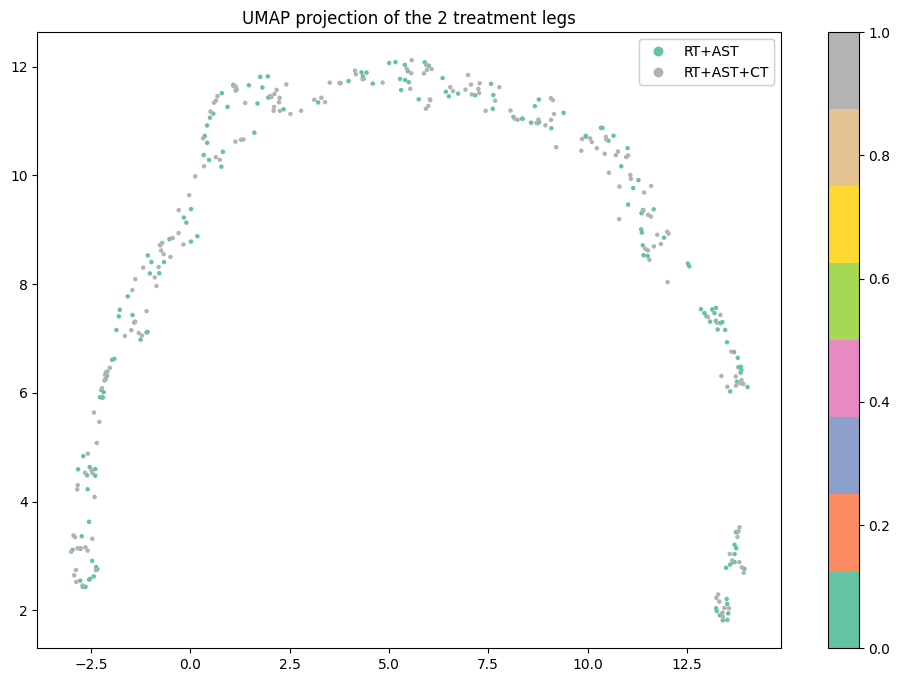

In [194]:
dataset1 = disparity_features.to_numpy()
dataset2 = decipher_features.to_numpy()

# Combine the datasets into a single dataset
combined_data = np.vstack([dataset1, dataset2])

# Create labels for each cohort to color them differently
labels = np.array([0]*len(dataset1) + [1]*len(dataset2))

# Initialize UMAP
reducer = umap.UMAP()

# Fit the model to the combined dataset and transform it
embedding = reducer.fit_transform(combined_data)

# Plotting
combined_labels = np.concatenate([disparity_events, decipher_events])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Set2', s=5)
plt.colorbar()
plt.title('UMAP projection of the 2 treatment legs')
cohorts = ['RT+AST', 'RT+AST+CT']
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=cohorts)
plt.gca().add_artist(legend1)

plt.show()

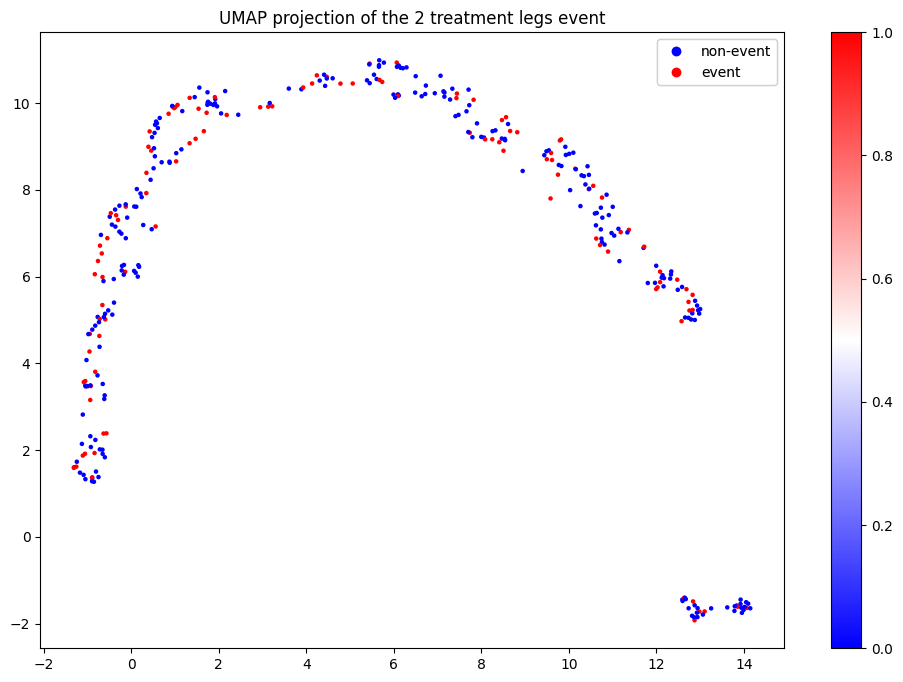

In [195]:
# Combine the datasets into a single dataset
combined_data = np.vstack([dataset1, dataset2])

# Create labels for each cohort to color them differently
labels = np.array([0]*len(dataset1) + [1]*len(dataset2))

# Initialize UMAP
reducer = umap.UMAP()

# Fit the model to the combined dataset and transform it
embedding = reducer.fit_transform(combined_data)

# Plotting
combined_labels = np.concatenate([disparity_events, decipher_events])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=combined_labels, cmap='bwr', s=5)
plt.colorbar()
plt.title('UMAP projection of the 2 treatment legs event')
cohorts = ['UPenn Disparity', 'Upenn Decipher']
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=['non-event', 'event'])
plt.gca().add_artist(legend1)

plt.show()

### Favorable outcome patients from both arms

In [196]:
chemo_favorable_risk = y_holdout_decipher[y_holdout_decipher['risk_group'] == 0]

In [197]:
chemo_favorable_risk

,patient_id,event,time,risk_score,risk_group
1,0521-031363,0,10.636477,0.000148,0
2,0521-034934,0,9.490411,0.049188,0
3,0521-039475,0,5.018340,0.060756,0
4,0521-044097,0,9.536986,-0.280513,0
7,0521-051253,0,3.506849,-0.269780,0
...,...,...,...,...,...
176,0521-972417,0,12.673973,-0.525367,0
177,0521-979111,0,4.619178,-0.613657,0
178,0521-979162,0,12.649315,-0.783629,0
179,0521-998850,0,10.612606,-0.902397,0


In [198]:
chemo_favorable_risk['chemo'] = 1

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\1183860258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_favorable_risk['chemo'] = 1


In [199]:
no_chemo_favorable_risk = y_holdout[y_holdout['risk_group'] == 0]

In [200]:
no_chemo_favorable_risk['chemo'] = 0

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\765330259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_favorable_risk['chemo'] = 0


In [201]:
no_chemo_favorable_risk

,patient_id,event,time,risk_score,risk_group,chemo
0,0521-011235,0,10.736986,-1.141965,0,0
1,0521-029609,0,11.534247,-0.110413,0,0
2,0521-031663,0,9.978082,-0.248779,0,0
4,0521-061104,0,11.600000,-1.070910,0,0
6,0521-120451,0,11.597260,-0.087718,0,0
7,0521-120891,0,12.071233,-0.473601,0,0
10,0521-148325,0,9.928767,-0.773603,0,0
11,0521-171165,1,3.736986,-1.738376,0,0
12,0521-173436,1,10.870245,-0.481069,0,0
16,0521-297561,1,7.339726,-1.074065,0,0


In [202]:
# join dfs
favorable_risk = pd.concat([chemo_favorable_risk, no_chemo_favorable_risk])

In [203]:
favorable_risk

,patient_id,event,time,risk_score,risk_group,chemo
1,0521-031363,0,10.636477,0.000148,0,1
2,0521-034934,0,9.490411,0.049188,0,1
3,0521-039475,0,5.018340,0.060756,0,1
4,0521-044097,0,9.536986,-0.280513,0,1
7,0521-051253,0,3.506849,-0.269780,0,1
...,...,...,...,...,...,...
39,0521-764110,0,11.556164,-0.890698,0,0
46,0521-907614,1,0.637615,-0.226030,0,0
47,0521-917820,1,5.121514,-0.258882,0,0
49,0521-931689,0,12.468493,-1.746578,0,0


In [204]:
LL_holdout_decipher

,event,time,risk_group
0,0,9.430781,1
1,0,10.636477,0
2,0,9.490411,0
3,0,5.018340,0
4,0,9.536986,0
...,...,...,...
176,0,12.673973,0
177,0,4.619178,0
178,0,12.649315,0
179,0,10.612606,0


In [205]:
LL_holdout_decipher = favorable_risk.drop(['patient_id', 'risk_group', 'risk_score'], axis=1)
cph_holdout_decipher = CoxPHFitter()
cph_holdout_decipher.fit(LL_holdout_decipher, duration_col='time', event_col='event', show_progress=False)

decipher_holdout_results = cph_holdout_decipher.summary
decipher_holdout_p = multivariate_logrank_test(favorable_risk['time'], favorable_risk['chemo'], favorable_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
decipher_holdout_hr = decipher_holdout_results['exp(coef)'].values[0]
decipher_holdout_ci_lower = decipher_holdout_results['exp(coef) lower 95%'].values[0]
decipher_holdout_ci_upper = decipher_holdout_results['exp(coef) upper 95%'].values[0]
decipher_holdout_log_likelihood = cph_holdout_decipher.log_likelihood_
model_metrics_decipher['holdout_p_value'] = [decipher_holdout_p]
model_metrics_decipher['holdout_hazard_ratio'] = [decipher_holdout_hr]
model_metrics_decipher['holdout_hr_ci_lower'] = [decipher_holdout_ci_lower]
model_metrics_decipher['holdout_hr_ci_upper'] = [decipher_holdout_ci_upper]
model_metrics_decipher['holdout_log_likelihood'] = [decipher_holdout_log_likelihood]
model_metrics_decipher['holdout_parameters'] = [cph_holdout_decipher.params_.shape[0]]

decipher_holdout_data_stats = (decipher_holdout_p, decipher_holdout_hr, decipher_holdout_ci_lower, decipher_holdout_ci_upper)

In [206]:
decipher_holdout_data_stats

(0.5631837053991251, 1.291477471387574, 0.5413155160412046, 3.0812234448766134)

In [207]:
cph_holdout_decipher.print_summary()

<lifelines.CoxPHFitter: fitted with 138 total observations, 98 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 138
number of events observed = 40
   partial log-likelihood = -179.59
         time fit was run = 2024-05-07 21:25:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
chemo      0.26      1.29      0.44           -0.61            1.13                0.54                3.08

           cmp to    z    p  -log2(p)
covariate                            
chemo        0.00 0.58 0.56      0.83
---
Concordance = 0.54
Partial AIC = 361.17
log-likelihood ratio test = 0.35 on 1 df
-log2(p) of ll-ratio test = 0.86

In [208]:
def plot_km_same_risk_group(data_df1, data_df2, data_stats, figure_save_path, title_str):
    
    # Create a colormap
    cmap = plt.cm.get_cmap('Reds')
    # Choose a shade of red
    hr_shade = cmap(0.75)

    cmap = plt.cm.get_cmap('Blues')
    # Choose a shade of red
    lr_shade = cmap(0.75)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    data_high_risk = data_df1
    data_low_risk = data_df2

    kmf_hr = KaplanMeierFitter()
    kmf_hr.fit(data_high_risk['time'], event_observed=data_high_risk['event'], label='RT+ADT')
    kmf_hr.plot_survival_function(ax=ax, color='#f8766d', lw=2, show_censors=True)

    kmf_lr = KaplanMeierFitter()
    kmf_lr.fit(data_low_risk['time'], event_observed=data_low_risk['event'], label='RT+ADT+CT')
    kmf_lr.plot_survival_function(ax=ax, color='#03bfc4', lw=2, show_censors=True, )
    
    
    print("Low risk median survival time: ",kmf_lr.median_survival_time_)
    print("High risk median survival time: ",kmf_hr.median_survival_time_)
    max_median_survival_time = max(kmf_hr.median_survival_time_ , kmf_lr.median_survival_time_)
    if max_median_survival_time == np.inf:
        plt.axhline(y=0.5, color='black', linestyle='--', lw=1)
    else:
        plt.plot([0, max_median_survival_time], [0.5, 0.5], color='black', linestyle='--', lw=1)
    # Vertical lines up to y=0.5, using plot for precise control
    plt.plot([kmf_hr.median_survival_time_, kmf_hr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    plt.plot([kmf_lr.median_survival_time_, kmf_lr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    ax.set_title(title_str, fontsize=26)

    yticks = [np.round(x,1) for x in ax.get_yticks()]
    ax.set_yticklabels(yticks, fontsize=20)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)


    ax.set_xlabel('Time (Years)', fontsize=28)
    ax.set_ylabel('Overall Survival Probability', fontsize=28)
    data_p, data_hr, data_ci_lower, data_ci_upper = data_stats
    format_p = lambda p: f"{p:.1e}" if p < 0.001 else f"{p:.4f}"

# Updated string formatting
    data_stats_text = f'p: {format_p(data_p)}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    #data_stats_text = f'p: {data_p:.1e if data_p < 0.001 else data_p:.4f}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    ax.text(0.03, 0.1, data_stats_text, transform=ax.transAxes, fontsize=24, verticalalignment='bottom')

    # Add the risk table at the bottom of the KM plot on ax[1] (the bottom subplot)
    sns.despine()
    add_at_risk_counts(kmf_hr, kmf_lr, ax=ax, fontsize=20)
    ax.legend(fontsize=24)
    plt.tight_layout()
    
    #fig.savefig(figure_save_path, bbox_inches='tight')
    plt.show()

In [209]:
risk_threshold

0.06374719940422713

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\3150011259.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\3150011259.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  inf


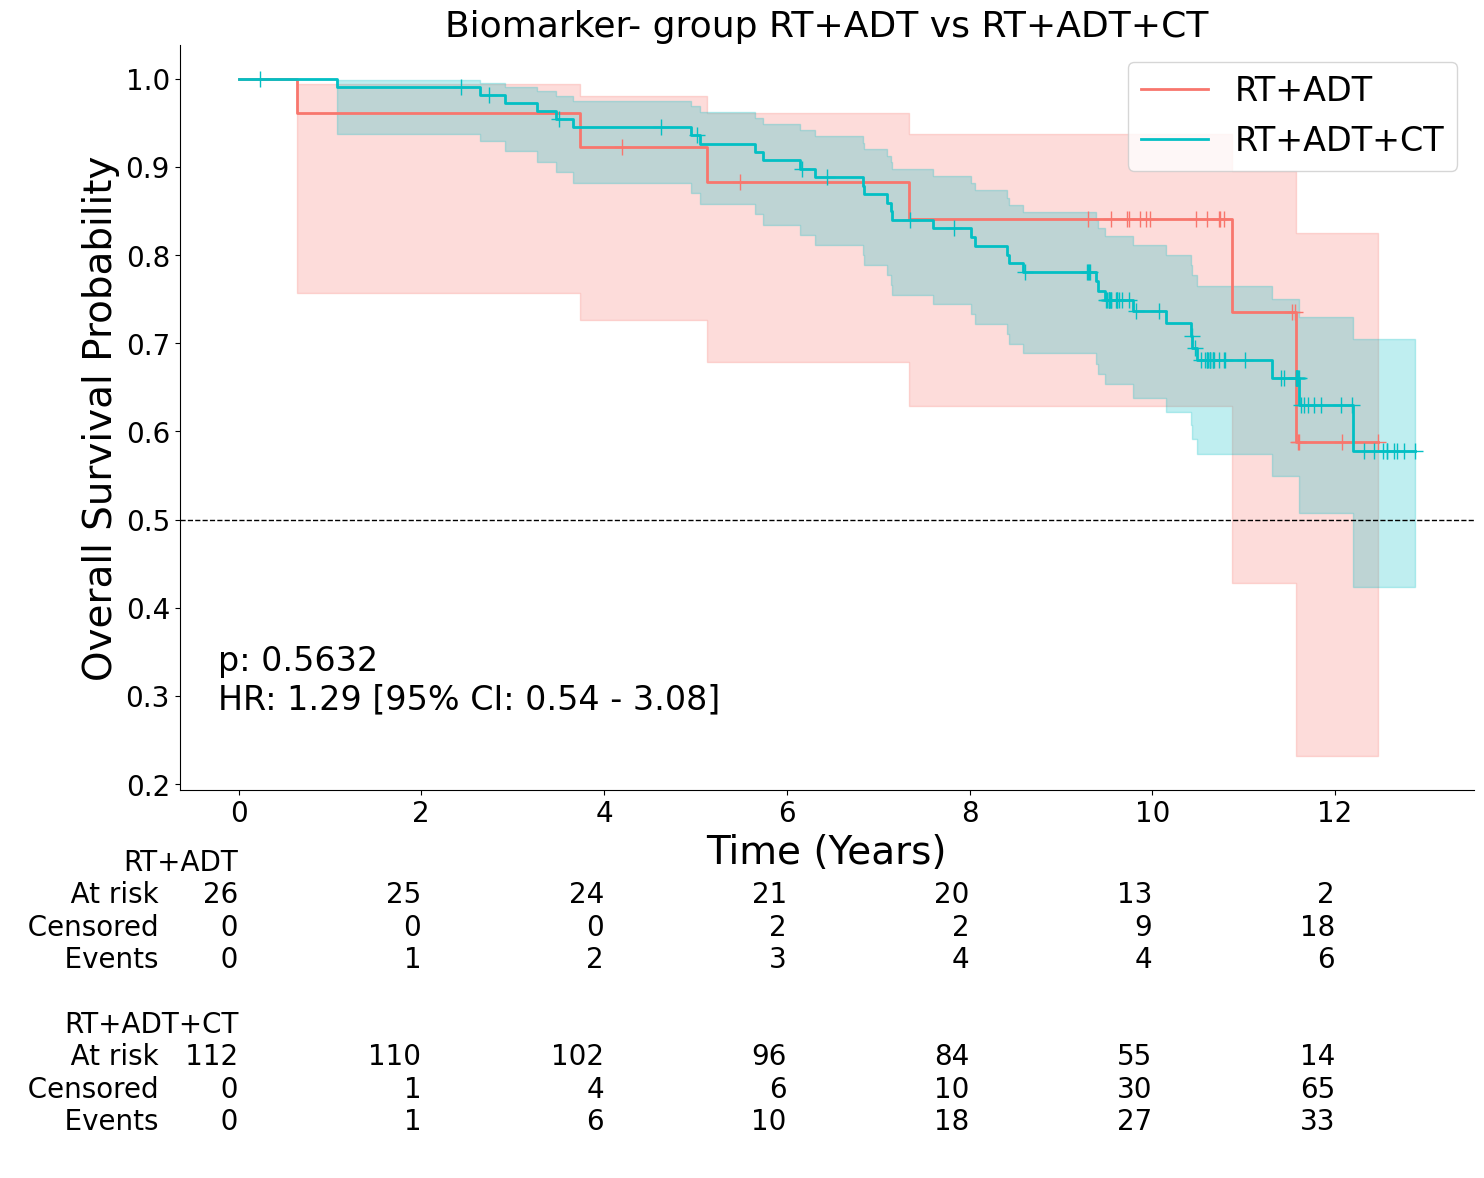

In [210]:
plot_km_same_risk_group(no_chemo_favorable_risk, chemo_favorable_risk, decipher_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/favorable_risk_both_legs_km.png', "Biomarker- group RT+ADT vs RT+ADT+CT")

In [211]:
def calculate_survival_benefit(data_df1, data_df2, time_points=[1,3, 5,7, 10]):
    # Initialize Kaplan-Meier fitters for each group
    kmf_hr = KaplanMeierFitter()  # High risk group
    kmf_lr = KaplanMeierFitter()  # Low risk group

    # Fit data for high risk group
    kmf_hr.fit(data_df1['time'], event_observed=data_df1['event'])

    # Fit data for low risk group
    kmf_lr.fit(data_df2['time'], event_observed=data_df2['event'])

    # Calculate survival probabilities at specified time points
    survival_hr = kmf_hr.survival_function_.reindex(time_points, method='nearest')
    survival_lr = kmf_lr.survival_function_.reindex(time_points, method='nearest')

    # Calculate differences in survival probabilities and format them
    survival_benefits = {}
    for t in time_points:
        prob_hr = kmf_hr.predict(t)
        prob_lr = kmf_lr.predict(t)
        survival_benefit = (prob_lr - prob_hr) * 100  # in percentage points
        survival_benefits[t] = survival_benefit

    return survival_benefits

# Example usage:
# Assuming data_df1 and data_df2 are your dataframes for the two risk groups
benefits = calculate_survival_benefit(no_chemo_favorable_risk, chemo_favorable_risk)
print("Survival Benefits at specified time points:", benefits)


Survival Benefits at specified time points: {1: 3.846153846153877, 3: 1.1184239727497713, 5: 1.266933435510298, 7: -1.3870085994616477, 10: -10.479095749159884}


In [212]:
chemo_bad_risk = y_holdout_decipher[y_holdout_decipher['risk_group'] == 1]
no_chemo_bad_risk = y_holdout[y_holdout['risk_group'] == 1]

In [213]:
chemo_bad_risk['chemo'] = 1

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\2649170415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_bad_risk['chemo'] = 1


In [214]:
no_chemo_bad_risk['chemo'] = 0

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\910245029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_bad_risk['chemo'] = 0


In [215]:
bad_risk = pd.concat([chemo_bad_risk, no_chemo_bad_risk])

In [216]:
LL_holdout_decipher = bad_risk.drop(['patient_id', 'risk_group', 'risk_score'], axis=1)
cph_holdout_decipher = CoxPHFitter()
cph_holdout_decipher.fit(LL_holdout_decipher, duration_col='time', event_col='event', show_progress=False)

decipher_holdout_results = cph_holdout_decipher.summary
decipher_holdout_p = multivariate_logrank_test(bad_risk['time'], bad_risk['chemo'], bad_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
decipher_holdout_hr = decipher_holdout_results['exp(coef)'].values[0]
decipher_holdout_ci_lower = decipher_holdout_results['exp(coef) lower 95%'].values[0]
decipher_holdout_ci_upper = decipher_holdout_results['exp(coef) upper 95%'].values[0]
decipher_holdout_log_likelihood = cph_holdout_decipher.log_likelihood_
model_metrics_decipher['holdout_p_value'] = [decipher_holdout_p]
model_metrics_decipher['holdout_hazard_ratio'] = [decipher_holdout_hr]
model_metrics_decipher['holdout_hr_ci_lower'] = [decipher_holdout_ci_lower]
model_metrics_decipher['holdout_hr_ci_upper'] = [decipher_holdout_ci_upper]
model_metrics_decipher['holdout_log_likelihood'] = [decipher_holdout_log_likelihood]
model_metrics_decipher['holdout_parameters'] = [cph_holdout_decipher.params_.shape[0]]

decipher_holdout_data_stats = (decipher_holdout_p, decipher_holdout_hr, decipher_holdout_ci_lower, decipher_holdout_ci_upper)

In [217]:
decipher_holdout_results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
chemo,-0.73771,0.478208,0.370433,-1.463746,-0.011674,0.231368,0.988394,0.0,-1.991478,0.046428,4.428851


Low risk median survival time:  12.12876712
High risk median survival time:  10.22661127


C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\3150011259.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\3150011259.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


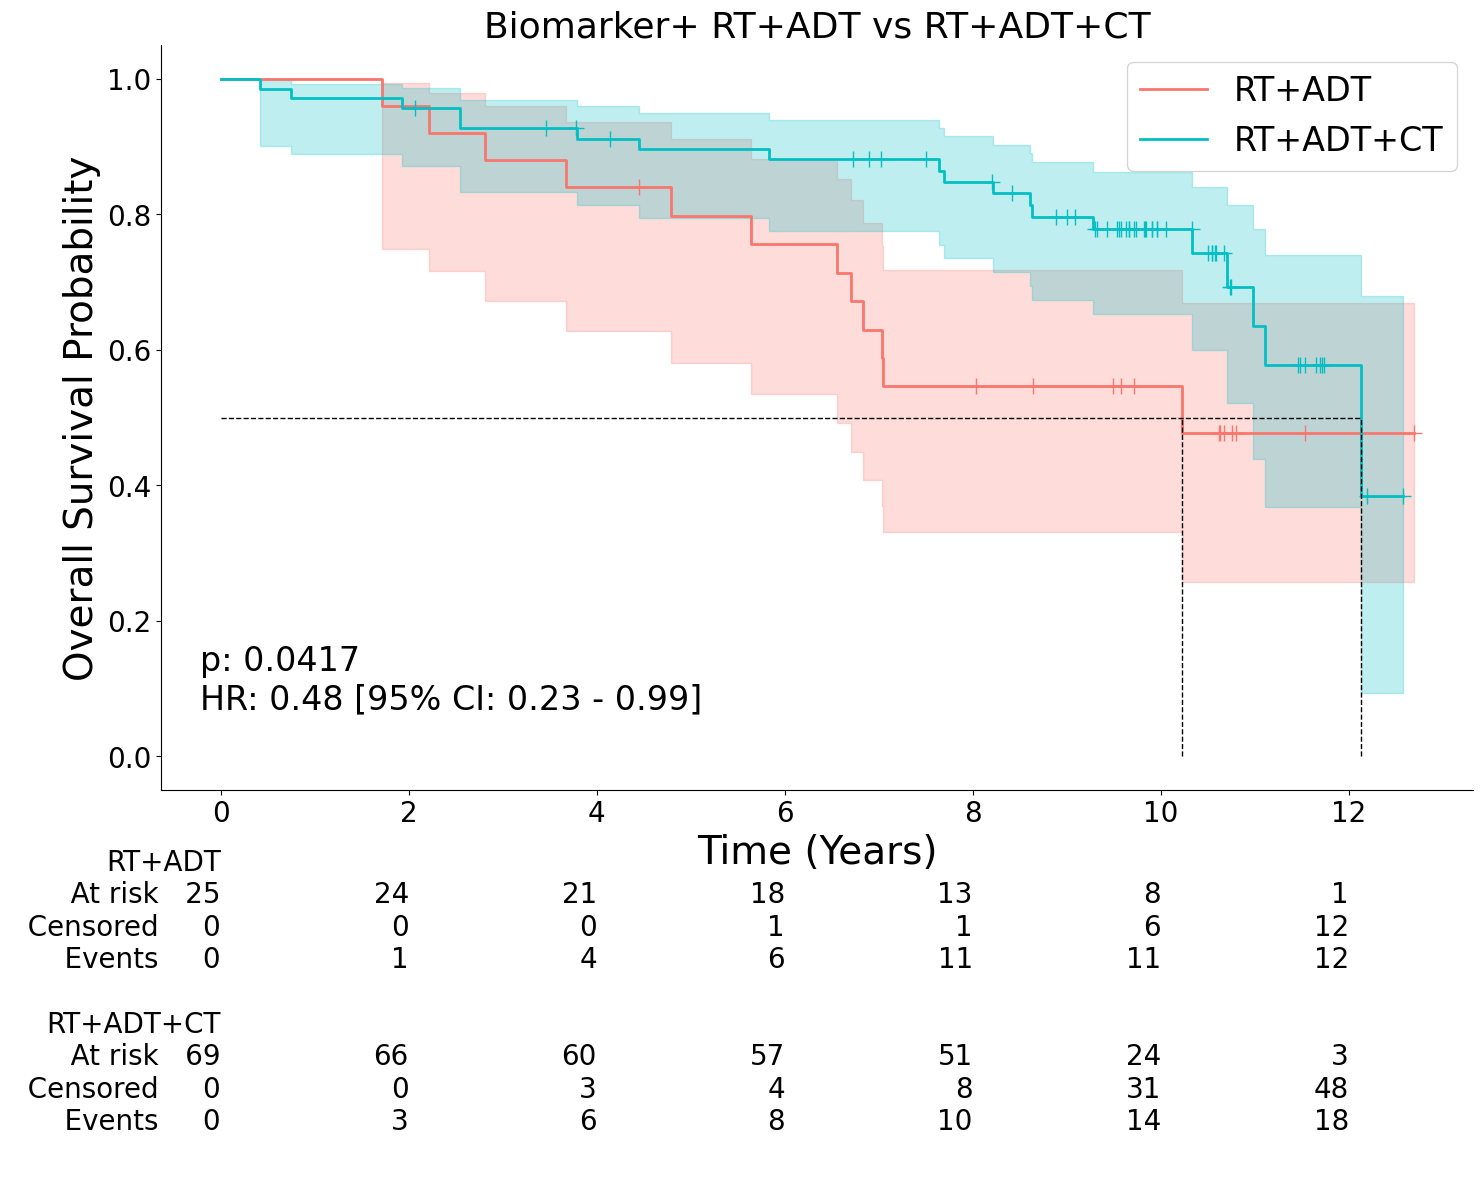

In [218]:
plot_km_same_risk_group(no_chemo_bad_risk, chemo_bad_risk, decipher_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/bad_risk_both_legs_km.png', "Biomarker+ RT+ADT vs RT+ADT+CT")

In [219]:
benefits = calculate_survival_benefit(no_chemo_bad_risk, chemo_bad_risk)
print("Survival Benefits at specified time points:", benefits)

Survival Benefits at specified time points: {1: -2.8985507246377384, 3: 4.7090301003343775, 5: 9.84363010535243, 7: 25.098050275949824, 10: 23.164987823552806}


In [220]:
cph_holdout_decipher.print_summary()

<lifelines.CoxPHFitter: fitted with 94 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 94
number of events observed = 31
   partial log-likelihood = -122.74
         time fit was run = 2024-05-07 21:25:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
chemo     -0.74      0.48      0.37           -1.46           -0.01                0.23                0.99

           cmp to     z    p  -log2(p)
covariate                             
chemo        0.00 -1.99 0.05      4.43
---
Concordance = 0.45
Partial AIC = 247.48
log-likelihood ratio test = 3.69 on 1 df
-log2(p) of ll-ratio test = 4.19

#### interaction term cox model testing

In [222]:
# concatenate all dfs into one
interaction_term_test_df = pd.concat([no_chemo_bad_risk, chemo_bad_risk, no_chemo_favorable_risk, chemo_favorable_risk])

In [223]:
interaction_term_test_df['interaction_term'] = interaction_term_test_df['chemo'] * interaction_term_test_df['risk_group']

In [114]:
# interaction_term_test_df.to_csv('/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/interaction_term_test_df.csv', index=False)

In [224]:
interaction_term_cox = CoxPHFitter()

interaction_term_cox.fit(interaction_term_test_df.drop(['patient_id', 'risk_score'], axis=1), duration_col='time', event_col='event', show_progress=False)
interaction_term_cox_results = interaction_term_cox.summary

In [225]:
interaction_term_test_df

,patient_id,event,time,risk_score,risk_group,chemo,interaction_term
3,0521-032790,1,2.810959,0.246811,1,0,0
5,0521-061895,0,4.449315,0.749790,1,0,0
8,0521-123562,0,10.625810,1.051016,1,0,0
9,0521-140656,0,9.487671,0.737719,1,0,0
13,0521-195042,1,3.674542,0.859777,1,0,0
...,...,...,...,...,...,...,...
176,0521-972417,0,12.673973,-0.525367,0,1,0
177,0521-979111,0,4.619178,-0.613657,0,1,0
178,0521-979162,0,12.649315,-0.783629,0,1,0
179,0521-998850,0,10.612606,-0.902397,0,1,0


In [226]:
interaction_term_cox_results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
risk_group,1.053518,2.867723,0.501294,0.071000,2.036037,1.073581,7.660190,0.0,2.101598,0.035589,4.812444
chemo,0.247636,1.280994,0.443482,-0.621573,1.116845,0.537099,3.055201,0.0,0.558390,0.576578,0.794412
interaction_term,-1.000689,0.367626,0.577178,-2.131938,0.130560,0.118607,1.139466,0.0,-1.733761,0.082961,3.591430


In [227]:
endpoints = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\data\nuclear_diversity_features_RTOG_0521\RTOG_0521_nucdiv_features_all_events_time_in_tumor.csv", index_col=0)


In [228]:
endpoints

,cn_deidentified,0,1,2,3,4,5,6,7,8,...,survival_years,disease_free_survival,disease_free_survival_years,any_distant_mets,any_distant_mets_years,local_failure,local_failure_years,biochemical_failure,biochemical_failure_years,RX
0,0521-237186,0.192287,0.004279,0.697494,0.097045,0.182623,0.077568,0.112977,0.292100,0.376318,...,12.569863,1,11.515068,0,12.569863,2,11.515068,1,11.515068,2
1,0521-972417,0.183406,0.003318,0.679519,0.031302,0.167300,0.066667,0.111111,0.260870,0.377565,...,12.673973,1,3.676712,1,3.838356,2,3.676712,1,3.676712,2
2,0521-641497,0.209265,0.006417,0.596625,-0.611042,0.190372,0.080987,0.120370,0.329351,0.411542,...,12.783562,1,5.586301,1,5.586301,2,5.586301,2,5.586301,1
3,0521-650593,0.244049,0.008786,0.245951,-1.051578,0.244071,0.111111,0.111111,0.372867,0.440574,...,5.682192,1,5.682192,2,5.682192,2,5.682192,2,5.682192,1
4,0521-931689,0.164540,0.002974,0.986191,1.055549,0.153846,0.052632,0.111111,0.243740,0.390097,...,12.468493,0,12.468493,0,12.468493,0,12.468493,0,12.468493,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0521-785941,0.181409,0.004535,0.742296,0.015865,0.166667,0.040000,0.111111,0.285492,0.402062,...,9.619178,0,9.619178,0,9.619178,0,9.619178,0,9.619178,1
346,0521-227777,0.203703,0.005766,0.701701,-0.246077,0.186207,0.060606,0.111111,0.321429,0.432990,...,9.731507,0,9.731507,0,9.731507,0,9.731507,0,9.731507,2
347,0521-225186,0.200383,0.005076,0.837913,0.072707,0.181818,0.086957,0.125000,0.310682,0.445893,...,4.794521,1,4.794521,2,4.794521,2,4.794521,2,4.794521,1
348,0521-601511,0.227509,0.007270,0.468871,-0.684061,0.214286,0.055556,0.125000,0.352457,0.450161,...,7.690411,1,7.690411,2,7.690411,2,7.690411,2,7.690411,2


In [229]:
# get disease free survival and disease free survival years from endpoints matchign by cn_deidentified (patient_id, need to rename)
endpoints = endpoints.rename(columns={'cn_deidentified':'patient_id'})
endpoints = endpoints[['patient_id', 'disease_free_survival', 'disease_free_survival_years']]
# filter the endpoints to only include the patients in interaction_Term_df
endpoints = endpoints[endpoints['patient_id'].isin(interaction_term_test_df['patient_id'])]

In [230]:
endpoints.loc[endpoints['disease_free_survival'] == 2, 'disease_free_survival'] = 1

In [231]:
# merge the endpoints with the interaction term df
interaction_term_test_df_dfs = interaction_term_test_df.merge(endpoints, on='patient_id', how='left')

In [232]:
interaction_term_test_df_dfs.drop(columns=['risk_score'], inplace=True)

In [233]:
interaction_term_test_df_dfs

,patient_id,event,time,risk_group,chemo,interaction_term,disease_free_survival,disease_free_survival_years
0,0521-032790,1,2.810959,1,0,0,1,2.402740
1,0521-061895,0,4.449315,1,0,0,0,4.449315
2,0521-123562,0,10.625810,1,0,0,0,10.625810
3,0521-140656,0,9.487671,1,0,0,1,9.271233
4,0521-195042,1,3.674542,1,0,0,1,2.058103
...,...,...,...,...,...,...,...,...
227,0521-972417,0,12.673973,0,1,0,1,3.676712
228,0521-979111,0,4.619178,0,1,0,0,4.619178
229,0521-979162,0,12.649315,0,1,0,1,1.871937
230,0521-998850,0,10.612606,0,1,0,0,10.612606


In [234]:
interaction_term_cox = CoxPHFitter()

interaction_term_cox.fit(interaction_term_test_df_dfs.drop(['patient_id', 'event', 'time'], axis=1), duration_col='disease_free_survival_years', event_col='disease_free_survival', show_progress=False)
interaction_term_cox_results = interaction_term_cox.summary

In [235]:
interaction_term_cox_results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
risk_group,0.345445,1.412619,0.367624,-0.375084,1.065975,0.687231,2.903668,0.0,0.939670,0.347387,1.525385
chemo,0.007793,1.007823,0.295242,-0.570871,0.586456,0.565033,1.797607,0.0,0.026395,0.978943,0.030704
interaction_term,-0.353951,0.701909,0.421897,-1.180854,0.472952,0.307016,1.604724,0.0,-0.838951,0.401497,1.316540


In [236]:
clinical_data = pd.read_csv(r"C:\Users\smedin7\OneDrive - Emory University\Documents\scripts\RTOG_0521_clinical_data_scripts\RTOG_0521_clinical_data.csv")

In [237]:
clinical_data.columns

Index(['SN', 'cn_deidentified', 'RX', 'randomized_year', 'age', 'race',
       'ethnicity', 'zubrod', 'prior_chemo', 'primary_gleason',
       'secondary_gleason', 'gleason', 'psa', 't_stage', 'n_stage_path',
       'm_stage', 'risk_group_stratification', 'i1_lhrh', 'i1_lhrh_years',
       'i1_oral_anti', 'i1_oral_anti_years', 'rt_type', 'rt_total_dose',
       'rt_start_years', 'rt_end_years', 'rt_fractions', 'rt_end_reason',
       'nonprotocol', 'nonprotocol_years', 'survival', 'survival_years',
       'cause_of_death', 'disease_free_survival',
       'disease_free_survival_years', 'any_distant_mets',
       'any_distant_mets_years', 'local_failure', 'local_failure_years',
       'biochemical_failure', 'biochemical_failure_years'],
      dtype='object')

In [238]:
interaction_term_test_df

,patient_id,event,time,risk_score,risk_group,chemo,interaction_term
3,0521-032790,1,2.810959,0.246811,1,0,0
5,0521-061895,0,4.449315,0.749790,1,0,0
8,0521-123562,0,10.625810,1.051016,1,0,0
9,0521-140656,0,9.487671,0.737719,1,0,0
13,0521-195042,1,3.674542,0.859777,1,0,0
...,...,...,...,...,...,...,...
176,0521-972417,0,12.673973,-0.525367,0,1,0
177,0521-979111,0,4.619178,-0.613657,0,1,0
178,0521-979162,0,12.649315,-0.783629,0,1,0
179,0521-998850,0,10.612606,-0.902397,0,1,0


In [ ]:
clinical_data

In [239]:
# merge clinical and interaction_term_test_df by patient_id
clinical_data = clinical_data.rename(columns={'cn_deidentified':'patient_id'})

In [240]:
#select only relevant columns from clinical data

clinical_data = clinical_data[['patient_id', 'age', 'race', 'gleason', 'psa','t_stage']]

In [241]:
multivar_analysis_df = interaction_term_test_df.merge(clinical_data, on='patient_id', how='left')

In [242]:
multivar_analysis_df_all_patients = multivar_analysis_df.drop(columns={'risk_score', 'chemo', 'interaction_term'})

In [243]:
multivar_analysis_df_all_patients

,patient_id,event,time,risk_group,age,race,gleason,psa,t_stage
0,0521-032790,1,2.810959,1,78,5,9,1.50,9
1,0521-061895,0,4.449315,1,69,5,8,58.40,7
2,0521-123562,0,10.625810,1,70,3,8,6.60,6
3,0521-140656,0,9.487671,1,73,5,9,14.48,7
4,0521-195042,1,3.674542,1,57,3,9,19.88,4
...,...,...,...,...,...,...,...,...,...
227,0521-972417,0,12.673973,0,59,5,8,3.10,6
228,0521-979111,0,4.619178,0,69,5,8,17.16,9
229,0521-979162,0,12.649315,0,59,5,8,39.51,8
230,0521-998850,0,10.612606,0,64,5,8,19.70,5


In [244]:
def get_cph_model_stats(cph_model_results, c_index):
    
    cph_p_value = cph_model_results['p'].values[0]
    cph_HR = cph_model_results['exp(coef)'].values[0]
    cph_CI_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    cph_CI_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    
    
    return (cph_p_value, cph_HR, cph_CI_lower, cph_CI_upper, c_index)

def get_multivariate_coxph_results(risk_df, drop_cols=['patient_id']):
    
    cph = CoxPHFitter(l1_ratio=0.7)
    risk_vars = risk_df.drop(columns=drop_cols)
    cph.fit(risk_vars, duration_col='time', event_col='event', show_progress=False)
    results = cph.summary
    
    return results, cph

def get_multivariate_coxph_results_stratified(risk_df, drop_cols=['patient_id'], strata_cols=['gleason']):
    # Initialize the Cox proportional hazards model with regularization
    cph = CoxPHFitter(l1_ratio=0.7)
    
    # Drop specified columns from the DataFrame
    risk_vars = risk_df.drop(columns=drop_cols)
    
    # Fit the model with stratification on the specified columns
    cph.fit(risk_vars, duration_col='time', event_col='event', strata=strata_cols, show_progress=False)
    
    # Get the summary of the model's results
    results = cph.summary
    
    return results, cph

def plot_n_save_adjusted_hazard(cph_training_adjusted_risk, cph_holdout_adjusted_risk,training_df, holdout_df, save_path, title='Adjusted Risk model'):
    
    fig, ax = plt.subplots(1, 2, figsize=(25,10))

    cph_training_adjusted_risk.plot(hazard_ratios=True, ax = ax[0])
    ax[0].set_title('Training Patients', fontsize=23)
    ax[0].set_ylabel('Covariates', fontsize=20)
    ax[0].set_xlabel('Hazard Ratio (95% CI)', fontsize=18)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=18)
    ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=18)
    
    # increase the space between the two subplots
    fig.subplots_adjust(wspace=0.5)
    
    cph_holdout_adjusted_risk.plot(hazard_ratios=True, ax = ax[1])
    ax[1].set_title('Holdout Patients'.format(len(holdout_df)), fontsize=20)

    
    ax[1].set_xlabel('Hazard Ratio (95% CI)', fontsize=18)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=18)
    ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=18)

    plt.suptitle(title, fontsize=25, y=0.98)
    fig.savefig(save_path)
    plt.show()

In [245]:
# binarize age
# multivar_analysis_df['age'] = np.where(multivar_analysis_df['age'] > 65, 1, 0)
multivar_analysis_df_all_patients.drop(columns=['age', 'race'], inplace=True)
# binarize t_stage 
multivar_analysis_df_all_patients['t_stage'] = np.where(multivar_analysis_df_all_patients['t_stage'] > 7, 1, 0)

In [246]:
#check which rows are nans
multivar_analysis_df_all_patients[multivar_analysis_df_all_patients.isna().any(axis=1)]

,patient_id,event,time,risk_group,gleason,psa,t_stage


In [247]:
multivar_analysis_df_all_patients

,patient_id,event,time,risk_group,gleason,psa,t_stage
0,0521-032790,1,2.810959,1,9,1.50,1
1,0521-061895,0,4.449315,1,8,58.40,0
2,0521-123562,0,10.625810,1,8,6.60,0
3,0521-140656,0,9.487671,1,9,14.48,0
4,0521-195042,1,3.674542,1,9,19.88,0
...,...,...,...,...,...,...,...
227,0521-972417,0,12.673973,0,8,3.10,0
228,0521-979111,0,4.619178,0,8,17.16,1
229,0521-979162,0,12.649315,0,8,39.51,1
230,0521-998850,0,10.612606,0,8,19.70,0


In [248]:
multivar_analysis_df_all_patients['gleason'].value_counts()

gleason
9     108
8      70
7      39
10     15
Name: count, dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/controlled_risk_model.png'

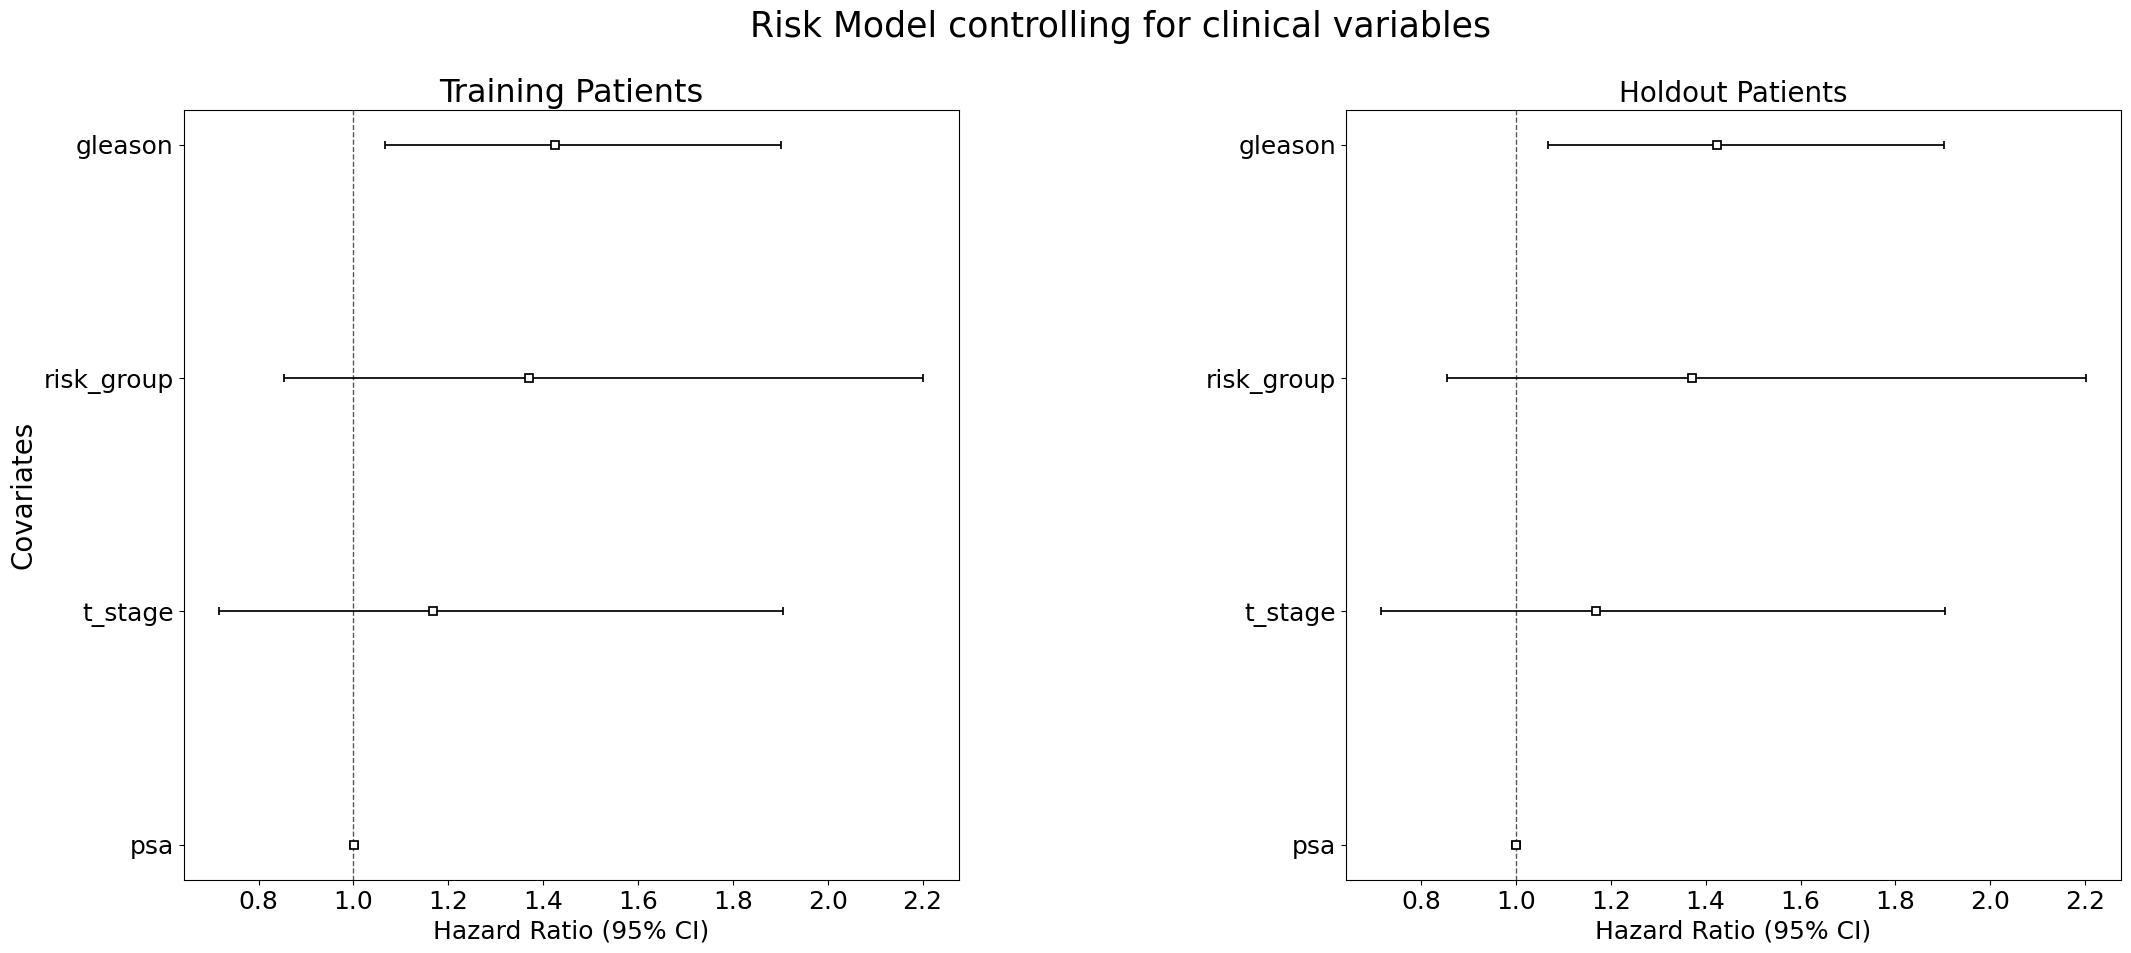

In [249]:
holdout_results, cph_holdout_adjusted_risk = get_multivariate_coxph_results(multivar_analysis_df_all_patients)
plt_title = 'Risk Model controlling for clinical variables'
save_path = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/controlled_risk_model.png'
plot_n_save_adjusted_hazard(cph_holdout_adjusted_risk, cph_holdout_adjusted_risk, multivar_analysis_df_all_patients, multivar_analysis_df_all_patients, save_path, plt_title)
cph_holdout_adjusted_risk.print_summary()

now only on non chemo patients

In [250]:
multivar_analysis_df_only_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 1]

In [251]:
multivar_analysis_df_only_chemo

,patient_id,event,time,risk_score,risk_group,chemo,interaction_term,age,race,gleason,psa,t_stage
25,0521-024492,0,9.430781,0.605664,1,1,1,68,5,10,8.70,9
26,0521-047316,1,8.213699,0.069897,1,1,1,69,5,9,1.50,10
27,0521-049529,1,2.539726,0.351177,1,1,1,75,5,8,12.60,7
28,0521-056372,1,8.605225,0.857809,1,1,1,64,5,9,120.00,7
29,0521-090916,0,11.646575,2.486291,1,1,1,59,5,7,49.00,9
...,...,...,...,...,...,...,...,...,...,...,...,...
227,0521-972417,0,12.673973,-0.525367,0,1,0,59,5,8,3.10,6
228,0521-979111,0,4.619178,-0.613657,0,1,0,69,5,8,17.16,9
229,0521-979162,0,12.649315,-0.783629,0,1,0,59,5,8,39.51,8
230,0521-998850,0,10.612606,-0.902397,0,1,0,64,5,8,19.70,5


In [252]:
multivar_analysis_df_only_chemo.drop(columns=['age', 'race', 'chemo', 'interaction_term', 'risk_score'], inplace=True)
# binarize t_stage 
multivar_analysis_df_only_chemo['t_stage'] = np.where(multivar_analysis_df_only_chemo['t_stage'] > 7, 1, 0)

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\817991919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_only_chemo.drop(columns=['age', 'race', 'chemo', 'interaction_term', 'risk_score'], inplace=True)
C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\817991919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_only_chemo['t_stage'] = np.where(multivar_analysis_df_only_chemo['t_stage'] > 7, 1, 0)


In [253]:
multivar_analysis_df_only_chemo[multivar_analysis_df_only_chemo.isna().any(axis=1)]

,patient_id,event,time,risk_group,gleason,psa,t_stage


FileNotFoundError: [Errno 2] No such file or directory: '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/controlled_risk_model_CT.png'

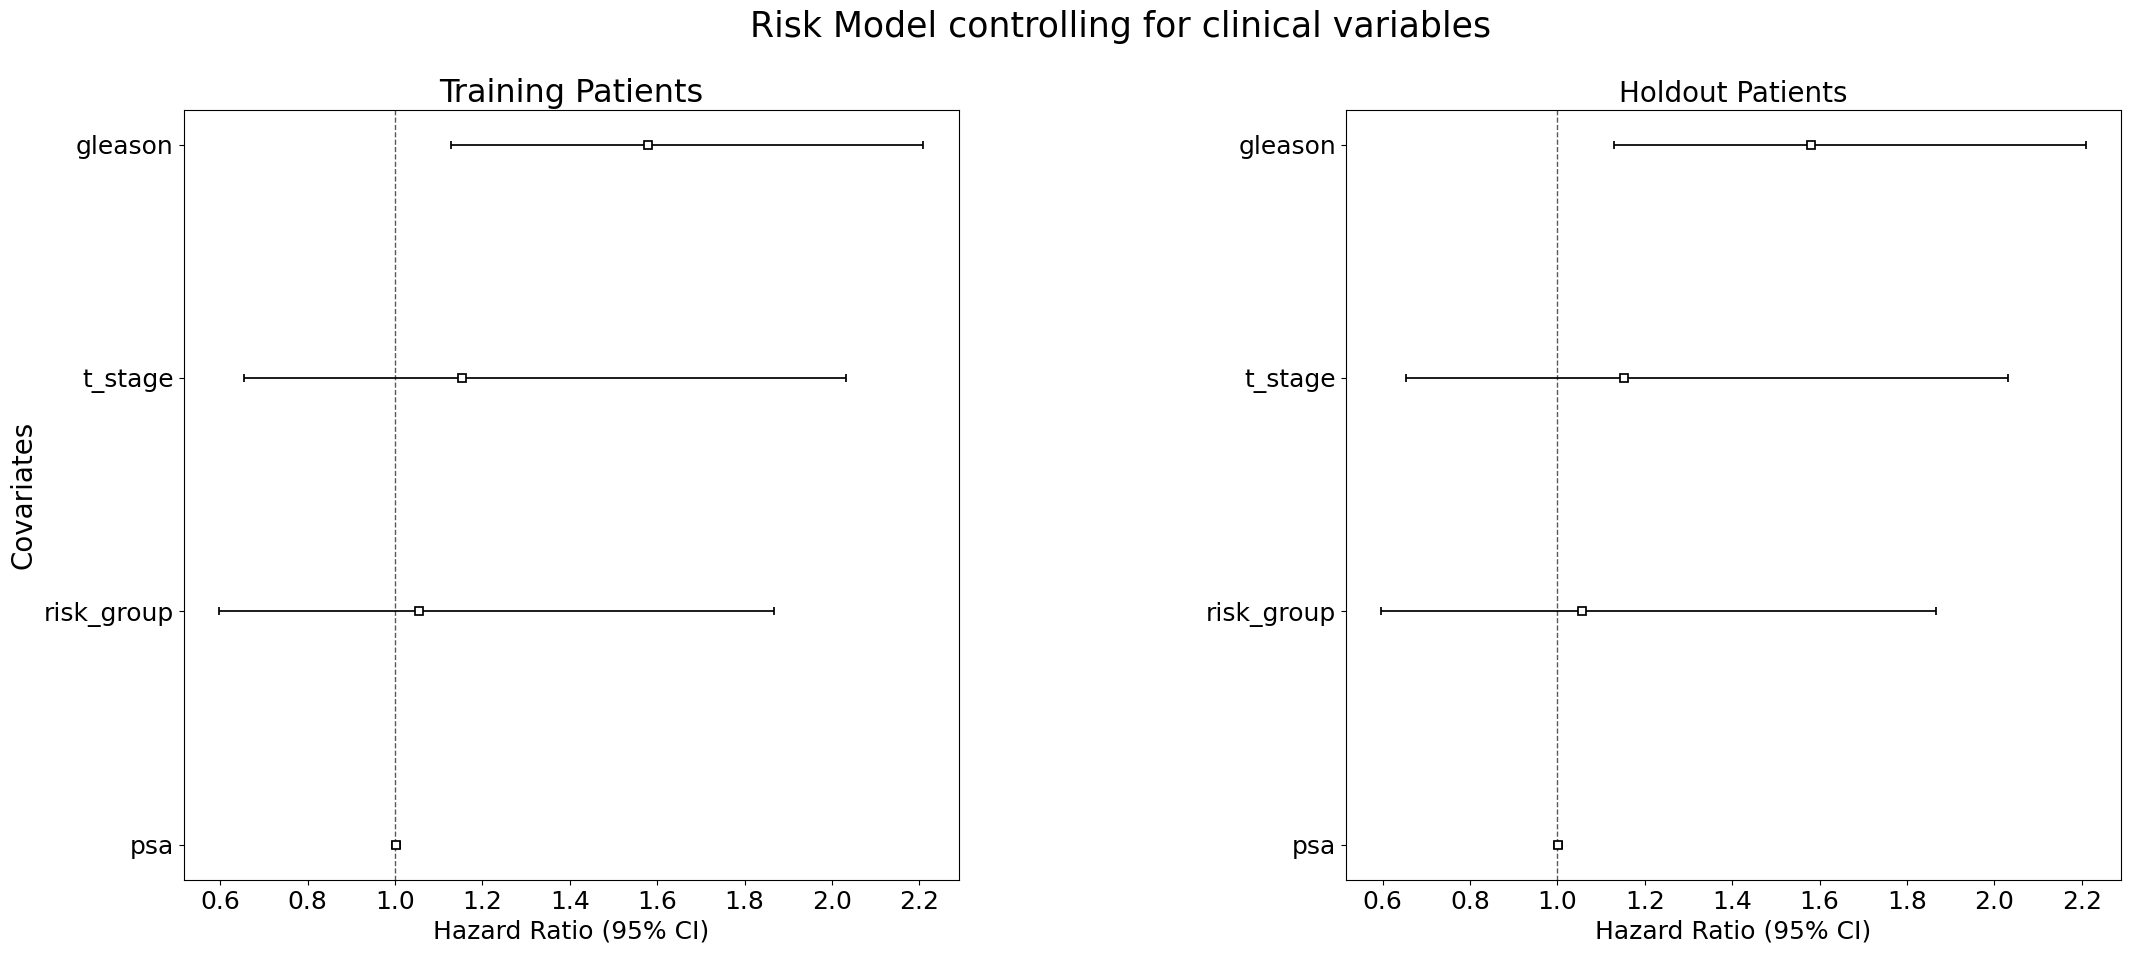

In [254]:
holdout_results, cph_holdout_adjusted_risk = get_multivariate_coxph_results(multivar_analysis_df_only_chemo)
plt_title = 'Risk Model controlling for clinical variables'
save_path = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/controlled_risk_model_CT.png'
plot_n_save_adjusted_hazard(cph_holdout_adjusted_risk, cph_holdout_adjusted_risk, multivar_analysis_df_only_chemo, multivar_analysis_df_only_chemo, save_path, plt_title)
cph_holdout_adjusted_risk.print_summary()

non-chemo patients

In [255]:
multivar_analysis_df_no_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 0]

In [256]:
multivar_analysis_df_no_chemo.drop(columns=['age', 'race', 'chemo', 'interaction_term', 'risk_score'], inplace=True)
multivar_analysis_df_no_chemo['t_stage'] = np.where(multivar_analysis_df_no_chemo['t_stage'] > 7, 1, 0)

C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\3859527610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_no_chemo.drop(columns=['age', 'race', 'chemo', 'interaction_term', 'risk_score'], inplace=True)
C:\Users\smedin7\AppData\Local\Temp\ipykernel_126256\3859527610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivar_analysis_df_no_chemo['t_stage'] = np.where(multivar_analysis_df_no_chemo['t_stage'] > 7, 1, 0)


In [257]:
multivar_analysis_df_no_chemo[multivar_analysis_df_no_chemo.isna().any(axis=1)]

,patient_id,event,time,risk_group,gleason,psa,t_stage


FileNotFoundError: [Errno 2] No such file or directory: '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/controlled_risk_model_no_CT.png'

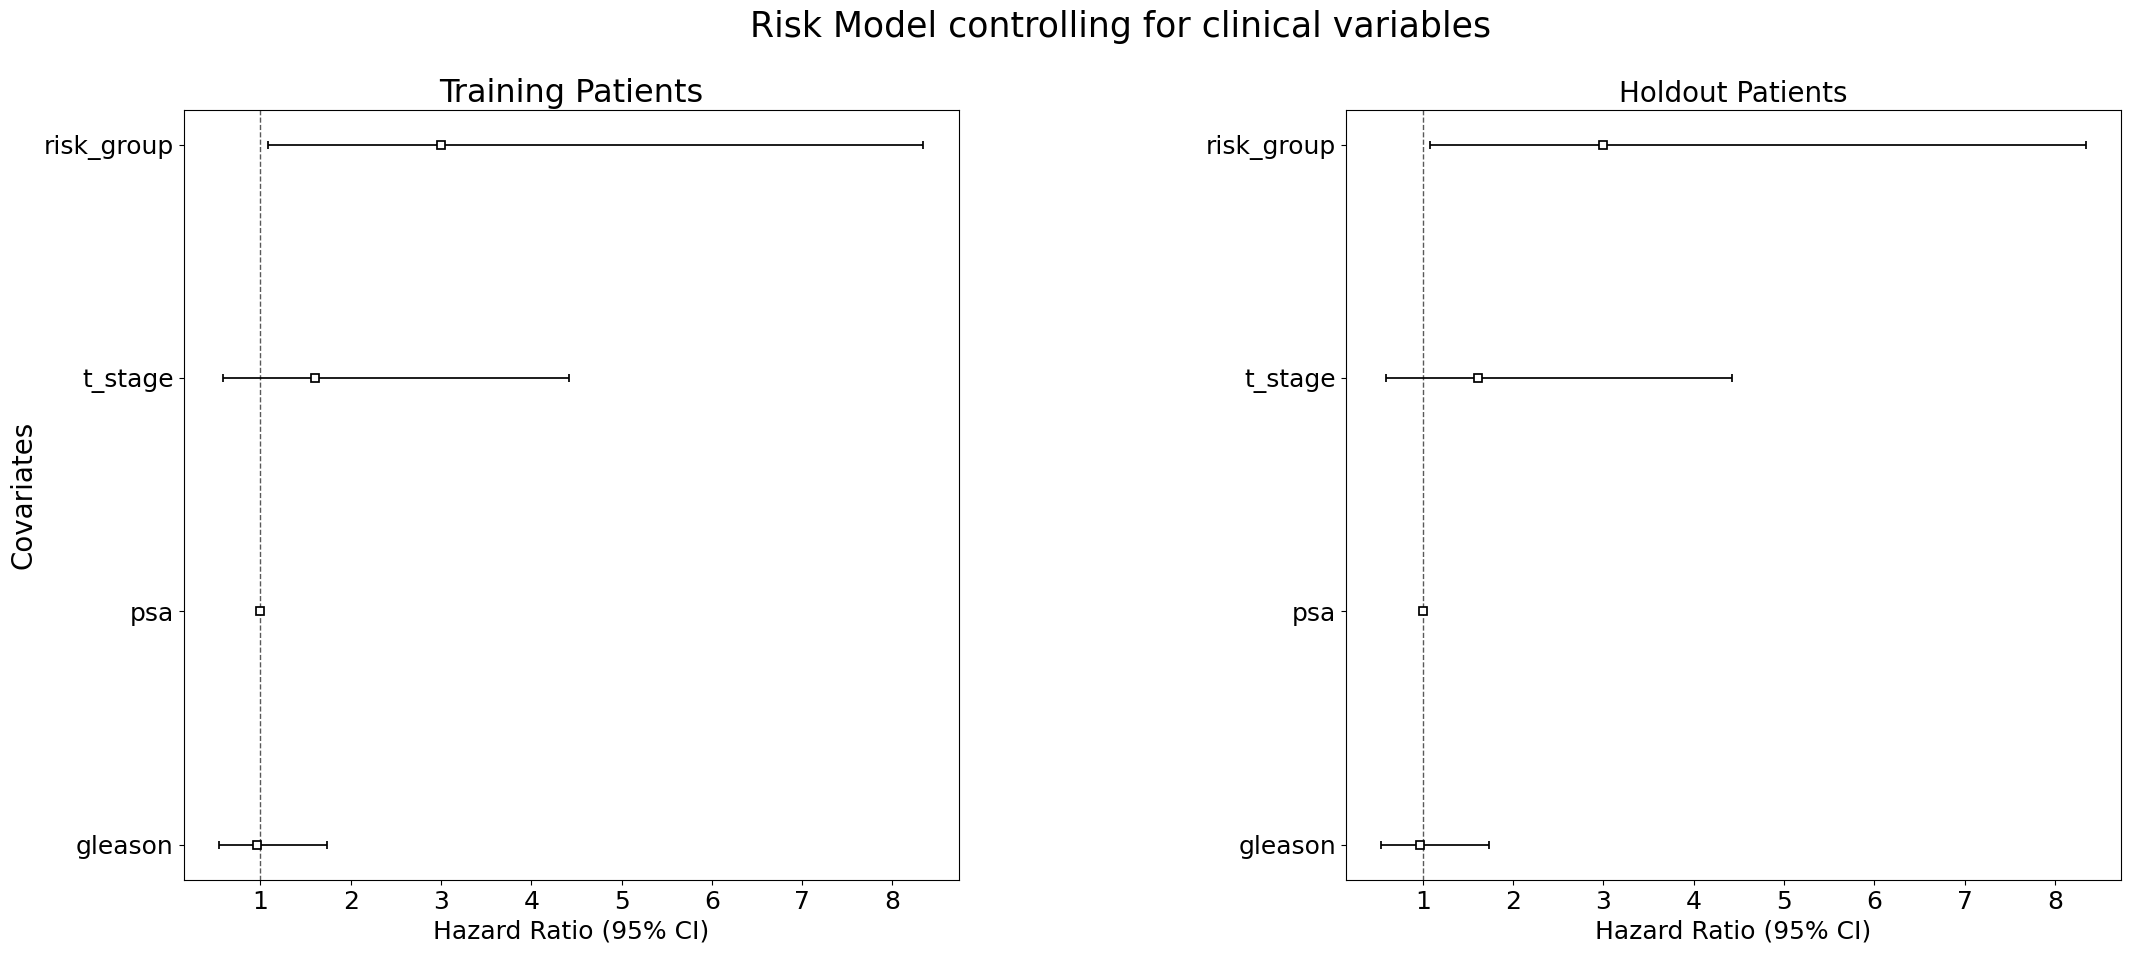

In [258]:
holdout_results, cph_holdout_adjusted_risk = get_multivariate_coxph_results(multivar_analysis_df_no_chemo)
plt_title = 'Risk Model controlling for clinical variables'
save_path = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/controlled_risk_model_no_CT.png'
plot_n_save_adjusted_hazard(cph_holdout_adjusted_risk, cph_holdout_adjusted_risk, multivar_analysis_df_no_chemo, multivar_analysis_df_no_chemo, save_path, plt_title)
cph_holdout_adjusted_risk.print_summary()

In [259]:
multivar_analysis_df_no_chemo

,patient_id,event,time,risk_group,gleason,psa,t_stage
0,0521-032790,1,2.810959,1,9,1.50,1
1,0521-061895,0,4.449315,1,8,58.40,0
2,0521-123562,0,10.625810,1,8,6.60,0
3,0521-140656,0,9.487671,1,9,14.48,0
4,0521-195042,1,3.674542,1,9,19.88,0
5,0521-225186,1,4.794521,1,8,3.96,0
6,0521-267209,0,10.755042,1,9,3.46,1
7,0521-299923,0,10.802171,1,8,12.90,0
8,0521-336687,1,6.830137,1,8,53.70,0
9,0521-363488,1,1.719410,1,9,10.80,0


In [260]:
results = {}
variables = ['risk_group','psa', 't_stage', 'gleason']
cph = CoxPHFitter()
for var in variables:

    cph.fit(multivar_analysis_df_all_patients[[var, 'time', 'event']], duration_col='time', event_col='event')
    
    # Extract the HR and its confidence intervals for the variable
    cph_model_results = cph.summary
    p = cph_model_results['p'].values[0]
    hr = cph_model_results['exp(coef)'].values[0]
    ci_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    ci_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    # Store the results
    results[var] = {'HR': hr, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper, 'p': p}

# Display the results
print("Univariate analysis all patients")
for var, stats in results.items():
    print(f"{var}: HR = {stats['HR']:.4f}, 95% CI = ({stats['95% CI Lower']:.4f}, {stats['95% CI Upper']:.4f}), p = {stats['p']:.6f}")

Univariate analysis all patients
risk_group: HR = 1.3807, 95% CI = (0.8608, 2.2147), p = 0.180814
psa: HR = 0.9996, 95% CI = (0.9912, 1.0080), p = 0.922250
t_stage: HR = 1.1990, 95% CI = (0.7351, 1.9556), p = 0.467271
gleason: HR = 1.4190, 95% CI = (1.0638, 1.8928), p = 0.017277


In [261]:
results = {}
variables = ['risk_group','psa', 't_stage', 'gleason']
cph = CoxPHFitter()
for var in variables:

    cph.fit(multivar_analysis_df_only_chemo[[var, 'time', 'event']], duration_col='time', event_col='event')
    
    # Extract the HR and its confidence intervals for the variable
    cph_model_results = cph.summary
    p = cph_model_results['p'].values[0]
    hr = cph_model_results['exp(coef)'].values[0]
    ci_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    ci_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    # Store the results
    results[var] = {'HR': hr, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper, 'p': p}

# Display the results
print("Univariate analysis CT patients")
for var, stats in results.items():
    print(f"{var}: HR = {stats['HR']:.4f}, 95% CI = ({stats['95% CI Lower']:.4f}, {stats['95% CI Upper']:.4f}), p = {stats['p']:.6f}")

Univariate analysis CT patients
risk_group: HR = 1.0558, 95% CI = (0.6000, 1.8581), p = 0.850561
psa: HR = 1.0003, 95% CI = (0.9909, 1.0098), p = 0.943545
t_stage: HR = 1.1517, 95% CI = (0.6553, 2.0243), p = 0.623448
gleason: HR = 1.5726, 95% CI = (1.1223, 2.2037), p = 0.008535


In [262]:
results = {}
variables = ['risk_group','psa', 't_stage', 'gleason']
cph = CoxPHFitter()
for var in variables:

    cph.fit(multivar_analysis_df_no_chemo[[var, 'time', 'event']], duration_col='time', event_col='event')
    
    # Extract the HR and its confidence intervals for the variable
    cph_model_results = cph.summary
    p = cph_model_results['p'].values[0]
    hr = cph_model_results['exp(coef)'].values[0]
    ci_lower = cph_model_results['exp(coef) lower 95%'].values[0]
    ci_upper = cph_model_results['exp(coef) upper 95%'].values[0]
    # Store the results
    results[var] = {'HR': hr, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper, 'p': p}

# Display the results
print("Univariate analysis no CT patients")
for var, stats in results.items():
    print(f"{var}: HR = {stats['HR']:.4f}, 95% CI = ({stats['95% CI Lower']:.4f}, {stats['95% CI Upper']:.4f}), p = {stats['p']:.6f}")

Univariate analysis no CT patients
risk_group: HR = 2.8828, 95% CI = (1.0566, 7.8654), p = 0.038686
psa: HR = 0.9963, 95% CI = (0.9784, 1.0145), p = 0.686779
t_stage: HR = 1.4743, 95% CI = (0.5505, 3.9485), p = 0.439955
gleason: HR = 1.0527, 95% CI = (0.6047, 1.8326), p = 0.855956


In [263]:
multivar_analysis_df

,patient_id,event,time,risk_score,risk_group,chemo,interaction_term,age,race,gleason,psa,t_stage
0,0521-032790,1,2.810959,0.246811,1,0,0,78,5,9,1.50,9
1,0521-061895,0,4.449315,0.749790,1,0,0,69,5,8,58.40,7
2,0521-123562,0,10.625810,1.051016,1,0,0,70,3,8,6.60,6
3,0521-140656,0,9.487671,0.737719,1,0,0,73,5,9,14.48,7
4,0521-195042,1,3.674542,0.859777,1,0,0,57,3,9,19.88,4
...,...,...,...,...,...,...,...,...,...,...,...,...
227,0521-972417,0,12.673973,-0.525367,0,1,0,59,5,8,3.10,6
228,0521-979111,0,4.619178,-0.613657,0,1,0,69,5,8,17.16,9
229,0521-979162,0,12.649315,-0.783629,0,1,0,59,5,8,39.51,8
230,0521-998850,0,10.612606,-0.902397,0,1,0,64,5,8,19.70,5


In [264]:
risk_threshold

0.06374719940422713

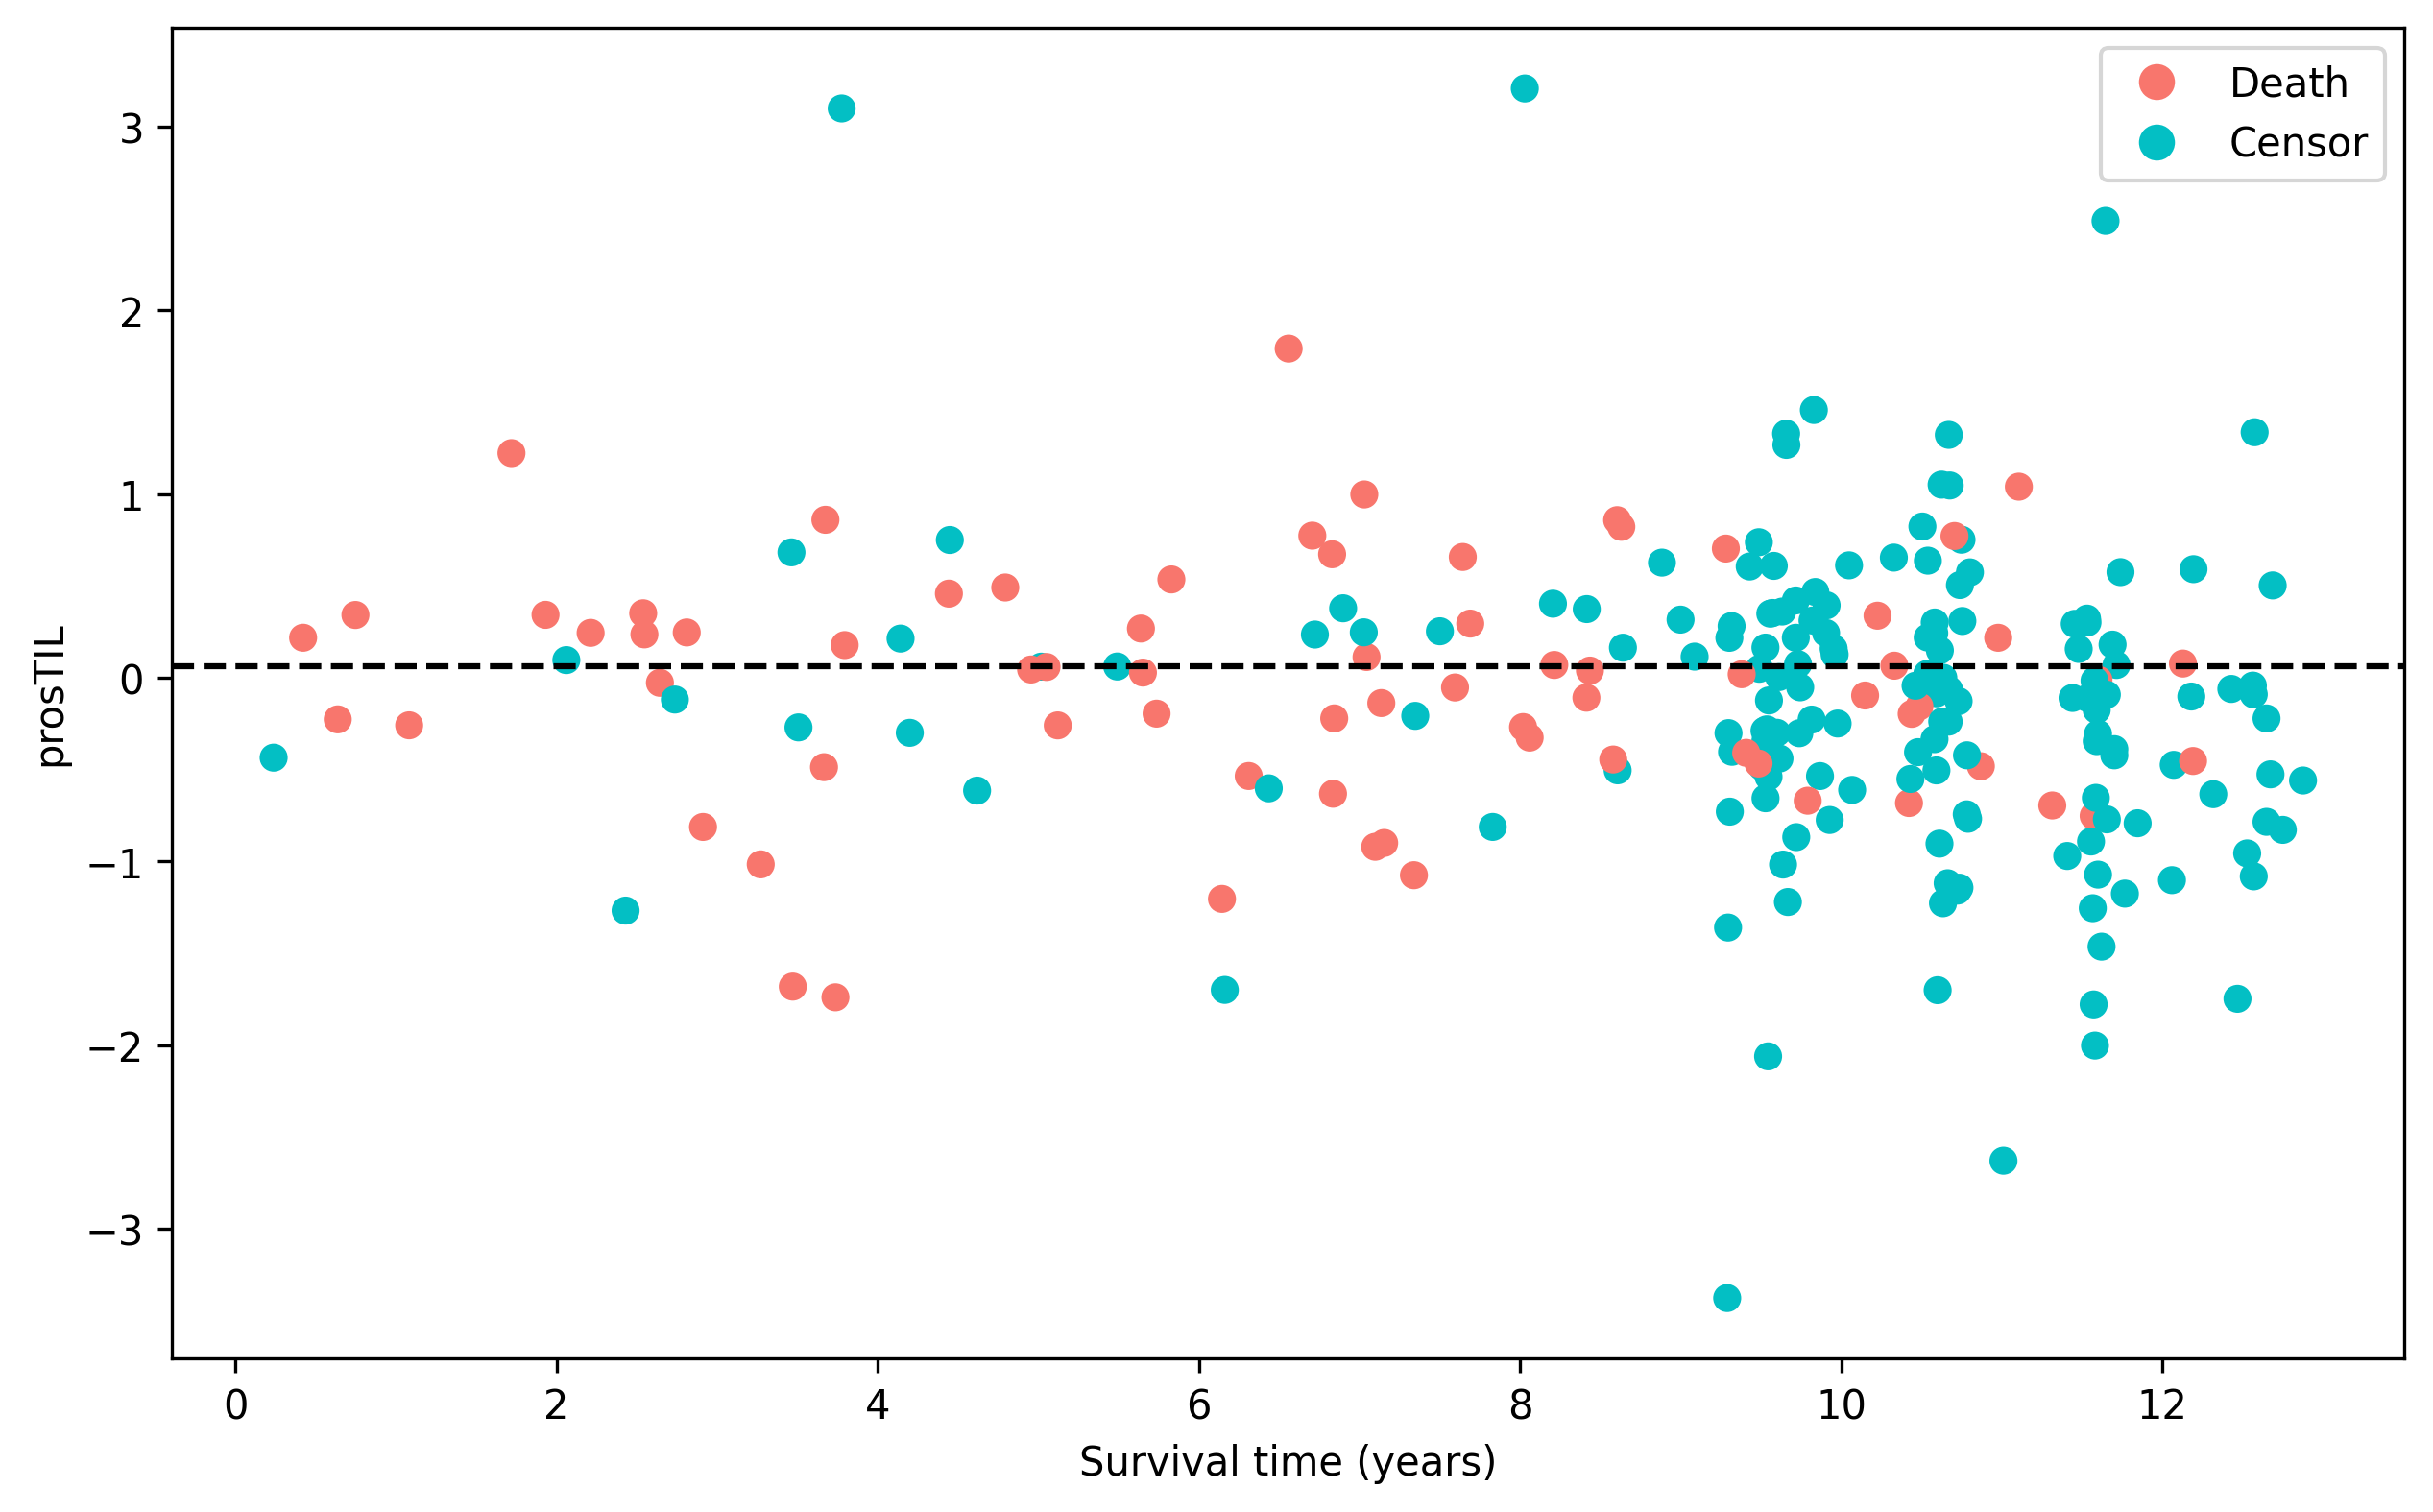

In [265]:
# Set up the figure with high DPI for better quality
plt.figure(figsize=(10, 6), dpi=300)
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#03bfc4','#f8766d'])
scatter = plt.scatter(multivar_analysis_df['time'], multivar_analysis_df['risk_score'], c=pd.Categorical(multivar_analysis_df['event']).codes, cmap=cmap, label=multivar_analysis_df['event'], linewidths=1)
plt.axhline(y=risk_threshold, color='black', linestyle='--', 
            label=f'Risk Threshold: {risk_threshold}')
plt.xlabel('Survival time (years)')
plt.ylabel('prosTIL')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Death', markerfacecolor='#f8766d', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='Censor', markerfacecolor='#03bfc4', markersize=10)])

# Show plot
plt.show()

#### NET BENEFIT

In [268]:
from dcurves import dca, plot_graphs

ModuleNotFoundError: No module named 'dcurves'

In [ ]:
multivar_analysis_df

In [ ]:
net_benefit_df = multivar_analysis_df[['event', 'time', 'risk_group']]

In [ ]:
net_benefit_df

In [ ]:
cox_dca = CoxPHFitter()

cox_dca.fit(df=net_benefit_df, duration_col='time', event_col='event')


In [ ]:
cox_dca.summary

In [ ]:
cph_pred_vals = \
      cox_dca.predict_survival_function(
          net_benefit_df[['risk_group']],
          times=[10])

In [ ]:
net_benefit_df['Prediction model'] = [1 - val for val in cph_pred_vals.iloc[0, :]]

In [ ]:
net_benefit_df

In [ ]:
cph_pred_vals

In [ ]:
stdca_coxph_results = \
          dca(
              data=net_benefit_df,
              outcome='event',
              modelnames=['Prediction model'],
              thresholds=np.arange(0, 0.51, 0.01),
              time=10,
              time_to_outcome_col='time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.25],
    color_names=['green', 'red', 'blue'],
    show_grid=False,
    file_name = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/net_benefit_all',
    dpi=300
    
  )

In [ ]:
#### only in non-chemo treated patients

net_benefit_df_no_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 0]

In [ ]:
net_benefit_df_no_chemo

In [ ]:
net_benefit_df_no_chemo = net_benefit_df_no_chemo[['event', 'time', 'risk_group']]

In [ ]:
cox_dca = CoxPHFitter()

cox_dca.fit(df=net_benefit_df_no_chemo, duration_col='time', event_col='event')
cox_dca.summary

In [ ]:
cph_pred_vals = \
      cox_dca.predict_survival_function(
          net_benefit_df_no_chemo[['risk_group']],
          times=[10])

In [ ]:
net_benefit_df_no_chemo['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0, :]]

In [ ]:
stdca_coxph_results = \
          dca(
              data=net_benefit_df_no_chemo,
              outcome='event',
              modelnames=['Predictive model'],
              thresholds=np.arange(0, 0.51, 0.01),
              time=10,
              time_to_outcome_col='time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.25],
    color_names=['green', 'red', 'blue'],
    show_grid=False,
    file_name = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/net_benefit_RT+ADT',
    dpi=300
  )


In [ ]:
#### chemo only

net_benefit_df_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 1]


In [ ]:
net_benefit_df_chemo = net_benefit_df_chemo[['event', 'time', 'risk_group']]

In [ ]:
cox_dca = CoxPHFitter()

cox_dca.fit(df=net_benefit_df_chemo, duration_col='time', event_col='event')
cox_dca.summary

In [ ]:
cph_pred_vals = \
      cox_dca.predict_survival_function(
          net_benefit_df_chemo[['risk_group']],
          times=[10])

In [ ]:
net_benefit_df_chemo['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0, :]]

In [ ]:
stdca_coxph_results = \
          dca(
              data=net_benefit_df_chemo,
              outcome='event',
              modelnames=['Predictive model'],
              thresholds=np.arange(0, 0.51, 0.01),
              time=10,
              time_to_outcome_col='time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.25],
    color_names=['green', 'red', 'blue'],
    show_grid=False,
    file_name = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/net_benefit_RT+ADT+CT',
    dpi=300
  )


In [ ]:
net_benefit_df = multivar_analysis_df[['event', 'time', 'risk_score']]
net_benefit_df
cox_dca = CoxPHFitter()

cox_dca.fit(df=net_benefit_df, duration_col='time', event_col='event')

cox_dca.summary
cph_pred_vals = \
      cox_dca.predict_survival_function(
          net_benefit_df[['risk_score']],
          times=[10])
net_benefit_df['Prediction model'] = [1 - val for val in cph_pred_vals.iloc[0, :]]
net_benefit_df
cph_pred_vals
stdca_coxph_results = \
          dca(
              data=net_benefit_df,
              outcome='event',
              modelnames=['Prediction model'],
              thresholds=np.arange(0, 0.51, 0.01),
              time=10,
              time_to_outcome_col='time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.25],
    color_names=['green', 'red', 'blue'],
    show_grid=False,
    file_name = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/net_benefit_all_risk_score',
    dpi=300
    
  )




In [ ]:
#### only in non-chemo treated patients

net_benefit_df_no_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 0]
net_benefit_df_no_chemo
net_benefit_df_no_chemo = net_benefit_df_no_chemo[['event', 'time', 'risk_score']]
cox_dca = CoxPHFitter()

cox_dca.fit(df=net_benefit_df_no_chemo, duration_col='time', event_col='event')
cox_dca.summary
cph_pred_vals = \
      cox_dca.predict_survival_function(
          net_benefit_df_no_chemo[['risk_score']],
          times=[10])
net_benefit_df_no_chemo['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0, :]]
stdca_coxph_results = \
          dca(
              data=net_benefit_df_no_chemo,
              outcome='event',
              modelnames=['Predictive model'],
              thresholds=np.arange(0, 0.51, 0.01),
              time=10,
              time_to_outcome_col='time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.1, 0.25],
    color_names=['green', 'red', 'blue'],
    show_grid=False,
    file_name = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/net_benefit_RT+ADT_risk_score',
    dpi=300
  )

In [ ]:
#### chemo only

net_benefit_df_chemo = multivar_analysis_df[multivar_analysis_df['chemo'] == 1]

net_benefit_df_chemo = net_benefit_df_chemo[['event', 'time', 'risk_score']]
cox_dca = CoxPHFitter()

cox_dca.fit(df=net_benefit_df_chemo, duration_col='time', event_col='event')
cox_dca.summary
cph_pred_vals = \
      cox_dca.predict_survival_function(
          net_benefit_df_chemo[['risk_score']],
          times=[10])
net_benefit_df_chemo['Predictive model'] = [1 - val for val in cph_pred_vals.iloc[0, :]]
stdca_coxph_results = \
          dca(
              data=net_benefit_df_chemo,
              outcome='event',
              modelnames=['Predictive model'],
              thresholds=np.arange(0, 0.51, 0.01),
              time=10,
              time_to_outcome_col='time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.25],
    color_names=['green', 'red', 'blue'],
    show_grid=False,
    file_name = '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/net_benefit_RT+ADT+CT_risk_score',
    dpi=300
  )


### umaps

In [ ]:
import umap

In [ ]:
multivar_analysis_df

In [ ]:
X_holdout_trimmed

In [ ]:
X_holdout_decipher_trimmed

In [ ]:
X_holdout_umap = pd.concat([X_holdout_trimmed, X_holdout_decipher_trimmed]).reset_index(drop=True)

In [ ]:
X_holdout_umap

In [ ]:
X_holdout_umap = pd.concat([X_holdout_umap, multivar_analysis_df[['risk_group', 'chemo', 'event']]], axis=1)

In [ ]:
X_holdout_umap

In [ ]:
X = X_holdout_umap.drop(columns=['event', 'chemo', 'risk_group'])

In [ ]:
reducer = umap.UMAP(densmap=True)
# Fit and transform the data
embedding = reducer.fit_transform(X)

# Add the embedding coordinates back to the dataframe
X_holdout_umap['umap_x'] = embedding[:, 0]
X_holdout_umap['umap_y'] = embedding[:, 1]

# Plotting
plt.figure(figsize=(12, 8), dpi=300)
# Smooth gradient density plots for each group
sns.kdeplot(
    data=X_holdout_umap[X_holdout_umap['risk_group'] == 1],
    x='umap_x', y='umap_y', fill=True, cmap='Reds', alpha=0.6, label='Biomarker +'
)
sns.kdeplot(
    data=X_holdout_umap[X_holdout_umap['risk_group'] == 0],
    x='umap_x', y='umap_y', fill=True, cmap='Blues', alpha=0.6, label='Biomarker -'
)
# Scatter plot for all data points
scatter = sns.scatterplot(
    data=X_holdout_umap, x='umap_x', y='umap_y', hue='risk_group',
    palette={0: 'blue', 1: 'red'}, alpha=1.0, edgecolor='k', linewidth=0.5
)

plt.title('UMAP Visualization of Model Predictions all patients')
handles, labels = scatter.get_legend_handles_labels()
labels = ['Biomarker +', 'Biomarker -']
plt.legend(handles=handles, title='Risk Category', labels=labels)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
X_holdout_umap_no_chemo = X_holdout_umap[X_holdout_umap['chemo'] == 0]
X = X_holdout_umap_no_chemo.drop(columns=['event', 'chemo', 'risk_group'])

In [ ]:
reducer = umap.UMAP(densmap=True)
# Fit and transform the data
embedding = reducer.fit_transform(X)

# Add the embedding coordinates back to the dataframe
X_holdout_umap_no_chemo['umap_x'] = embedding[:, 0]
X_holdout_umap_no_chemo['umap_y'] = embedding[:, 1]

# Plotting
plt.figure(figsize=(12, 8), dpi=300)
# Smooth gradient density plots for each group
sns.kdeplot(
    data=X_holdout_umap_no_chemo[X_holdout_umap_no_chemo['risk_group'] == 1],
    x='umap_x', y='umap_y', fill=True, cmap='Reds', alpha=0.6, label='Biomarker +'
)
sns.kdeplot(
    data=X_holdout_umap_no_chemo[X_holdout_umap_no_chemo['risk_group'] == 0],
    x='umap_x', y='umap_y', fill=True, cmap='Blues', alpha=0.6, label='Biomarker -'
)
# Scatter plot for all data points
scatter = sns.scatterplot(
    data=X_holdout_umap_no_chemo, x='umap_x', y='umap_y', hue='risk_group',
    palette={0: 'blue', 1: 'red'}, alpha=1.0, edgecolor='k', linewidth=0.5
)

plt.title('UMAP Visualization of Model Predictions RT+ADT treated patients')
handles, labels = scatter.get_legend_handles_labels()
labels = ['Biomarker +', 'Biomarker -']
plt.legend(handles=handles, title='Risk Category', labels=labels)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
X_holdout_umap_chemo = X_holdout_umap[X_holdout_umap['chemo'] == 1]
X = X_holdout_umap_chemo.drop(columns=['event', 'chemo', 'risk_group'])

In [ ]:
reducer = umap.UMAP(densmap=True)
# Fit and transform the data
embedding = reducer.fit_transform(X)

# Add the embedding coordinates back to the dataframe
X_holdout_umap_chemo['umap_x'] = embedding[:, 0]
X_holdout_umap_chemo['umap_y'] = embedding[:, 1]

# Plotting
plt.figure(figsize=(12, 8), dpi=300)
# Smooth gradient density plots for each group
sns.kdeplot(
    data=X_holdout_umap_chemo[X_holdout_umap_chemo['risk_group'] == 1],
    x='umap_x', y='umap_y', fill=True, cmap='Reds', alpha=0.6, label='Biomarker +'
)
sns.kdeplot(
    data=X_holdout_umap_chemo[X_holdout_umap_chemo['risk_group'] == 0],
    x='umap_x', y='umap_y', fill=True, cmap='Blues', alpha=0.6, label='Biomarker -'
)
# Scatter plot for all data points
scatter = sns.scatterplot(
    data=X_holdout_umap_chemo, x='umap_x', y='umap_y', hue='risk_group',
    palette={0: 'blue', 1: 'red'}, alpha=1.0, edgecolor='k', linewidth=0.5
)

plt.title('UMAP Visualization of Model Predictions RT+ADT+CT treated patients')
handles, labels = scatter.get_legend_handles_labels()
labels = ['Biomarker +', 'Biomarker -']
plt.legend(handles=handles, title='Risk Category', labels=labels)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
X_holdout_umap_biomarker_plus = X_holdout_umap[X_holdout_umap['risk_group'] == 1]
X = X_holdout_umap_biomarker_plus.drop(columns=['event', 'chemo', 'risk_group'])

In [ ]:
reducer = umap.UMAP(densmap=True)
# Fit and transform the data
embedding = reducer.fit_transform(X)

# Add the embedding coordinates back to the dataframe
X_holdout_umap_biomarker_plus['umap_x'] = embedding[:, 0]
X_holdout_umap_biomarker_plus['umap_y'] = embedding[:, 1]

# Plotting
plt.figure(figsize=(12, 8), dpi=300)
# Smooth gradient density plots for each group
sns.kdeplot(
    data=X_holdout_umap_biomarker_plus[X_holdout_umap_biomarker_plus['chemo'] == 1],
    x='umap_x', y='umap_y', fill=True, cmap='Reds', alpha=0.6, label='RT+ADT+CT'
)
sns.kdeplot(
    data=X_holdout_umap_biomarker_plus[X_holdout_umap_biomarker_plus['chemo'] == 0],
    x='umap_x', y='umap_y', fill=True, cmap='Blues', alpha=0.6, label='RT+ADT'
)
# Scatter plot for all data points
scatter = sns.scatterplot(
    data=X_holdout_umap_biomarker_plus, x='umap_x', y='umap_y', hue='chemo',
    palette={0: 'blue', 1: 'red'}, alpha=1.0, edgecolor='k', linewidth=0.5
)

plt.title('UMAP Visualization of biomarker+ patients by treatment')
handles, labels = scatter.get_legend_handles_labels()
labels = ['RT+ADT+CT', 'RT+ADT']
plt.legend(handles=handles, title='Risk Category', labels=labels)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
X_holdout_umap_biomarker_minus = X_holdout_umap[X_holdout_umap['risk_group'] == 0]
X = X_holdout_umap_biomarker_minus.drop(columns=['event', 'chemo', 'risk_group'])
reducer = umap.UMAP(densmap=True)
# Fit and transform the data
embedding = reducer.fit_transform(X)

# Add the embedding coordinates back to the dataframe
X_holdout_umap_biomarker_minus['umap_x'] = embedding[:, 0]
X_holdout_umap_biomarker_minus['umap_y'] = embedding[:, 1]

# Plotting
plt.figure(figsize=(12, 8), dpi=300)
# Smooth gradient density plots for each group
sns.kdeplot(
    data=X_holdout_umap_biomarker_minus[X_holdout_umap_biomarker_minus['chemo'] == 1],
    x='umap_x', y='umap_y', fill=True, cmap='Reds', alpha=0.6, label='RT+ADT+CT'
)
sns.kdeplot(
    data=X_holdout_umap_biomarker_minus[X_holdout_umap_biomarker_minus['chemo'] == 0],
    x='umap_x', y='umap_y', fill=True, cmap='Blues', alpha=0.6, label='RT+ADT'
)
# Scatter plot for all data points
scatter = sns.scatterplot(
    data=X_holdout_umap_biomarker_minus, x='umap_x', y='umap_y', hue='chemo',
    palette={0: 'blue', 1: 'red'}, alpha=1.0, edgecolor='k', linewidth=0.5
)

plt.title('UMAP Visualization of biomarker- patients by treatment')
handles, labels = scatter.get_legend_handles_labels()
labels = ['RT+ADT+CT', 'RT+ADT']
plt.legend(handles=handles, title='Risk Category', labels=labels)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()